In [1]:
import os
import shutil
import tempfile
import time
from typing import Any, Dict, List, Tuple, Union

import argparse
import joblib
from joblib import Parallel, delayed
import numpy as np
import pickle as pkl
from termcolor import cprint
import torch
import torch.nn as nn
import torch.nn.functional as F

from logger import Logger
import utils.baseline_config as config
import utils.baseline_utils as baseline_utils
from utils.lstm_utils import ModelUtils, LSTMDataset

use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
global_step = 0
best_loss = float("inf")
np.random.seed(100)

ROLLOUT_LENS = [1, 10, 30]

In [2]:
from prob_lstm_train_test import *

In [3]:
import shlex

parser = argparse.ArgumentParser()
parser.add_argument("--test_batch_size",
                    type=int,
                    default=512,
                    help="Test batch size")
parser.add_argument("--model_path",
                    required=False,
                    type=str,
                    help="path to the saved model")
parser.add_argument("--obs_len",
                    default=20,
                    type=int,
                    help="Observed length of the trajectory")
parser.add_argument("--pred_len",
                    default=30,
                    type=int,
                    help="Prediction Horizon")
parser.add_argument(
    "--normalize",
    action="store_true",
    help="Normalize the trajectories if non-map baseline is used",
)
parser.add_argument(
    "--use_delta",
    action="store_true",
    help="Train on the change in position, instead of absolute position",
)
parser.add_argument(
    "--train_features",
    default="",
    type=str,
    help="path to the file which has train features.",
)
parser.add_argument(
    "--val_features",
    default="",
    type=str,
    help="path to the file which has val features.",
)
parser.add_argument(
    "--test_features",
    default="",
    type=str,
    help="path to the file which has test features.",
)
parser.add_argument(
    "--joblib_batch_size",
    default=100,
    type=int,
    help="Batch size for parallel computation",
)
parser.add_argument("--use_map",
                    action="store_true",
                    help="Use the map based features")
parser.add_argument("--use_social",
                    action="store_true",
                    help="Use social features")
parser.add_argument("--test",
                    action="store_true",
                    help="If true, only run the inference")
parser.add_argument("--train_batch_size",
                    type=int,
                    default=512,
                    help="Training batch size")
parser.add_argument("--val_batch_size",
                    type=int,
                    default=512,
                    help="Val batch size")
parser.add_argument("--end_epoch",
                    type=int,
                    default=5000,
                    help="Last epoch")
parser.add_argument("--lr",
                    type=float,
                    default=0.001,
                    help="Learning rate")
parser.add_argument(
    "--traj_save_path",
    required=False,
    type=str,
    help=
    "path to the pickle file where forecasted trajectories will be saved.",
)
    
argString = '--test_features features/val.pkl --train_features features/train.pkl  --val_features features/val.pkl --use_delta --normalize --obs_len 20 --pred_len 30 --model_path model/lstm_prob.pkl --traj_save_path traj/lstm_prob.pkl'
args = parser.parse_args(shlex.split(argString))

In [5]:
model_utils = ModelUtils()
data_dict = baseline_utils.get_data(args, 'none')

Loading Test data ...
Normalizing ...
Creating relative distances...
Test Size: 39472
Loading Train data ...
Normalizing ...
Creating relative distances...
Train Size: 205942
Loading Val data ...
Normalizing ...
Creating relative distances...
Val Size: 39472


In [10]:
data_dict.keys()

dict_keys(['train_input', 'val_input', 'test_input', 'train_output', 'val_output', 'test_output', 'train_helpers', 'val_helpers', 'test_helpers'])

In [68]:
data_dict['test_helpers']#.shape

SEQUENCE                                           FEATURES  \
0       7510  [[315968760.48507446, 00000000-0000-0000-0000-...   
1       8337  [[315975467.32078063, 00000000-0000-0000-0000-...   
2      17511  [[315981940.4461628, 00000000-0000-0000-0000-0...   
3      13714  [[315980625.8143708, 00000000-0000-0000-0000-0...   
4      24776  [[315968818.9360202, 00000000-0000-0000-0000-0...   
..       ...                                                ...   
95     17685  [[315972845.4371326, 00000000-0000-0000-0000-0...   
96      2141  [[315974428.4988302, 00000000-0000-0000-0000-0...   
97     37948  [[315969162.95974123, 00000000-0000-0000-0000-...   
98     40770  [[315967207.51979774, 00000000-0000-0000-0000-...   
99     23806  [[315996034.00800216, 00000000-0000-0000-0000-...   

                                CANDIDATE_CENTERLINES  \
0   [[[None, None], [None, None], [None, None], [N...   
1   [[[None, None], [None, None], [None, None], [N...   
2   [[[None, None], [None, None], [None, None], [N...   
3   [[[None, None], [None, None], [None, None], [N...   
4   [[[None, None], [None, None], [None, None], [N...   
..                                                ...   
95  [[[None, None], [None, None], [None, None], [N...   
96  [[[None, None], [None, None], [None, None], [N...   
97  [[[None, None], [None, None], [None, None], [N...   
98  [[[None, None], [None, None], [None, None], [N...   
99  [[[None, None], [None, None], [None, None], [N...   

                                    ORACLE_CENTERLINE  \
0   [[2025.0090482828673, 704.5678484877571], [202...   
1   [[850.6010692043346, 1500.2443311724346], [850...   
2   [[2010.1183723098366, 587.2058056350797], [201...   
3   [[423.9567394130281, 936.9973882914055], [423....   
4   [[1713.2856100839563, 339.0488387220539], [171...   
..                                                ...   
95  [[736.5232514122035, 1170.6908039969858], [736...   
96  [[736.0932660988765, 1480.3812369662337], [736...   
97  [[2040.0, 613.2162848201247], [2036.4719597129...   
98  [[2040.0, 616.9315750708934], [2036.2552269467...   
99  [[2123.659666604013, 829.5851295725442], [2125...   

                               CANDIDATE_NT_DISTANCES  \
0   [[[None, None], [None, None], [None, None], [N...   
1   [[[None, None], [None, None], [None, None], [N...   
2   [[[None, None], [None, None], [None, None], [N...   
3   [[[None, None], [None, None], [None, None], [N...   
4   [[[None, None], [None, None], [None, None], [N...   
..                                                ...   
95  [[[None, None], [None, None], [None, None], [N...   
96  [[[None, None], [None, None], [None, None], [N...   
97  [[[None, None], [None, None], [None, None], [N...   
98  [[[None, None], [None, None], [None, None], [N...   
99  [[[None, None], [None, None], [None, None], [N...   

                                          TRANSLATION    ROTATION  \
0   [1, 0, 0, 1, -2058.768453745044, -624.12109474...  -36.389483   
1   [1, 0, 0, 1, -730.7826109429393, -1473.9975028...   87.239171   
2   [1, 0, 0, 1, -2152.780535229472, -698.90901980...  -38.858251   
3   [1, 0, 0, 1, -416.5951044828353, -1128.2040124...  267.961534   
4   [1, 0, 0, 1, -1843.6434365311375, -447.5793857...  -40.875736   
..                                                ...         ...   
95  [1, 0, 0, 1, -748.7756465641437, -1369.4168415...  265.458300   
96  [1, 0, 0, 1, -587.5402413001664, -1517.8339747...  115.149948   
97  [1, 0, 0, 1, -1922.8551566966592, -518.4062792...  140.544813   
98  [1, 0, 0, 1, -1891.53566785747, -495.886498702...  140.159750   
99  [1, 0, 0, 1, -2143.0515899392444, -807.7564198...   50.187360   

   DELTA_REFERENCE  
0       [0.0, 0.0]  
1       [0.0, 0.0]  
2       [0.0, 0.0]  
3       [0.0, 0.0]  
4       [0.0, 0.0]  
..             ...  
95      [0.0, 0.0]  
96      [0.0, 0.0]  
97      [0.0, 0.0]  
98      [0.0, 0.0]  
99      [0.0, 0.0]  

[39472 rows x 8 columns]

In [63]:
data_dict['val_input'].shape

(39472, 20, 2)

In [64]:
data_dict['val_output'].shape

(39472, 30, 2)

In [7]:

# Tensorboard logger
log_dir = os.path.join(os.getcwd(), "lstm_logs", "prob")

# Get PyTorch Dataset
train_dataset = LSTMDataset(data_dict, args, "train")
val_dataset = LSTMDataset(data_dict, args, "val")

# Setting Dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=model_utils.my_collate_fn,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=args.val_batch_size,
    drop_last=False,
    shuffle=False,
    collate_fn=model_utils.my_collate_fn,
)

print("Training begins ...")

decrement_counter = 0

epoch = 0
global_start_time = time.time()

Training begins ...


In [8]:
rollout_len = ROLLOUT_LENS[0]
logger = Logger(log_dir, name="{}".format(rollout_len))
best_loss = float("inf")
prev_loss = best_loss

2021-09-25 03:28:18.445940: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
def nll_loss_2(pred: torch.Tensor, data: torch.Tensor) -> torch.Tensor:
    """Negative log loss for single-variate gaussian, can probably be faster"""
    x_mean = pred[:, 0]
    y_mean = pred[:, 1]
    x_delta = x_mean - data[:, 0]
    y_delta = y_mean - data[:, 1]
    x_sigma = pred[:, 2]
    y_sigma = pred[:, 3]
    rho = pred[:, 4]
    
    root_det_epsilon = torch.pow(1-torch.pow(rho,2), 0.5) * x_sigma * y_sigma
    
    #print('root det epsilon', root_det_epsilon)
    prob = torch.pow(2*3.14159*root_det_epsilon, -1) * \
            torch.exp(0.5 * torch.pow(root_det_epsilon, -2) \
                * (torch.pow(x_sigma, 2) * torch.pow(y_delta, 2) \
                + torch.pow(y_sigma, 2) * torch.pow(x_delta, 2) \
                - 2 * rho * x_sigma * y_sigma * x_delta * y_delta))
    #print('prob', prob)
    
    loss = torch.log(2*3.14159*root_det_epsilon) \
            + 0.5 * torch.pow(root_det_epsilon, -2) \
            * (torch.pow(x_sigma, 2) * torch.pow(y_delta, 2) \
            + torch.pow(y_sigma, 2) * torch.pow(x_delta, 2) \
            - 2 * rho * x_sigma * y_sigma * x_delta * y_delta)

    #print('first term', torch.log(2*3.14159*root_det_epsilon))

    return torch.mean(loss)

In [28]:
def simplenll(mu, C, x):
    m = torch.distributions.MultivariateNormal(mu, covariance_matrix=C)
    thisl =  -m.log_prob(x)
    return thisl


def quadratic_func(x, M):
    left = torch.einsum('...x,...xy->...y', x, M)
    right = torch.einsum('...x,...x->...', left, x)
    return right

def nllother(mu,C,x):
    #print(quadratic_func(mu - x, C.inverse()))
    #print(torch.matmul(C, C.inverse()))
    l = 0.5 * quadratic_func(mu - x, C.inverse()) \
        + torch.log(2 * 3.1416 * torch.pow(C.det(), 0.5))
    return l 

def logpdf(x, mean, cov):
    # `eigh` assumes the matrix is Hermitian.
    vals, vecs = torch.eig(cov, eigenvectors=True)
    logdet     = torch.sum(torch.log(vals))
    valsinv    = torch.pow(vals, -1)
    #print(vals,vecs,valsinv)

    # `vecs` is R times D while `vals` is a R-vector where R is the matrix 
    # rank. The asterisk performs element-wise multiplication.
    U          = vecs * torch.sqrt(valsinv)
    dev        = x - mean
    # "maha" for "Mahalanobis distance".
    maha       = torch.square(torch.dot(dev, U)).sum()
    log2pi     = torch.log(2 * 3.1416)
    return -0.5 * (2 * log2pi + maha + logdet)

In [47]:

def Gaussian2d(x: torch.Tensor) -> torch.Tensor :
    """Computes the parameters of a bivariate 2D Gaussian."""
    x_mean  = x[:, 0]
    y_mean  = x[:, 1]
    sigma_x = torch.exp(x[:, 2]) #not inverse, see if it works
    sigma_y = torch.exp(x[:, 3]) #not inverse
    rho     = torch.tanh(x[:, 4])
    return torch.stack([x_mean, y_mean, sigma_x, sigma_y, rho], dim=1)

def nll_loss( pred: torch.Tensor, data: torch.Tensor) -> torch.Tensor:
    loss = 0

    for i, x in enumerate(data):
        mu = pred[i, :2]
        x_sigma = pred[i, 2]
        y_sigma = pred[i, 3]
        rho = pred[i, 4]
        
        off_diag = rho * x_sigma * y_sigma
        C = torch.Tensor([[torch.pow(x_sigma,2), off_diag], [off_diag, torch.pow(y_sigma,2)]])
        m = torch.distributions.MultivariateNormal(mu, covariance_matrix=C)
        thisl =  -m.log_prob(x)
        #if thisl<=0:
            #print(thisl, pred[i], data[i])
            #print('c',C)

        loss += thisl
        
        
    return loss/data.shape[0]


def nll_loss_per_timestep( pred: torch.Tensor, data: torch.Tensor) -> torch.Tensor :
    x_mean = pred[:, 0]
    y_mean = pred[:, 1]
    x_sigma = pred[:, 2]
    y_sigma = pred[:, 3]
    rho = pred[:, 4]

    ohr = torch.pow(1-torch.pow(rho, 2), -0.5)
    x = data[:, 0]
    y = data[:, 1]

    firstpart =  torch.pow(ohr, 2)*(torch.pow(x_sigma, 2)*torch.pow(x-x_mean, 2) + torch.pow(y_sigma, 2)*torch.pow(y-y_mean, 2)
            -2*rho*torch.pow(x_sigma, 1)*torch.pow(y_sigma, 1)*(x-x_mean)*(y-y_mean))
    secondpt = torch.log(x_sigma*y_sigma*ohr)

    
    results = torch.pow(ohr, 2)*(torch.pow(x_sigma, 2)*torch.pow(x-x_mean, 2) + torch.pow(y_sigma, 2)*torch.pow(y-y_mean, 2)
            -2*rho*torch.pow(x_sigma, 1)*torch.pow(y_sigma, 1)*(x-x_mean)*(y-y_mean)) - torch.log(x_sigma*y_sigma*ohr)

    return torch.sum(results, dim=0)


In [30]:

def quantile_loss_eval(pred: torch.Tensor, data: torch.Tensor, alpha=0.9) -> Tuple[torch.Tensor, torch.Tensor]:

    x_mean = pred[:, 0]
    y_mean = pred[:, 1]

    x_delta = x_mean - data[:, 0]
    y_delta = y_mean - data[:, 1]
    x_sigma = pred[:, 2]
    y_sigma = pred[:, 3]
    rho = pred[:, 4]
    
    ohr = torch.pow(1-torch.pow(rho, 2), 0.5)

    root_det_epsilon = ohr * x_sigma * y_sigma
    #print('root_det_epsilon', root_det_epsilon)

    c_alpha = - 2 * np.log(1 - alpha)

    c_ =  (torch.pow(x_sigma, 2) * torch.pow(y_delta, 2) \
        + torch.pow(y_sigma, 2) * torch.pow(x_delta, 2) \
        - 2 * rho * x_sigma * y_sigma * x_delta * y_delta) * torch.pow(root_det_epsilon, -2)#c prime


    #print('c_', c_)
    #print('c_alpha', c_alpha)
    #print( torch.pow(root_det_epsilon, -2))
    #print(c_)
    c_delta = c_ - c_alpha
    c_delta = torch.where(c_delta > 0, c_delta, torch.zeros_like(c_delta))
    #print('c_delta', c_delta)
    #print('c_alpha', c_alpha)
    mrs = root_det_epsilon * (c_alpha + c_delta/alpha)
    return torch.mean(mrs)

In [32]:
baseline_key = "none"
criterion = nll_loss_2
encoder = EncoderRNN(
    input_size=len(baseline_utils.BASELINE_INPUT_FEATURES[baseline_key]))
decoder = DecoderRNN(output_size=5)

encoder.to(device)
decoder.to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=args.lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.lr)

start_epoch = 0
start_rollout_idx = 0

In [33]:
#criterion = nll_loss #nll_loss_per_timestep #quantile_loss_eval #
mseloss = nn.MSELoss()

In [16]:
from tqdm import tqdm

In [17]:
losses = []
mses = []
rollout_len = 30

In [44]:
def train_epoch(train_loader, encoder, decode, rollout_len, criterion):
    start = time.time()

    losses = []
    mses = []
    mseloss = nn.MSELoss()

    for i, (_input, target, helpers) in tqdm(enumerate(train_loader)):
        _input = _input.to(device)
        target = target.to(device)

        # Set to train mode
        encoder.train()
        decoder.train()

        # Zero the gradients
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Encoder
        batch_size = _input.shape[0]
        input_length = _input.shape[1]
        output_length = target.shape[1]
        input_shape = _input.shape[2]

        # Initialize encoder hidden state
        encoder_hidden = model_utils.init_hidden(
            batch_size,
            encoder.module.hidden_size if use_cuda else encoder.hidden_size)

        # Initialize losses
        loss = 0
        nlls = 0

        # Encode observed trajectory
        for ei in range(input_length):
            encoder_input = _input[:, ei, :]
            encoder_hidden = encoder(encoder_input, encoder_hidden)

        # Initialize decoder input with last coordinate in encoder
        decoder_input = torch.cat([encoder_input[:, :2], torch.zeros(batch_size,3)], dim=1) # big 
        #print("decoder_input", decoder_input)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        output_shape = list(target.shape)
        output_shape[-1] = 5
        decoder_outputs = torch.zeros(output_shape).to(device)

        # Decode hidden state in future trajectory
        for di in range(rollout_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            #print("decoder_output", decoder_output)
            output = Gaussian2d(decoder_output)
            decoder_outputs[:, di, :] = output
            #print(output)

            # Update loss
            c = criterion(output[:, :5], target[:, di, :2])
            loss += c
            n =  nll_loss(output[:, :5], target[:, di, :2]) 
            nlls += n
            
            # Use own predictions as inputs at next step
            decoder_input = output #decoder_output

        # Get average loss for pred_len
        loss = loss / rollout_len
        nlls = nlls / rollout_len
        losses.append(loss.detach().numpy())
        mses.append(nlls.detach().numpy())
        #print("loss", loss)
        #print("nll", nlls)

        # Backpropagate
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()


    end = time.time()
    
    return encoder, decoder, losses, mses


1 100s = 2min
10 3340s = 55min
30 2755s = 45min (8s/it)

roll-len 1

In [49]:
encoder, decoder, losses, nlls = train_epoch(train_loader, encoder, decoder, 
                                             1, nll_loss_2)
encoder, decoder, losses, nlls = train_epoch(train_loader, encoder, decoder, 
                                             1, nll_loss_2)

403it [01:34,  4.24it/s]


roll len 10

In [61]:
encoder, decoder, losses, nlls = train_epoch(train_loader, encoder, decoder, 
                                             10, nll_loss_2)

403it [12:47,  1.90s/it]


In [54]:
#epoch 3
encoder, decoder, losses, nlls = train_epoch(train_loader, encoder, decoder, 
                                             1, nll_loss_2)

403it [01:30,  4.45it/s]


In [307]:
print(end-start)

3026.073259115219


In [59]:
encodersave = "./model/nll_ckpts/encode.pth"
torch.save(encoder.state_dict(), encodersave)

decodersave = "./model/nll_ckpts/decode.pth"
torch.save(decoder.state_dict(), decodersave)


## visualization for nll

In [50]:
import matplotlib.pyplot as plt

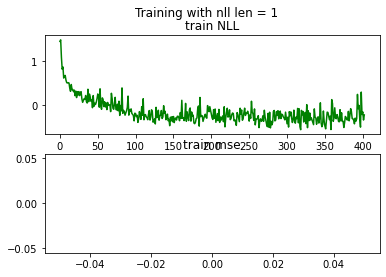

In [62]:
#nll 2nd time
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training with nll len = 1')
ax1.plot(losses, c='green')
ax1.set_title('train NLL')
ax2.plot(mses)
ax2.set_title('train mse')

plt.show()

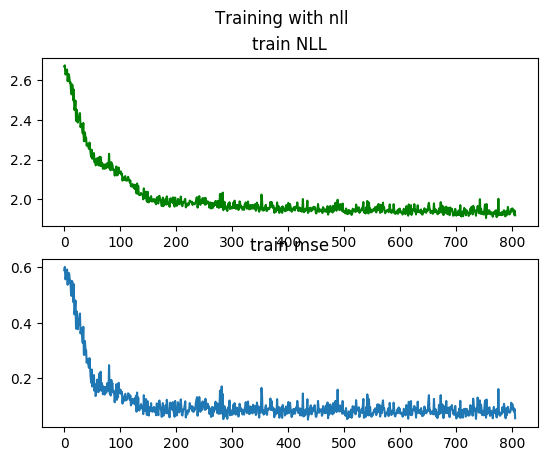

In [251]:
#mse
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training with nll len = 1')
ax1.plot(losses, c='green')
ax1.set_title('train NLL')
ax2.plot(mses)
ax2.set_title('train mse')

plt.show()

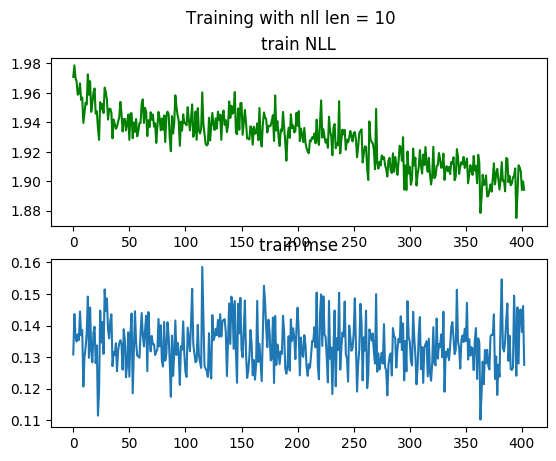

In [274]:
#mse
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training with nll len = 10')
ax1.plot(losses, c='green')
ax1.set_title('train NLL')
ax2.plot(mses)
ax2.set_title('train mse')

plt.show()

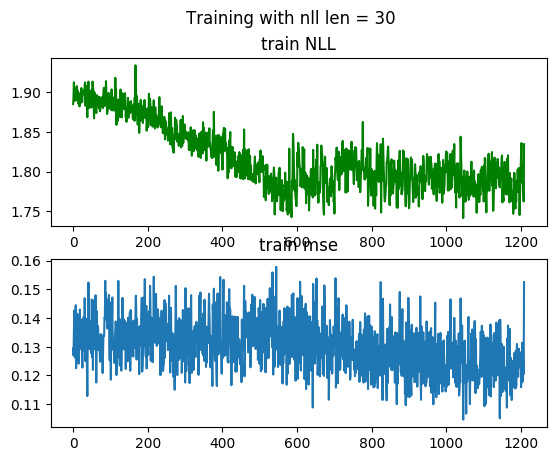

In [309]:
#mse
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training with nll len = 30')
ax1.plot(losses, c='green')
ax1.set_title('train NLL')
ax2.plot(mses)
ax2.set_title('train mse')

plt.show()

In [171]:
from eval_forecasting_helper import *
import eval_vis_helper as helper

In [161]:
curr_test_dataset = LSTMDataset(data_dict, args, "test")
curr_test_loader = torch.utils.data.DataLoader(
    curr_test_dataset,
    shuffle=False,
    batch_size=args.test_batch_size,
    collate_fn=model_utils.my_collate_fn,
)

In [238]:

def infer_absolute(
        args,
        test_loader: torch.utils.data.DataLoader,
        encoder: EncoderRNN,
        decoder: DecoderRNN,
        start_idx: int,
        forecasted_save_dir: str,
        model_utils: ModelUtils,
):
    """Infer function for non-map LSTM baselines and save the forecasted trajectories.

    Args:
        test_loader: DataLoader for the test set
        encoder: Encoder network instance
        decoder: Decoder network instance
        start_idx: start index for the current joblib batch
        forecasted_save_dir: Directory where forecasted trajectories are to be saved
        model_utils: ModelUtils instance

    """
    forecasted_trajectories = {}

    for i, (_input, target, helpers) in enumerate(test_loader):

        _input = _input.to(device)

        batch_helpers = list(zip(*helpers))

        helpers_dict = {}
        for k, v in config.LSTM_HELPER_DICT_IDX.items():
            helpers_dict[k] = batch_helpers[v]

        # Set to eval mode
        encoder.eval()
        decoder.eval()

        # Encoder
        batch_size = _input.shape[0]
        input_length = _input.shape[1]
        input_shape = _input.shape[2]

        # Initialize encoder hidden state
        encoder_hidden = model_utils.init_hidden(
            batch_size,
            encoder.module.hidden_size if use_cuda else encoder.hidden_size)

        # Encode observed trajectory
        for ei in range(input_length):
            encoder_input = _input[:, ei, :]
            encoder_hidden = encoder(encoder_input, encoder_hidden)
        
        # Initialize decoder input with last coordinate in encoder
        decoder_input = torch.cat([encoder_input[:, :2], 5*torch.ones(batch_size,2), torch.zeros(batch_size,1)], dim=1) # big 
        #print("decoder_input", decoder_input)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        decoder_outputs = torch.zeros(
            (batch_size, args.pred_len, 5)).to(device)

        # Decode hidden state in future trajectory
        for di in range(args.pred_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            #print("decoder_output", decoder_output)
            output = Gaussian2d(decoder_output)
            decoder_outputs[:, di, :] = output

            # Use own predictions as inputs at next step
            decoder_input = decoder_output

        # Get absolute trajectory
        abs_helpers = {}
        abs_helpers["REFERENCE"] = np.array(helpers_dict["DELTA_REFERENCE"])
        abs_helpers["TRANSLATION"] = np.array(helpers_dict["TRANSLATION"])
        abs_helpers["ROTATION"] = np.array(helpers_dict["ROTATION"])
        abs_inputs, abs_outputs = baseline_utils.get_abs_traj(
            _input.clone().cpu().numpy(),
            decoder_outputs.detach().clone().cpu().numpy(),
            args,
            abs_helpers,
        )

        for i in range(abs_outputs.shape[0]):
            seq_id = int(helpers_dict["SEQ_PATHS"][i])
            forecasted_trajectories[seq_id] = [abs_outputs[i]]

    with open(os.path.join(forecasted_save_dir, f"{start_idx}.pkl"),
              "wb") as f:
        pkl.dump(forecasted_trajectories, f)

In [181]:
def infer_helper(
        args,
        curr_data_dict: Dict[str, Any],
        start_idx: int,
        encoder: EncoderRNN,
        decoder: DecoderRNN,
        model_utils: ModelUtils,
        forecasted_save_dir: str,
):
    """Run inference on the current joblib batch.

    Args:
        curr_data_dict: Data dictionary for the current joblib batch
        start_idx: Start idx of the current joblib batch
        encoder: Encoder network instance
        decoder: Decoder network instance
        model_utils: ModelUtils instance
        forecasted_save_dir: Directory where forecasted trajectories are to be saved

    """
    curr_test_dataset = LSTMDataset(curr_data_dict, args, "test")
    curr_test_loader = torch.utils.data.DataLoader(
        curr_test_dataset,
        shuffle=False,
        batch_size=args.test_batch_size,
        collate_fn=model_utils.my_collate_fn,
    )

    if args.use_map:
        print(f"#### LSTM+map inference at index {start_idx} ####")
        infer_map(
            args,
            curr_test_loader,
            encoder,
            decoder,
            start_idx,
            forecasted_save_dir,
            model_utils,
        )

    else:
        print(f"#### LSTM+social inference at {start_idx} ####"
              ) if args.use_social else print(
                  f"#### LSTM inference at {start_idx} ####")
        infer_absolute(
            args,
            curr_test_loader,
            encoder,
            decoder,
            start_idx,
            forecasted_save_dir,
            model_utils,
        )



In [233]:
len(test_data_subsets)

395

In [256]:
temp_save_dir = tempfile.mkdtemp()

infer_helper(args, test_data_subsets[0], 0, encoder, decoder,
                                  model_utils, temp_save_dir)

#### LSTM inference at 0 ####


In [306]:
temp_save_dir = tempfile.mkdtemp()

test_size = data_dict["test_input"].shape[0]
print('test size', test_size)
test_data_subsets = baseline_utils.get_test_data_dict_subset(data_dict, args)

for i in  range(0, test_size, args.joblib_batch_size):
    infer_helper(args, test_data_subsets[i], i, encoder, decoder,
                                  model_utils, temp_save_dir)

    
traj_save_path = 'traj/lstm_nll_test.pkl'
baseline_utils.merge_saved_traj(temp_save_dir, traj_save_path) #args.traj_save_path
shutil.rmtree(temp_save_dir)
print(f"Forecasted Trajectories saved at {traj_save_path}")


test size 39472
#### LSTM inference at 0 ####
#### LSTM inference at 100 ####
#### LSTM inference at 200 ####
#### LSTM inference at 300 ####
#### LSTM inference at 400 ####
#### LSTM inference at 500 ####
#### LSTM inference at 600 ####
#### LSTM inference at 700 ####
#### LSTM inference at 800 ####
#### LSTM inference at 900 ####
#### LSTM inference at 1000 ####
#### LSTM inference at 1100 ####
#### LSTM inference at 1200 ####
#### LSTM inference at 1300 ####
#### LSTM inference at 1400 ####
#### LSTM inference at 1500 ####
#### LSTM inference at 1600 ####
#### LSTM inference at 1700 ####
#### LSTM inference at 1800 ####
#### LSTM inference at 1900 ####
#### LSTM inference at 2000 ####
#### LSTM inference at 2100 ####
#### LSTM inference at 2200 ####
#### LSTM inference at 2300 ####
#### LSTM inference at 2400 ####
#### LSTM inference at 2500 ####
#### LSTM inference at 2600 ####
#### LSTM inference at 2700 ####
#### LSTM inference at 2800 ####
#### LSTM inference at 2900 ####
#### L

#### LSTM inference at 24400 ####
#### LSTM inference at 24500 ####
#### LSTM inference at 24600 ####
#### LSTM inference at 24700 ####
#### LSTM inference at 24800 ####
#### LSTM inference at 24900 ####
#### LSTM inference at 25000 ####
#### LSTM inference at 25100 ####
#### LSTM inference at 25200 ####
#### LSTM inference at 25300 ####
#### LSTM inference at 25400 ####
#### LSTM inference at 25500 ####
#### LSTM inference at 25600 ####
#### LSTM inference at 25700 ####
#### LSTM inference at 25800 ####
#### LSTM inference at 25900 ####
#### LSTM inference at 26000 ####
#### LSTM inference at 26100 ####
#### LSTM inference at 26200 ####
#### LSTM inference at 26300 ####
#### LSTM inference at 26400 ####
#### LSTM inference at 26500 ####
#### LSTM inference at 26600 ####
#### LSTM inference at 26700 ####
#### LSTM inference at 26800 ####
#### LSTM inference at 26900 ####
#### LSTM inference at 27000 ####
#### LSTM inference at 27100 ####
#### LSTM inference at 27200 ####
#### LSTM infe

# new training using quantile

In [317]:
def train_epoch(train_loader, encoder, decode, encoder_optimizer, decoder_optimizer, rollout_len, criterion):
    start = time.time()

    losses = []
    mses = []
    mseloss = nn.MSELoss()

    for i, (_input, target, helpers) in enumerate(train_loader):
        _input = _input.to(device)
        target = target.to(device)

        # Set to train mode
        encoder.train()
        decoder.train()

        # Zero the gradients
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Encoder
        batch_size = _input.shape[0]
        input_length = _input.shape[1]
        output_length = target.shape[1]
        input_shape = _input.shape[2]

        # Initialize encoder hidden state
        encoder_hidden = model_utils.init_hidden(
            batch_size,
            encoder.module.hidden_size if use_cuda else encoder.hidden_size)

        # Initialize losses
        loss = 0
        mse = 0

        # Encode observed trajectory
        for ei in range(input_length):
            encoder_input = _input[:, ei, :]
            encoder_hidden = encoder(encoder_input, encoder_hidden)

        # Initialize decoder input with last coordinate in encoder
        decoder_input = torch.cat([encoder_input[:, :2], 5*torch.ones(batch_size,2), torch.zeros(batch_size,1)], dim=1) # big 
        #print("decoder_input", decoder_input)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        output_shape = list(target.shape)
        output_shape[-1] = 5
        decoder_outputs = torch.zeros(output_shape).to(device)

        # Decode hidden state in future trajectory
        for di in range(rollout_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            #print("decoder_output", decoder_output)
            output = Gaussian2d(decoder_output)
            decoder_outputs[:, di, :] = output

            #print(output)

            # Update loss
            loss += criterion(output[:, :5], target[:, di, :2])
            mse += mseloss(output[:, :2], target[:, di, :2]) 
            # Use own predictions as inputs at next step
            decoder_input = decoder_output

        # Get average loss for pred_len
        loss = loss / rollout_len
        mse = mse / rollout_len
        losses.append(loss.detach().numpy())
        mses.append(mse.detach().numpy())
        print("loss", loss)
        print("mse", mse)

        # Backpropagate
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

    end = time.time()
    
    return encoder, decoder, losses, mses


In [359]:
baseline_key = "none"
q_encoder = EncoderRNN(input_size=len(baseline_utils.BASELINE_INPUT_FEATURES[baseline_key]))
q_decoder = DecoderRNN(output_size=5)

q_encoder.to(device)
q_decoder.to(device)

q_encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=args.lr)
q_decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.lr)

start_epoch = 0
start_rollout_idx = 0

In [373]:
q_encoder, q_decoder, q_losses, q_mses = train_epoch(train_loader, q_encoder, q_decoder, 
                                             q_encoder_optimizer, q_decoder_optimizer, 
                                             1, quantile_loss_eval)

tensor([ 206740.9844,  518177.3125, 1143256.6250, 1364325.8750,  991892.5000,
        1305363.1250, 1111730.0000, 1147101.7500,  923527.9375,  959097.0625,
        1284417.8750,  852605.1875, 1087233.1250, 1241687.6250, 1312598.0000,
        1423894.6250, 1106229.6250,   66883.8750, 1208487.8750, 1520270.7500,
        1536590.6250, 1646587.0000,  755675.1250, 1226824.6250,  795842.9375,
         852993.5000,  774060.6250, 1289700.7500,  591855.1250, 1303334.1250,
         788659.7500,  995206.4375, 1436261.1250,  984037.6250,  570819.2500,
         808466.3750, 1279741.0000, 1032704.1875, 1097992.8750,  385209.8125,
        1151050.7500, 1225843.7500, 1125872.8750, 1021769.8750,  800105.1250,
         676951.4375,  590888.8125,  927469.8125,  975925.3125,  149420.2188,
         473778.9062, 1218000.7500, 1515432.6250,  332019.6562, 1323223.2500,
         621098.3125, 1117065.3750, 1267331.1250,  387635.1562,  875243.5000,
         888431.6250,  650380.4375, 1508536.0000, 1367734.1250, 

tensor([9.3288e+05, 1.1432e+06, 1.2519e+06, 9.6195e+05, 1.0557e+06, 1.0395e+06,
        1.3457e+06, 1.0421e+06, 6.4491e+05, 9.1420e+05, 1.0477e+06, 1.1279e+06,
        2.8023e+05, 6.1258e+05, 1.2188e+06, 1.0541e+06, 7.8934e+05, 6.5987e+05,
        8.0112e+05, 7.6312e+05, 7.7216e+05, 9.4225e+05, 8.9157e+05, 8.8337e+05,
        8.2124e+05, 1.0698e+06, 1.1280e+06, 1.0814e+06, 5.4585e+05, 8.9164e+05,
        4.3991e+05, 1.1031e+06, 1.1657e+06, 1.3018e+06, 9.0399e+05, 2.4791e+05,
        1.0962e+06, 8.8049e+05, 9.1533e+05, 1.0931e+06, 1.0904e+06, 9.3122e+05,
        8.5198e+05, 1.4660e+06, 1.2367e+06, 5.5146e+05, 1.2457e+06, 1.0376e+06,
        8.8018e+05, 1.1120e+06, 1.0542e+06, 8.6473e+05, 9.6728e+05, 1.2224e+06,
        1.3867e+06, 4.6382e+05, 1.1039e+06, 1.1869e+06, 9.0620e+05, 8.2955e+05,
        1.3450e+06, 1.1611e+06, 1.2316e+06, 3.1310e+04, 9.0481e+05, 9.4948e+05,
        1.3090e+06, 9.9688e+05, 1.1477e+06, 1.0497e+06, 1.0019e+06, 1.6448e+06,
        8.2086e+05, 3.3003e+04, 1.1227e+

tensor([ 606705.1875,  772000.2500, 1206974.8750, 1221877.7500,  683064.5625,
         601371.9375,  918115.3125, 1060638.0000, 1018079.7500,  106959.3516,
         462000.7812, 1059024.0000, 1871168.3750, 1169563.2500, 1058716.8750,
        1211333.2500,  936152.2500,  944699.3750,  734685.0000, 1179341.3750,
        1033916.9375, 1311011.0000,  972195.5625,  125760.0703,  710269.3125,
         970808.0000,  812153.3750, 1107792.1250, 1092313.6250,  866019.6250,
        1104991.5000,  849589.3125,  595258.6875,  268455.2188,  921310.7500,
         983141.6875,  923019.5625,  891074.6875, 1022211.6250, 1096010.2500,
         574961.1250, 1097039.0000, 1195046.1250,  960592.7500,  799421.6875,
         731411.8125, 1094984.6250,  828890.7500, 1171144.7500,  675569.3125,
        1184386.1250, 1074245.8750, 1104482.3750,  971511.0625,  792593.7500,
         992756.3125, 1039441.8750,  979903.1875,  877682.6250, 1090894.8750,
        1069935.2500,  725578.5000, 1083384.0000,  725234.2500, 

tensor([2.2016e+05, 1.1766e+06, 1.0487e+06, 8.8084e+05, 1.2921e+06, 1.0066e+06,
        8.4397e+05, 2.5666e+06, 9.5989e+05, 7.7216e+05, 6.8745e+05, 6.5990e+05,
        5.2932e+05, 1.3017e+06, 7.5795e+05, 4.8444e+04, 9.8657e+05, 1.0286e+06,
        1.0500e+06, 8.2655e+05, 7.4496e+05, 1.0424e+06, 1.0989e+06, 7.3408e+05,
        1.0002e+06, 3.9272e+05, 9.2760e+05, 9.6371e+05, 1.0280e+06, 1.1091e+06,
        9.7833e+05, 1.0499e+06, 9.9380e+05, 8.5128e+05, 5.6801e+05, 5.7841e+05,
        7.8349e+05, 1.0925e+06, 5.2726e+05, 6.7056e+05, 1.0615e+06, 9.0072e+05,
        8.2331e+05, 1.0832e+06, 1.0294e+06, 1.3745e+06, 2.2494e+05, 6.7028e+05,
        1.4025e+06, 9.4833e+05, 1.5916e+06, 9.4540e+05, 1.0319e+06, 4.7834e+05,
        1.0997e+06, 1.3237e+06, 7.7050e+05, 6.7505e+05, 1.2887e+06, 1.3324e+06,
        1.1223e+06, 8.8609e+05, 1.0027e+06, 9.7612e+05, 1.0781e+06, 1.2587e+06,
        9.9007e+05, 1.2108e+06, 1.2571e+06, 7.4533e+05, 1.1016e+06, 1.1804e+06,
        2.3023e+05, 6.8858e+05, 1.2023e+

tensor([ 594391.3750, 1089974.6250,  172131.8281,  970924.8750,  976291.4375,
        1453953.1250,  740875.2500,  825143.3750,  808797.9375,  982239.9375,
        1087040.5000,  918356.6875,  919116.3125, 1093001.8750, 1130370.8750,
         915215.9375,  933443.6250,  102606.9922,  989775.5625, 1155386.5000,
         887976.0625,  963165.8750, 1045604.5625, 1063205.8750, 1198085.1250,
         991867.6875, 1021473.2500,  606086.0000, 1162781.1250,  981406.8125,
         944375.6250, 1166777.7500,  933015.3750,  690086.3125, 1219007.2500,
         809924.4375, 1071891.0000,  982067.0000, 1021939.5000, 1094662.6250,
        1032093.6250, 1023390.6875, 1038859.2500, 1105961.2500, 1060266.7500,
         853791.4375, 1075188.8750,  931205.0625,  890287.7500, 1339329.8750,
         914178.6250, 1069413.3750,  762490.1250, 1054641.1250,  618398.5000,
        1158437.6250,  963180.6250, 1168841.5000,  852150.8125,  958289.7500,
         625769.5625, 1019194.2500, 1648597.3750,  980125.2500, 

tensor([1012024.2500,  755579.8125, 1077809.0000,   56172.8477, 1183048.1250,
        1307980.7500, 1017142.6250, 1005100.1875,  950683.1250, 1049628.3750,
         672965.8750, 1319595.6250,  593542.7500,  705211.0625, 1041761.4375,
        1243822.2500,  696829.0625,  674239.1875,  918537.6875,  964829.3750,
        1439228.3750,  371601.5000,  867389.0000, 1227784.8750,  254194.9219,
        1641505.3750, 1072054.1250,  910521.5000, 1023210.1875, 1012557.6250,
        1601722.7500,  802018.5000,  809246.0000, 1304223.3750,  851218.0625,
         726876.8125,  972711.3750, 1134995.0000,  910969.3125,  874282.8125,
         975259.1250,  976007.6250,  868479.6250, 1355415.7500, 1071113.5000,
         133661.9375, 1346056.8750,  305260.6875, 1084454.7500, 1077849.5000,
        1058193.1250, 1227907.7500,  869054.8750, 1019361.3125, 1134901.6250,
         801214.5625, 1104953.7500,  656669.5000, 1012407.8750,  390953.6250,
         834047.2500, 1197833.0000,  866331.3750,  822767.8125, 

tensor([1139194.0000, 1113999.8750, 1258114.2500,  471901.4062,  798369.8125,
         702275.8750,  979955.1250,  974630.4375,  750517.0000, 1039951.7500,
         987097.1875, 1120160.1250,  765449.4375, 1093770.8750, 1266091.8750,
         891305.4375,  849110.8750,  804238.0625, 1666372.0000,  957749.1875,
        1095708.5000,   91995.1797, 1466370.6250,  884242.3125, 1096246.5000,
         946677.6250,  347936.6562, 1140710.7500,  974330.6250, 1029536.5000,
        1047892.8125,  952456.0000, 1009341.5000,  844677.2500,  935306.7500,
         882024.7500,  604486.0625, 1080573.2500, 1044821.1250, 1153874.2500,
         719487.9375, 1669415.2500, 1380435.1250, 1211192.1250,  917647.9375,
        1077684.8750,  995212.5000, 1147559.0000, 1076916.0000, 1051634.1250,
        1338368.6250,  976916.8750,  645157.4375,  967787.3125, 1296529.8750,
         917882.3125,  908239.5625, 1236250.2500,  870202.8750,  906549.8750,
        1335993.8750,  736912.2500, 1134528.3750, 1082377.7500, 

tensor([1290983.6250, 1331504.3750,  912355.3750, 1247318.8750,  951487.8125,
         804602.6875, 1098976.3750,  948711.6875, 1021685.5000, 1184355.8750,
        1119169.5000, 1310558.2500, 1141402.6250, 1224189.5000, 1487951.1250,
         561977.0000, 1166944.1250,  455221.6875,  446563.8750,  981716.1250,
         949081.6250,  932684.3750,  422106.9062, 1754463.0000, 1069690.8750,
        1119192.8750, 1173279.1250,  615052.5000,  962559.1875,  711605.1250,
        1118747.0000, 1301697.3750, 1496235.5000, 1028732.3750, 1046975.8125,
        1061788.1250,  910541.1250,  753589.8750,  605133.0625,  739529.5625,
        1170034.8750,  441116.7188, 1003942.6875,  938127.2500, 1387691.2500,
         673943.0625,  994500.2500, 1250997.3750,  570354.0000, 1100739.6250,
         898604.3750,  291814.7812,  950015.7500,  777592.1250, 1076201.0000,
         954792.6250,  806351.3125, 1447983.8750, 1476947.1250, 1179096.3750,
        1034167.7500,  863411.8750,  179869.4844, 1441838.2500, 

tensor([1.1419e+06, 5.1748e+05, 1.2203e+06, 1.0945e+06, 1.0517e+06, 6.6176e+05,
        9.7993e+05, 1.0633e+06, 1.2598e+06, 2.2575e+06, 1.1077e+06, 1.2198e+06,
        5.7058e+05, 1.0830e+06, 1.0239e+06, 1.0051e+06, 6.4064e+05, 1.5229e+06,
        1.1734e+06, 1.4338e+06, 9.7294e+05, 5.3200e+05, 8.2114e+05, 9.4226e+05,
        1.0503e+06, 1.6346e+06, 4.2002e+05, 8.6736e+05, 1.1114e+06, 8.0701e+05,
        5.2340e+05, 8.6457e+05, 1.1100e+06, 1.3106e+06, 4.3926e+05, 5.8473e+05,
        8.4160e+05, 1.2170e+06, 1.1030e+06, 1.1857e+06, 1.3143e+06, 1.0522e+06,
        1.1704e+06, 1.1580e+06, 7.5583e+05, 1.1586e+06, 1.1279e+06, 1.2686e+06,
        1.1191e+06, 8.4142e+05, 1.5054e+06, 1.0941e+06, 9.0012e+05, 9.9078e+05,
        8.6876e+05, 1.1291e+06, 8.1894e+05, 1.1696e+06, 1.1782e+06, 1.2426e+06,
        1.2579e+06, 7.5440e+05, 1.2009e+06, 1.1186e+06, 4.5553e+05, 1.1842e+06,
        5.2331e+05, 1.0374e+06, 1.0712e+06, 9.8099e+05, 1.2122e+06, 9.8447e+05,
        1.1831e+06, 1.3843e+06, 7.2399e+

tensor([ 930082.3750,  695700.8125, 1195082.5000,  945066.1875, 1291930.0000,
         954470.8125,  919117.9375, 1072729.2500, 1101667.7500,  674971.9375,
         627079.7500, 1070448.6250,  782511.4375,  291654.3125,  342409.7812,
        1080950.2500, 1320829.6250, 1210122.6250,  780741.5000, 1519963.8750,
        1229596.5000, 1031678.0000, 1389134.6250,   57933.1992, 1035230.8125,
        1877940.8750,  925552.6250, 1236456.1250,  439371.1250,  776903.2500,
        1298133.3750, 1059207.1250, 1006861.8125, 1127639.2500, 1030905.0000,
         973809.6875, 1111199.8750,  463970.4062, 1547929.2500,  734362.9375,
         980703.1250, 1247731.8750, 1231096.5000,  794432.9375, 1080844.2500,
        1038212.6875,  769241.6875,  971177.5625, 1430355.3750, 1124260.5000,
        1189979.6250,  853871.1250, 1320336.8750,  853092.8125, 1022461.1250,
         967146.0625,  645068.6875,  912427.6875,  675277.5000,  619715.0000,
         627411.7500,  798816.9375, 1270198.2500,  875865.3125, 

tensor([ 808753.6875, 2700452.7500, 1204404.2500,  883821.6875, 1062112.5000,
        1002791.9375,  812379.0625,  718583.5000, 1215369.7500, 1244850.6250,
        1332784.3750, 1349301.2500, 1358846.0000,  806402.7500,  992022.3125,
        1122896.5000, 1001968.3750,  792883.0625, 1402796.2500, 1026374.1250,
        1279562.3750, 1236614.2500,  959526.5625,  717944.8750,   26141.8672,
         902474.9375,  799413.6875,  953254.0000, 1555498.1250, 1204437.6250,
        1493910.6250,  900607.2500,  856674.6875,  970890.1875,  861182.1875,
        1311866.1250,  792153.5000, 1178430.2500, 1581060.6250, 1292329.2500,
        1176269.1250, 1029053.1250, 1165316.1250,  886436.6250, 1247347.7500,
        1098370.1250, 1257449.1250, 1296786.2500, 1772735.3750,  803049.0625,
         954108.3750, 1112592.3750,  606802.5625,  904640.4375, 1518242.5000,
         964215.6875, 1008940.0625, 1040650.0000,  903771.4375,  966363.3125,
        1157870.1250,  746423.9375, 1173695.8750, 1074986.2500, 

tensor([2.2296e+06, 3.9830e+05, 3.2653e+05, 4.9815e+05, 8.9117e+05, 1.2950e+06,
        1.3307e+06, 1.1238e+06, 1.2658e+06, 1.1356e+06, 9.6629e+05, 1.2711e+06,
        1.4304e+06, 1.2043e+06, 8.4605e+05, 1.8948e+06, 1.3812e+06, 1.0997e+06,
        1.0013e+06, 9.8981e+05, 1.5311e+06, 4.5829e+05, 1.0508e+06, 1.2271e+06,
        1.1798e+06, 1.1006e+06, 8.5804e+05, 1.4170e+06, 1.3400e+06, 1.0299e+06,
        1.2223e+06, 1.3621e+06, 1.2862e+06, 1.2344e+06, 1.4132e+06, 9.1193e+05,
        1.0468e+06, 1.0394e+06, 1.0826e+06, 1.3450e+06, 1.0032e+06, 8.8666e+05,
        1.1698e+06, 1.2700e+06, 8.3962e+05, 1.1414e+06, 1.3897e+06, 1.2099e+06,
        1.1406e+06, 8.5037e+05, 1.3386e+06, 1.0043e+06, 1.0751e+06, 5.6974e+05,
        5.4385e+05, 1.0127e+06, 1.2494e+06, 1.0570e+06, 1.1421e+06, 1.2735e+06,
        1.0373e+06, 1.0963e+06, 1.3341e+06, 9.5241e+05, 1.1654e+06, 1.3087e+06,
        1.1125e+06, 1.0705e+06, 1.2380e+06, 9.4554e+05, 8.3967e+05, 1.2129e+06,
        1.0928e+06, 1.0750e+06, 1.4081e+

tensor([7.4546e+05, 1.9781e+06, 1.3038e+06, 1.0799e+06, 1.5369e+06, 1.0822e+06,
        1.8198e+06, 1.2158e+06, 1.4323e+06, 1.5731e+06, 1.1844e+06, 1.1237e+06,
        7.2774e+05, 1.0274e+06, 5.9372e+05, 8.9899e+05, 1.3201e+06, 1.7632e+02,
        1.4623e+06, 7.2861e+05, 1.5454e+06, 1.7289e+06, 1.3552e+06, 8.6601e+05,
        1.0671e+06, 1.1490e+06, 1.0278e+06, 1.0967e+06, 1.2331e+06, 1.1382e+06,
        9.5686e+05, 1.5865e+06, 9.2189e+05, 1.2956e+06, 7.5230e+05, 1.9758e+05,
        1.4074e+06, 1.2287e+06, 6.3441e+05, 1.7614e+06, 1.3146e+06, 1.3119e+06,
        1.6538e+06, 9.6355e+05, 1.3847e+06, 1.1266e+06, 8.9641e+05, 1.6690e+06,
        1.1018e+06, 1.0895e+06, 1.1409e+06, 6.8090e+05, 1.2777e+06, 1.3986e+06,
        9.7990e+05, 1.0579e+06, 1.0102e+06, 1.9942e+05, 1.2751e+06, 1.2956e+06,
        1.1682e+06, 1.1177e+06, 1.1170e+06, 1.2778e+06, 7.8995e+05, 1.0842e+06,
        1.2218e+06, 1.1596e+06, 1.4127e+06, 1.0786e+06, 4.5661e+05, 1.2729e+06,
        1.1377e+06, 8.8318e+05, 1.2349e+

tensor([1293841.8750,  251787.2812, 1203300.5000, 1549574.3750, 1175940.3750,
         443891.3438, 1132102.5000, 1949303.3750, 1230336.2500, 1140764.1250,
        1079005.0000,  860635.5625, 1337713.6250,  766546.2500, 1450311.7500,
         845733.8750, 1262047.7500, 1375668.0000,  929592.0000, 1122435.8750,
         920821.8125,  541068.4375,  908140.1875, 1087164.3750, 1467266.3750,
        1020819.9375, 1431512.6250, 1222586.5000, 1101817.8750,  106933.4609,
        1365840.5000, 1207445.6250, 1163472.0000, 1216752.6250, 1079837.6250,
        1243790.2500, 1259332.1250, 1230445.8750, 1325175.5000, 1494426.1250,
        1325950.8750, 1380615.6250, 1506304.3750,  948930.6875,  920840.5000,
         998647.1250,  399435.6250,  938282.7500, 1216525.3750, 1250178.7500,
        1268992.6250,  897914.5625, 1210198.1250, 1435545.5000, 1060565.5000,
        1165990.3750, 1028119.5000, 1378806.8750,  220148.2812, 1864701.7500,
        1449393.2500, 1179008.5000,  953861.3125, 1298207.1250, 

tensor([1.1209e+06, 6.7976e+05, 1.2531e+06, 1.1504e+06, 7.3600e+05, 9.2101e+05,
        9.6984e+05, 1.3592e+06, 1.3882e+06, 1.1702e+06, 1.5300e+06, 6.5023e+05,
        1.3026e+06, 2.0308e+06, 1.4537e+06, 1.1780e+06, 5.7066e+05, 1.3838e+06,
        9.8457e+05, 1.2203e+06, 1.1646e+06, 9.7507e+05, 1.2013e+06, 1.3120e+06,
        1.3369e+06, 1.0850e+06, 5.0922e+05, 8.9059e+05, 1.2138e+06, 1.5955e+06,
        1.0001e+06, 1.0252e+06, 9.4867e+05, 5.6481e+05, 1.3116e+06, 9.6394e+05,
        1.0119e+06, 1.0545e+06, 7.4855e+05, 1.7749e+06, 3.1750e+04, 1.6888e+06,
        9.9263e+05, 1.3772e+06, 1.2794e+06, 1.1481e+06, 1.0619e+06, 9.4706e+05,
        6.9619e+04, 1.3255e+06, 9.0681e+05, 1.6622e+06, 9.3398e+05, 1.6830e+06,
        5.9129e+05, 9.9899e+05, 1.2308e+06, 9.7497e+05, 1.2516e+06, 9.5102e+05,
        8.2050e+05, 9.6935e+05, 1.5392e+06, 2.5781e+05, 7.6217e+05, 9.0061e+05,
        1.5368e+06, 1.5002e+06, 8.3128e+05, 9.7693e+05, 2.0855e+06, 9.0609e+05,
        1.2809e+06, 1.2646e+06, 8.7140e+

tensor([1586811.2500, 1041090.8125,  862201.0625,  998764.5000,   53150.8555,
        1037322.0625,  789120.6250,  936673.0000, 1088992.8750,  830994.7500,
        1063089.3750,  767930.0625, 1377387.8750, 1262780.7500,  999895.1875,
        1265389.1250, 1729543.2500,  608079.4375, 1200102.1250,  705353.8125,
         828782.3125, 1346203.8750, 1409631.2500, 1331859.1250, 1295353.8750,
         648842.3750, 1872232.5000, 1409231.7500,  982567.0000, 1342360.7500,
        1503418.7500,  937884.5625, 1377407.6250, 1738361.3750,  916780.0625,
        1602786.8750, 1431099.3750, 1540242.1250, 1042761.8125,  931624.0000,
        1821153.5000, 1353624.5000,  402372.0312, 1402525.2500,  972976.7500,
        1221620.6250, 1165017.3750, 1148006.7500, 1122969.1250,  981487.8125,
         630439.7500,  939918.9375, 1210754.5000, 1251674.6250, 1294127.8750,
        1272584.8750,  660482.0625,  914222.1250, 1120029.1250, 1452212.6250,
         937225.3125,  285191.0938,  699907.3750, 1233689.2500, 

tensor([1058908.2500, 1134712.2500,  384066.9688,  849053.3125, 1387603.3750,
        1625965.1250, 1126994.2500, 1107864.1250,  862132.0625,  884088.3750,
        1063865.7500,  840469.3125, 1248698.6250, 1355231.2500,  994653.7500,
        1459673.5000,   56333.7031,  715728.3125, 1194707.6250,  881401.1250,
         432410.3125,  992214.8750,  902024.1250, 1290899.7500, 1789203.5000,
        1525208.8750, 1112658.8750,  894150.3125, 1038701.2500, 1530886.7500,
        1299054.0000, 1034524.3750, 1317417.6250,  796751.5000, 1277737.1250,
        1391812.2500,  806435.3125, 1590696.5000, 1075044.8750,  975232.5000,
        1173708.0000, 1216641.8750, 1265606.8750, 1473323.5000, 1284142.3750,
         966012.5625, 1175092.5000, 1140384.6250,  300213.6562, 1093489.2500,
         767854.7500, 1127400.8750, 1233355.0000, 1590847.0000,  832060.3750,
         929460.9375, 1324772.8750, 1182010.3750, 1328360.0000, 1123748.3750,
         832801.0000, 1262841.2500,  972838.4375,  929003.1250, 

tensor([1.1079e+06, 1.3281e+06, 1.0869e+06, 2.4022e+05, 5.7659e+05, 9.8772e+05,
        8.5703e+05, 5.8604e+05, 1.0135e+06, 4.7804e+05, 1.0820e+06, 6.0217e+05,
        1.1315e+06, 1.3348e+06, 7.8356e+05, 1.4561e+06, 8.3684e+05, 5.7222e+05,
        1.2151e+06, 9.9278e+05, 1.1753e+06, 1.3117e+06, 9.7905e+05, 1.1398e+06,
        1.3989e+06, 1.0842e+06, 8.4742e+05, 1.4863e+06, 9.7338e+05, 5.2676e+05,
        1.2842e+06, 1.3731e+06, 1.2271e+06, 3.6570e+05, 1.7849e+06, 1.5222e+06,
        1.3964e+06, 9.1165e+05, 1.3471e+06, 1.0636e+06, 1.5648e+06, 1.1193e+06,
        1.3055e+06, 1.5634e+06, 1.2125e+06, 6.5616e+05, 1.3356e+06, 1.3621e+06,
        1.8430e+06, 1.1738e+06, 9.8959e+05, 1.6304e+06, 6.1428e+05, 1.4320e+06,
        4.5577e+05, 9.7486e+05, 1.2146e+06, 4.5313e+05, 1.0107e+06, 5.1793e+05,
        1.2944e+06, 1.0656e+06, 1.2377e+06, 4.3117e+05, 1.0732e+06, 8.1851e+05,
        9.6760e+05, 7.3354e+05, 1.5279e+06, 9.2102e+05, 1.2024e+06, 1.0695e+06,
        1.3108e+06, 1.0663e+06, 1.0206e+

tensor([ 796095.7500,  998420.8750, 1126210.5000,  890233.6875, 1276889.1250,
        1047203.8125, 1260598.3750,  616027.3750, 1599802.6250,  554290.0000,
         784753.8750, 1059592.8750,  855094.6875, 1519881.1250, 1122825.1250,
        1258081.6250,  340028.2188,  669128.5000,  909957.0000, 1435799.1250,
         897815.1250, 1334374.0000,  950673.8750, 2236440.5000, 1225359.1250,
        1550257.6250,  675209.6875, 1248946.6250, 1197049.2500,  456129.3750,
        1090400.6250,  855398.6875,  409286.6562, 1223773.3750, 1335569.7500,
        1507500.8750, 1252739.7500, 1288134.2500,  976546.9375, 1276648.0000,
         383961.1875,  538712.6250, 1482772.5000,  448116.3125, 1420257.2500,
        1416775.2500, 1133249.5000, 1491253.0000, 1314439.1250, 1355225.8750,
        1573171.8750, 1442360.8750,  126129.5312, 1049892.5000, 1074072.2500,
        1213888.0000, 1252588.6250, 1801234.7500, 1739026.7500,  140892.8750,
        1198912.7500,  847207.2500,   21227.6758, 1039997.5000, 

tensor([1439283.5000,  799595.3125, 1402081.6250, 1217636.0000,  947544.6250,
        1254961.3750,  955981.3125, 1186163.8750,  735790.5625,  804973.0625,
         806179.4375, 1155631.7500, 1118772.5000, 1252092.0000, 1357673.5000,
         764320.3750,  931495.2500, 1589644.3750, 1355066.0000, 1083590.3750,
        1256505.2500, 1248832.3750, 1251272.7500, 1423840.1250, 1138117.8750,
        1365248.0000, 1174794.7500,  111924.1953,  943230.2500, 1184273.6250,
        1082020.8750, 1392614.8750, 1645321.3750, 1278803.2500, 1071467.0000,
        1872736.0000,  794985.0625,  735556.6875,  926708.0625,  849194.1250,
         858168.2500,  797774.6875,  356603.7812, 1019362.9375,  775870.1250,
        1165782.2500, 1500505.6250,  239604.7656, 1203589.7500, 1549380.1250,
         773571.1875, 1084268.8750, 1054845.8750, 1154022.8750, 1421606.6250,
        1207385.0000, 1154439.0000, 1293145.8750, 1407083.5000, 1299995.3750,
        1728142.1250, 1235982.6250, 1100816.1250,  936919.7500, 

tensor([5.8674e+00, 5.4246e+01, 1.4025e+02, 3.4356e+02, 1.1857e+01, 1.5000e+01,
        8.8156e+01, 7.2841e+01, 4.9097e+01, 4.4593e+01, 1.0994e+01, 5.6374e+01,
        2.0562e+01, 2.7477e+01, 5.2768e+00, 1.6939e+02, 1.4178e+00, 9.1187e+01,
        1.3434e+02, 1.5235e-01, 2.2528e+02, 1.4232e-01, 3.2804e+01, 4.5929e-01,
        3.9248e+01, 2.3426e+01, 1.0233e+03, 5.8707e+02, 1.9001e+01, 7.3956e-01,
        3.8680e+01, 8.9079e+00, 1.1660e+02, 2.0897e+01, 1.4674e+02, 3.9932e+00,
        4.4439e+00, 1.7167e+01, 5.5952e+00, 5.5597e+01, 2.3256e+00, 5.5851e+00,
        1.9742e+00, 3.5163e+01, 1.8029e+02, 3.8462e+02, 2.0188e+02, 2.1546e+01,
        1.8766e+02, 6.0104e+01, 2.0505e+01, 1.1623e+00, 3.7553e+00, 1.7182e-01,
        7.7148e+00, 6.6632e+00, 1.2233e+01, 2.5916e+01, 1.3175e+02, 2.5073e+02,
        2.7290e+01, 2.9842e+01, 7.9909e-01, 1.0716e+01, 8.3484e+00, 4.8947e+01,
        2.6627e+01, 7.9869e+01, 2.0607e+01, 1.2450e+02, 3.2376e+02, 5.9526e+02,
        1.6179e+00, 1.3141e+01, 6.9996e+

tensor([1265083.8750,  670539.8750,  258272.2344, 1295069.3750,  901456.3750,
        1258368.7500, 1423295.8750, 1529539.1250,  141121.5156, 1826516.7500,
          76783.9062, 1109935.5000,  881161.9375, 1479427.0000,  218135.7812,
        1248177.7500, 1490435.0000,  799320.1250, 1411828.5000,  635334.2500,
        1411411.3750,  991586.0625, 2174131.0000, 1479392.7500, 1159624.8750,
        1346372.2500, 1158834.2500, 1510358.7500, 1119991.7500, 1049121.2500,
        1016665.3750, 1197619.1250,  813207.4375, 1667705.6250, 2117476.5000,
        1175262.7500, 1012382.0000, 1305822.0000, 1590963.8750, 1307243.7500,
        1233523.1250, 1066564.7500,  466626.1250,  759613.8750, 1200086.7500,
        1467155.8750,  889844.6250, 1159380.3750,  145888.3125, 1302744.2500,
         976995.1250, 1242547.8750, 1157543.1250, 1082270.2500,  912968.9375,
        1354200.0000, 1438690.2500, 1379852.7500,  360290.9375,  559949.6875,
         784302.2500, 1238188.7500, 1038998.6875, 1206243.7500, 

tensor([3.4819e+00, 4.5730e+02, 3.0526e+01, 5.5954e+00, 7.7267e+01, 1.1337e+02,
        4.5530e+01, 3.8382e+01, 6.6795e+00, 4.1470e+02, 1.4347e+02, 6.1262e+02,
        1.9125e+02, 2.0840e+00, 4.4992e+01, 3.1280e+01, 2.5402e+02, 7.1390e+01,
        4.5864e+01, 1.4213e+01, 1.4595e+02, 1.4858e+00, 3.4744e+00, 7.8484e+00,
        8.8162e+01, 1.1450e+01, 3.1741e-01, 6.2166e+00, 2.2807e+02, 3.9289e+00,
        1.1431e+01, 2.8165e+01, 3.8393e+01, 2.5295e+02, 4.7199e+00, 6.1863e+00,
        8.6893e+02, 2.5368e+00, 3.2197e+01, 1.0895e+03, 9.8550e+00, 2.5316e+02,
        6.8751e+01, 8.2176e+01, 1.0467e+00, 3.0884e+02, 3.0747e+01, 2.1799e+01,
        1.3231e+01, 4.5409e+00, 1.0187e+02, 7.9796e-02, 1.0659e+01, 5.4024e+01,
        5.0770e+02, 2.3832e+02, 1.0180e+01, 4.2073e+01, 2.0590e+01, 7.0538e+00,
        6.3738e+01, 1.3624e+00, 2.0035e+02, 1.7069e+01, 2.3509e+01, 2.4778e-01,
        9.3906e+01, 1.8057e+01, 6.3424e+01, 6.8231e+01, 7.1168e+00, 6.3027e+01,
        9.7134e+00, 7.3096e+02, 2.2850e+

loss tensor(39.4225, grad_fn=<DivBackward0>)
mse tensor(0.0690, grad_fn=<DivBackward0>)
tensor([ 934139.8125,  836471.3125, 1028417.3750,  948110.7500, 1338581.5000,
        1476960.2500, 1110608.3750, 1523497.1250, 1017541.3125, 1394056.8750,
        1478024.7500, 1493397.8750,  966013.9375,  887455.0000, 1252160.5000,
        1652768.3750, 1043727.3750,  936612.0000, 1433897.2500,  877468.5625,
        1579781.5000, 1420123.2500, 1146341.7500,  987809.5000, 1236864.6250,
        1462376.5000, 1644205.1250, 1214990.2500,  737900.3125, 1319945.6250,
        1197283.0000,  627183.2500, 1117072.1250,  794285.9375,  608775.5625,
        1714816.1250, 1140724.0000,  966214.2500,  888213.6875, 1350872.3750,
         345143.3438,  789512.1250,  930083.1250, 2435866.0000,  827367.0000,
         788296.8750, 1195444.5000, 1209182.8750, 1517307.3750, 1197868.3750,
         362493.0625, 1224288.8750,  997977.6250, 1457710.3750,  332568.6562,
        1244731.2500,  869788.6875, 1251412.6250,  189

tensor([ 971525.3125,  566398.1875, 1299436.6250, 1459923.3750, 1096811.2500,
         877000.8125, 1366621.3750, 1240694.2500, 1300419.5000, 1224402.3750,
          44992.6133, 1134416.0000, 1279795.6250, 1214659.7500, 1121529.3750,
        1741307.7500, 1126036.3750, 1486215.3750, 1235535.6250,  108309.9844,
        1103478.2500,  954122.8750,  823985.6250,  997145.6250, 1375355.0000,
        1108344.3750, 1239096.2500, 1027419.3750, 1199289.0000, 1241906.2500,
         758477.2500, 1278392.5000,  968473.5000, 1686968.1250,  536077.4375,
        1104289.7500, 1474379.0000,  253002.4375,  870759.3125, 1019406.5625,
        1029318.8750, 1139223.3750, 1180766.2500, 1505834.2500, 1347157.3750,
         836260.6250, 1351414.3750,  893156.4375, 1627409.2500,  701501.2500,
        1231531.2500, 1138195.1250, 1591000.2500, 1210020.0000,  888612.1875,
        1010151.8125, 1232747.3750,  718945.2500, 1231472.5000,  611666.1250,
        1111290.3750, 1192715.3750,  621199.8750,  120682.3594, 

tensor([6.8381e+00, 6.4712e+02, 2.3140e+01, 2.7979e+00, 1.3060e+01, 7.9044e-01,
        1.6359e+01, 6.5537e+01, 2.0967e+01, 1.8744e+02, 4.0411e+01, 7.3039e+01,
        3.8773e+01, 3.1701e+01, 2.2130e+01, 1.5517e+01, 8.6007e+01, 4.5010e+01,
        3.7389e+00, 4.2683e+01, 1.8531e+02, 3.4665e+01, 1.1894e+01, 9.9514e+01,
        2.4592e+01, 2.9281e+01, 5.4160e+00, 1.2467e+01, 1.1863e+01, 2.9096e+01,
        2.8182e+01, 2.1727e+00, 3.9546e+01, 8.1737e+01, 3.3917e+01, 2.9772e+01,
        4.3406e+01, 4.2515e-01, 2.4854e+01, 1.6498e+02, 6.9791e+01, 1.6301e+00,
        2.1159e+01, 2.0396e+01, 5.8464e-01, 8.5364e+00, 3.9243e+00, 2.1856e+01,
        1.5454e+01, 1.1750e+01, 1.6132e+01, 6.4192e+01, 3.4694e+02, 3.3375e+01,
        2.4187e+01, 2.0634e+01, 1.1645e+01, 7.9104e-01, 3.0098e+00, 1.0671e+02,
        6.0250e-01, 2.5158e+00, 5.5851e+00, 2.3976e+01, 1.2756e+01, 3.5675e+02,
        7.2232e+00, 6.4154e+01, 9.6725e+00, 6.6343e+01, 1.7681e-01, 3.9420e+00,
        1.1046e+00, 6.6843e+01, 7.4809e+

tensor([1.2548e+06, 1.3419e+06, 1.2485e+06, 1.3217e+06, 7.0373e+05, 1.3589e+06,
        7.5732e+05, 1.2328e+06, 1.3787e+06, 1.3570e+06, 1.2781e+06, 8.5491e+05,
        8.9455e+05, 1.0645e+06, 2.0356e+06, 1.0057e+06, 1.1726e+06, 9.7483e+05,
        1.0177e+06, 1.1304e+06, 9.2859e+05, 7.1196e+05, 1.2452e+06, 9.6302e+05,
        1.2378e+06, 1.4566e+06, 1.0148e+06, 9.4524e+05, 1.4146e+06, 1.0415e+06,
        1.0665e+06, 1.2100e+06, 3.7956e+05, 1.3861e+06, 1.1253e+06, 1.0185e+06,
        1.0279e+06, 2.2652e+05, 1.4121e+06, 1.5564e+06, 1.1185e+06, 1.3113e+06,
        9.6688e+05, 1.1954e+06, 1.0081e+06, 1.3217e+06, 1.3016e+06, 1.6554e+06,
        1.3260e+06, 1.1005e+06, 9.9905e+05, 1.0166e+06, 6.7438e+05, 1.4877e+06,
        1.0213e+06, 1.2077e+06, 1.5013e+06, 1.0363e+06, 1.1437e+06, 1.2268e+06,
        4.4620e+05, 1.1095e+06, 9.3106e+05, 1.0632e+06, 1.0506e+06, 8.6624e+05,
        1.1579e+06, 1.0557e+06, 1.3337e+06, 6.7921e+05, 1.1874e+06, 1.4855e+06,
        1.3917e+06, 1.0476e+06, 1.2333e+

tensor([ 976566.6250, 1178940.5000,  830483.1250,  884192.5000, 1483258.3750,
         863946.5625,  865367.2500, 1415769.5000,  748653.9375,  400535.1562,
         311205.1250, 1207033.2500, 2058764.5000, 1478960.2500, 1152619.6250,
         967673.6250, 1493485.1250, 1088199.2500, 1253640.7500, 1221790.2500,
         604980.5000,  134995.9375, 1074594.6250,  800855.1250, 1397088.0000,
        1544738.5000, 1529429.1250, 1028562.4375, 1631681.6250,  288743.7188,
         345379.8438, 1185650.0000, 1617045.1250, 1331272.3750,  185152.3125,
        1062549.0000, 1312696.5000, 1104203.2500, 1590088.7500, 1204953.5000,
        1234295.2500, 1580456.1250,  954181.2500,  634041.3125, 1257757.5000,
        1401451.5000, 1377336.1250,  925716.1875, 1361324.6250, 1183396.8750,
         583239.1250,  117553.2734,  972533.8125, 1126261.1250, 1388047.7500,
        1244835.7500, 2131102.5000, 1246861.5000, 1427971.5000, 1293554.7500,
        1230614.8750, 1294389.5000, 1071663.7500, 1144686.8750, 

tensor([1305473.3750, 1324554.0000, 1078455.1250, 2054280.8750, 1322547.2500,
         623874.3750, 1221862.2500, 1093545.0000,  938302.2500,  282216.8438,
          54836.1172, 1370271.0000, 1172447.3750,  845101.8750, 1194795.7500,
        1020522.0625, 1046391.1875,  987001.2500, 1355166.3750,  969515.5625,
        1551992.7500, 1818386.7500,  711596.5625, 1420196.6250, 1379769.3750,
         684697.8750,  989321.2500,  545213.9375, 1194190.2500, 1243316.7500,
        1060682.3750, 1034807.8125,  620946.0625, 1648324.1250, 1329980.8750,
        1766778.6250, 1241436.7500, 1275478.8750, 1617452.2500,  898278.3125,
        1402517.6250, 1019784.8750, 1090460.0000, 1084063.0000, 1678066.6250,
        1273563.3750, 1107055.0000, 1253036.2500, 1186209.2500, 2136883.0000,
         119690.2734,  952396.8750, 1094313.3750,  462644.0000, 1768781.1250,
        1521881.6250, 1185460.3750, 1095840.1250, 1303430.1250, 1080381.8750,
         544929.2500, 1201789.5000, 1464511.1250,  974188.8125, 

tensor([ 778967.5625,  786361.2500, 1161651.0000, 1211836.7500,  419243.3750,
         396175.3750, 1322066.2500,  561555.8125, 1334415.6250,  432731.0000,
        1550964.3750, 1176864.2500, 1386194.2500, 1311369.8750, 1166451.2500,
        1148518.5000, 1189267.8750, 1061683.8750, 1222779.6250,  982255.5000,
         872484.6875, 1039522.6250, 1231789.1250, 1027774.7500, 1275873.6250,
        1176836.5000, 1159807.1250,  362887.7188,  234255.8125, 1161186.5000,
        1087574.0000, 1130543.0000, 1186198.7500, 1008795.0000, 1205782.0000,
        1326086.8750,  725487.5625,  969238.4375, 1439328.3750,  534758.6875,
        1281942.1250, 1236560.1250, 1141539.3750,  987843.3750, 1244432.3750,
        1187213.0000, 1201670.1250, 1369637.3750,  629406.0625, 1394035.0000,
        1141022.2500, 1047977.4375,  859268.2500, 1382995.7500, 1032620.1875,
        1518608.2500,  913007.8750,  383453.9375,  905790.6250, 1358971.8750,
        1136904.3750, 1388260.2500,   28618.6035,  892112.6250, 

tensor([9.3394e+00, 6.9593e+01, 1.1199e+01, 1.0171e+01, 2.1175e+01, 2.3265e+00,
        8.7168e+01, 4.3586e+00, 3.0641e+01, 3.7012e+01, 1.6614e+00, 2.8707e+01,
        1.0259e+01, 1.5106e+01, 4.4675e+01, 3.7332e-01, 2.2749e+01, 2.9281e+00,
        4.6235e-01, 7.0750e+00, 7.5980e+00, 2.1650e+01, 1.4144e+02, 2.8849e+02,
        2.1473e+02, 9.3221e+00, 1.8422e+02, 3.1301e+02, 1.0962e+01, 2.8355e+01,
        2.7340e+01, 3.8297e+00, 3.5633e+01, 5.0474e+00, 1.9039e+02, 1.6363e+00,
        2.2128e+00, 3.4862e+01, 2.0335e+01, 1.3954e+01, 9.1102e+01, 9.4893e+02,
        1.1260e+01, 1.8898e+01, 2.2414e+02, 7.4190e+00, 1.2151e+01, 2.6460e+00,
        3.1644e+00, 2.6664e+00, 4.3957e+01, 1.2442e+01, 1.1117e+01, 8.2268e+01,
        9.0140e+00, 2.2967e+01, 7.6000e+01, 1.8719e+01, 3.1680e+02, 9.7446e+01,
        2.3474e+01, 6.3687e+00, 5.5660e+01, 2.6056e+01, 1.7144e+02, 2.4139e+01,
        1.5107e+02, 8.7852e+00, 3.6891e+00, 3.5943e+01, 6.5959e+00, 1.5681e+01,
        2.0490e+01, 8.6960e+01, 3.1860e+

loss tensor(43.1166, grad_fn=<DivBackward0>)
mse tensor(0.0738, grad_fn=<DivBackward0>)
tensor([1136944.5000, 1215514.8750, 1169295.6250, 1399114.6250, 1894771.1250,
          90007.2500, 1501010.7500, 1187343.6250,  952194.4375, 1245109.6250,
        1037406.5000,  234900.9844,  670201.3125, 1201280.5000, 1071947.2500,
        1505525.6250,  979485.0625, 1195941.6250, 1294261.5000,  819495.5625,
        1372041.5000, 1417258.5000,  884840.5625, 2737287.7500, 1370338.7500,
         378461.4688, 1224479.2500, 1114250.6250, 1201701.7500,  571106.3125,
         746855.3125, 1048746.6250, 1111829.1250, 1128245.1250, 1486831.8750,
         811794.1250, 1393889.1250, 1702295.5000, 1297324.2500,  738421.0000,
        1340159.3750, 1375112.0000,  846503.3750, 1233277.5000,  865849.3125,
        1326075.7500, 1035137.5625, 1248933.2500,  532137.2500, 1173146.6250,
         826784.3750, 1346488.7500,  999607.2500, 1049428.6250, 1411197.6250,
        1530249.2500, 1333537.8750,  963884.0000, 1003

mse tensor(0.0657, grad_fn=<DivBackward0>)
tensor([ 882423.8750, 1418350.1250,  184380.4375, 1341004.5000, 1764803.8750,
         796610.1875,  307643.6562, 1058880.5000,  785080.0000,  990019.3125,
         914010.4375, 1322823.7500,  961687.5000,  954709.5000, 1117193.1250,
         929050.8750, 1266104.5000, 1441509.0000,  951338.7500, 1404156.7500,
        1220809.1250, 1233760.8750, 1227574.1250, 1162916.6250, 1505297.8750,
         249152.5938, 1395304.0000, 1414936.5000,  741231.6875,  678478.3125,
        1239133.0000, 1229811.2500, 1097558.7500, 1637118.2500,  897898.6875,
        1248471.0000,  898352.2500, 1436210.6250, 2134751.0000, 1227236.2500,
        1109213.2500,  666627.3125, 1318008.6250, 1050240.6250,  858733.0625,
        1532955.6250,   19297.0938, 1532066.5000, 1043333.0000, 1159252.6250,
        1235931.6250, 1163205.0000, 1101241.0000, 1013020.3125, 1508450.5000,
        1986205.1250,  921430.3750, 1582066.0000,  950396.5625, 1274152.0000,
         877175.8125,

tensor([1470745.1250,  119417.6641, 1283165.2500,  825223.1250, 1516216.7500,
        1067903.1250,  858684.9375, 1265529.2500, 1548366.5000,  737859.7500,
         926949.8125, 1358138.2500, 1421769.2500,  206849.0781,  800104.4375,
        1241211.3750, 1485882.7500,   44389.3672, 1157969.6250, 1345634.8750,
        1410867.2500,  661650.3125,  965231.8125, 1385865.5000, 1088145.1250,
        1119086.5000, 1096336.1250,  813016.1875, 1295156.8750, 1488174.6250,
         904852.0625, 1101125.1250, 1102866.5000,  961826.5000,  539233.6250,
        1335663.0000,  829474.5625,  921631.8125, 1344054.3750, 1676725.2500,
         874883.2500, 1184353.1250, 1092634.7500, 1053384.8750,  951245.1875,
         943890.1250,  813201.6250, 1372330.8750, 1259301.2500,  973768.7500,
        1223112.8750,  901268.6875, 1093162.7500,  375284.2500, 1860924.5000,
        1540552.6250,  692424.1875, 1227018.0000, 1081614.3750,  778355.1875,
        1542748.5000, 1477158.2500, 1144405.6250, 1154288.2500, 

loss tensor(44.2217, grad_fn=<DivBackward0>)
mse tensor(0.0911, grad_fn=<DivBackward0>)
tensor([1341934.2500,  324378.5312,  159693.1562,  941443.6875, 1156552.5000,
         760821.9375,  938283.8750, 1401729.7500, 1006435.6875, 1540268.6250,
         831200.6875, 1041893.6250, 1358508.3750, 1312203.2500, 1290276.1250,
        1476848.6250,  768550.1875,  956397.6250, 1071871.6250,  933318.8125,
        2207472.2500,  308578.1250, 1012265.6250, 1538437.6250, 1348898.8750,
        1172328.3750, 1130348.1250, 1256151.8750, 1149077.3750, 1056161.5000,
        1021795.8750,  819265.6875, 1638122.6250,  654327.4375,  452404.7500,
        1177624.3750,  498587.8125, 1229548.1250, 1189168.2500,  117033.1172,
         889960.2500, 1372919.5000, 1315128.7500,  733995.3125,  446704.6250,
        1050887.2500,  604845.7500, 1423696.3750,   60172.4922, 1257135.1250,
         858780.8750,  998593.7500, 1119876.7500,  772960.8750,  968454.4375,
        1125127.1250, 1411445.1250, 1274790.1250, 1205

tensor([ 515343.8438,  980220.0625, 1025581.4375,  699405.1250,  214256.7500,
         662140.8125,  992105.7500, 1024325.6250, 1202720.5000, 1142801.6250,
        1367652.6250, 1327773.1250,  296737.3125, 1286649.6250, 1422476.6250,
         801216.8750,  832190.2500,  939819.3125,  833471.8125, 2041785.1250,
        1103190.1250, 1068037.1250,  807529.5625, 1054214.6250,   26259.9961,
        1276730.8750,  767736.5000, 1332191.3750, 1019486.0625,  683378.8750,
        1215060.2500, 1044784.5000,  301267.4062, 1205205.2500,  998978.5625,
         918854.8125, 1011771.3125,  762141.3125,  352607.1562, 1351641.0000,
         644579.0000, 1037171.3750,   40774.7383,  302624.3438, 1133736.8750,
        1689002.3750, 1138343.7500, 1189019.7500, 1282066.6250, 1100498.0000,
         784608.4375,  840992.8750,  903899.0625, 1438218.7500,  713452.1875,
        1123127.2500, 1283649.5000,  119833.4141,  987589.3750, 1115427.1250,
        1312989.8750,    7196.0308, 1264243.8750, 1335920.5000, 

tensor([ 679751.6875,  764514.7500, 1520569.7500, 1387283.0000,  942003.1875,
        1371406.0000, 1335098.6250, 1071286.5000,  916505.5000, 1190184.8750,
        1320734.8750,  390593.4688, 1048748.8750, 1174993.6250,  757345.4375,
         685737.2500, 1505710.5000, 1342454.1250,  896880.1875,  398284.3125,
        1032854.8125,  876604.5625, 1273750.2500, 1621606.7500, 1935232.8750,
        1137063.3750,  629186.6875, 1178872.7500,   74707.1797, 1045459.4375,
        1246969.5000, 1115052.8750,  673432.4375, 1068143.8750, 1228996.2500,
        1107310.5000, 1606369.5000, 1474093.1250, 1173684.7500, 1103515.1250,
        1769221.7500, 1250604.6250, 1252456.1250, 1846841.8750,  917939.6250,
        1189246.8750, 1182455.6250,  835109.8125, 1253404.6250, 1426191.0000,
         994196.3750, 1334158.6250, 1177231.6250,  269072.4375, 1124709.6250,
         564754.9375,  930904.0625, 1302767.8750, 1116104.1250, 1221537.6250,
         750573.5000, 1135658.2500,  360185.9375, 1041220.9375, 

tensor([1001003.5000, 1036914.8750,  867374.1250, 1107418.2500, 1434167.3750,
        1072461.5000, 1073767.3750,  733259.5625, 1474051.3750,  189190.0469,
        1476272.1250,  950005.3750,  806857.5625, 1486219.7500,  419294.5625,
        1327963.3750, 1012528.5625, 1075506.6250,  798820.2500, 1343552.7500,
        1084663.7500, 1085561.1250,  800507.5000, 1876686.2500, 1240319.6250,
         581178.9375, 1302758.3750, 1342306.2500,  815066.0000,  585831.0625,
        1738307.5000,  755264.7500,  896027.0000,  876146.8750,  598366.5625,
        1024134.0625, 1073659.3750, 1090282.5000, 1117932.7500, 1792440.0000,
        1788329.0000,  950124.6250, 1315832.6250, 1333701.5000,   66383.7656,
        1194229.1250, 1011667.0625, 1219929.6250,  552253.4375, 1264393.5000,
         906262.3125, 1144756.8750, 1500519.5000, 1344923.5000, 2178903.2500,
        1222908.2500,  791699.8125, 1507511.2500, 1420033.2500, 1222124.1250,
        1496068.6250,  911810.0625, 1202125.1250, 1294422.5000, 

tensor([1670593.2500, 1108619.8750,  915537.2500,  899406.3125, 1261406.7500,
        1224643.6250, 1073479.0000, 1367056.5000,  936803.3750, 1204731.8750,
        1417489.0000, 1091769.8750, 1068198.6250, 1240403.1250, 1127006.1250,
        1270867.1250,  823298.8750,  978877.2500,  550968.5000,  940542.1250,
         456267.4688, 1054439.7500,  893786.6250, 1209988.6250, 1148901.3750,
        1066446.7500,  690186.0625, 1259159.8750, 1175817.7500, 1192637.0000,
        1269821.2500, 1113501.0000,  951607.3125, 1211179.5000, 1011525.9375,
         571674.3750, 1019895.0625,  181290.4844, 1295384.8750, 1308981.6250,
         970580.1250, 1238839.8750,  972154.1250, 1662388.1250,  777129.8125,
        1316772.8750, 1102811.7500, 1203280.5000,  613927.8750, 1426251.3750,
        1331865.0000, 1365454.1250, 1426688.8750,  652426.6250,  971959.0000,
        1453088.0000,  917069.7500, 1406291.1250, 1323397.5000,  996257.1875,
        1011021.8125,  555202.7500,  965663.8750, 1516982.0000, 

tensor([1127231.6250,  271575.6250,  685830.3125, 1541984.7500,  626520.5625,
        1391172.5000, 1103401.6250,  761348.6250, 1092874.3750, 1386178.5000,
        1239303.6250,  487767.9375,  453586.5000,  955313.1875,  820159.3750,
        1381823.0000, 1163689.0000, 1407659.6250, 1339841.2500,  742131.3125,
         976733.4375, 1273522.6250, 1244761.1250, 1240749.2500, 1219995.7500,
         925303.0625, 1307860.3750, 1039258.3125,  976019.1250, 1493696.1250,
        1211518.3750, 1112754.3750, 1264879.8750,  645486.0625,  170836.2188,
         376847.1875,  906819.2500, 1082836.2500, 1209725.8750, 1016279.6875,
        1244686.3750, 1221294.1250, 1120183.8750,  633524.5625, 1161480.7500,
        1929520.3750,  774880.1875, 1524727.1250,  600360.3750, 1173430.0000,
        1134732.1250,  771258.8750, 1211184.6250,  451462.5312, 1346942.6250,
        1344735.1250, 1058151.6250, 1172405.7500, 1000169.1875, 1064768.5000,
         936934.6875,  469172.9688, 1087643.5000, 1356494.7500, 

tensor([5.1104e-01, 1.8294e+00, 6.3700e+01, 6.5027e+00, 1.5379e+01, 9.6753e+01,
        8.4646e+01, 6.5312e+01, 4.6638e+02, 3.3727e+00, 1.9502e+01, 2.8505e+01,
        1.2033e+01, 1.1664e+03, 7.7235e+00, 5.7473e+01, 1.9852e+00, 3.6083e+00,
        3.1957e+02, 9.6812e+01, 3.0909e+00, 5.7094e+01, 1.0559e+01, 2.8977e+01,
        3.9799e+00, 1.6497e+02, 1.2621e+02, 4.5920e+01, 7.0127e+00, 2.7952e+01,
        5.7218e+00, 5.3223e+01, 4.8227e+02, 3.5436e+02, 1.1695e+01, 6.7624e+00,
        6.3578e+00, 2.5038e-01, 2.0824e+00, 6.3672e+01, 4.2910e+01, 1.5274e+00,
        2.1414e+01, 1.2492e+01, 3.9672e+02, 1.6639e+01, 2.2535e+01, 1.1808e+02,
        5.1701e+01, 1.6573e+02, 1.4115e+00, 3.9143e+01, 1.4143e+02, 2.2864e+01,
        3.3789e+02, 3.6395e+01, 8.1524e+01, 1.4398e+01, 1.0200e+01, 6.9185e+00,
        1.9379e+02, 2.4672e+01, 6.8329e-01, 1.2663e+01, 2.1765e+02, 2.5231e+01,
        2.1532e+01, 1.8471e+01, 5.5389e+00, 1.3267e+01, 5.8921e+00, 9.9373e+01,
        1.6020e+01, 1.3760e+01, 5.0580e+

tensor([4.6487e+01, 3.9827e+00, 3.8632e-01, 3.1855e+01, 1.1450e+02, 1.7112e+01,
        1.2412e+01, 2.8719e+01, 1.3839e+01, 1.8227e+01, 2.1195e+00, 5.3024e+01,
        4.9293e+02, 5.9759e+01, 6.6884e+00, 2.1550e+01, 5.1550e+00, 2.2475e+01,
        5.5734e+01, 1.3590e+01, 3.8169e+01, 3.1990e+02, 2.1154e-01, 1.4630e+01,
        1.5614e+00, 7.9823e+00, 4.4846e+00, 1.9815e+01, 2.7312e+01, 1.3527e+01,
        6.1393e+00, 1.7185e+00, 1.1643e+01, 9.6269e+00, 4.8217e+00, 3.4338e+02,
        1.9730e+01, 1.2098e+02, 4.7630e+02, 6.4277e+01, 1.7564e+01, 4.3657e+01,
        1.1807e+01, 2.6510e+01, 1.6134e+01, 1.6529e+01, 1.4388e+01, 1.1960e+01,
        1.5635e+02, 7.7137e+01, 7.2083e+00, 3.9821e+00, 4.0216e+00, 5.7767e+01,
        2.6984e+01, 1.4003e+01, 6.6999e+02, 9.9958e+00, 2.6336e+00, 2.1292e+01,
        9.1185e-01, 3.2521e+00, 1.1056e+01, 3.2171e+02, 3.4345e+01, 3.7134e-01,
        1.7361e+02, 6.3897e+01, 1.1562e+00, 1.0810e+00, 1.4465e+01, 5.1336e+01,
        7.3331e-01, 4.4352e-02, 4.0098e+

tensor([ 246510.2969, 1022692.4375,  469418.8438, 1142045.3750, 1041027.7500,
         311352.7188,  962402.3750, 2200640.0000, 1251577.1250, 1304490.5000,
         823422.7500, 1543428.6250, 1144537.1250, 1279001.3750,  979674.6250,
        1304021.6250, 1025046.8125,  883161.6250, 1265229.6250, 1309988.1250,
        1151419.8750,  315658.0625, 1089544.3750, 1159303.6250,  514207.2500,
         388583.0000, 1144543.1250, 1804914.3750,  346470.5000, 1168289.6250,
         238417.2812, 1179046.6250,  981683.0625, 1232213.5000,  428272.0625,
        1043727.1250, 1061849.7500,  637864.7500, 1258540.1250, 1330683.7500,
         954529.8750, 1016158.3125, 1551106.1250, 1048978.1250,  647240.7500,
         878549.8750,  962224.3750,  967019.8750, 1155247.7500,  702415.3750,
         622375.6875, 1105633.3750,  523168.5312,  160272.2188, 1242343.6250,
         914733.0625, 1012556.8125,  936873.5625,  578285.5625, 1267012.1250,
         620189.6875, 1039324.7500, 1057217.6250,  868256.0000, 

tensor([2.4841e+01, 4.8945e+01, 5.1157e+01, 4.0977e+01, 1.3075e+00, 1.8494e+01,
        4.0108e+02, 6.6641e+00, 7.0932e+01, 5.4676e+01, 7.4726e+01, 4.6335e+00,
        6.3525e+01, 3.3177e+01, 8.3672e+00, 1.5770e+03, 3.1544e+01, 2.3765e+02,
        7.6490e+01, 3.8799e+01, 7.4292e+00, 1.1853e+01, 1.1399e+01, 1.2992e+02,
        5.0503e+00, 1.1479e+01, 8.8043e-01, 2.1832e+00, 3.6125e+01, 9.3676e+01,
        3.7840e+00, 5.7442e+00, 9.8664e+00, 2.6095e+01, 1.4891e+01, 1.5082e+03,
        2.3450e+02, 2.4598e+02, 1.3118e+00, 1.3754e+01, 2.8197e+01, 2.0219e+02,
        1.2171e+01, 1.2853e+01, 1.0882e+01, 1.9312e+02, 7.9592e+01, 1.1278e+02,
        6.7261e+00, 5.0168e+00, 2.6622e+02, 2.4928e+02, 5.1423e+00, 4.0929e+00,
        1.3056e+02, 9.1541e+00, 9.3789e+01, 2.1326e+02, 1.3602e+01, 6.3858e+01,
        8.5479e-01, 1.4214e+01, 3.6777e+01, 3.2138e+02, 5.7850e+01, 6.4837e+01,
        5.1307e+00, 3.7384e+00, 2.5613e+02, 1.6083e-01, 5.5519e+00, 2.2017e+01,
        2.4977e+00, 1.0521e+02, 3.0181e+

loss tensor(54.1664, grad_fn=<DivBackward0>)
mse tensor(0.0971, grad_fn=<DivBackward0>)
tensor([ 976229.0625, 1511504.3750,  895552.8125, 1209448.7500,  955983.9375,
         867862.2500,  997971.7500,  941607.5625,  943665.5000,  992661.0000,
        2027488.1250,  813439.1250,  973960.7500,  898056.7500, 1417726.8750,
        1129496.3750, 1307702.5000, 1046034.9375,  839722.3750, 1238981.0000,
        1194676.5000, 1018023.5625, 2190875.7500,  546393.2500, 1233419.6250,
         875708.4375, 1125262.5000, 1418717.5000, 1102296.8750,  521352.4688,
        1426204.3750,  669396.8750, 1558822.5000, 1277548.2500,  664982.9375,
         909041.1250,  571004.9375,  691680.0000, 1574152.7500,  585255.5000,
        1060434.5000, 1334764.7500, 1340083.3750, 1303996.0000, 1010917.6875,
         760830.4375,  780850.2500, 1298108.6250, 1120851.5000, 1276113.7500,
         721276.0625, 1269867.0000, 1124748.1250, 1274459.0000, 1171763.1250,
        1119402.8750,  965679.5625, 1228550.0000,  406

loss tensor(59.8731, grad_fn=<DivBackward0>)
mse tensor(0.0827, grad_fn=<DivBackward0>)
tensor([1.3366e+06, 1.2159e+06, 1.3776e+06, 1.3894e+06, 1.0182e+06, 1.2842e+06,
        1.2563e+06, 1.7821e+06, 1.1158e+06, 9.9585e+05, 1.2225e+06, 1.2271e+06,
        5.3196e+05, 1.3584e+06, 1.0096e+06, 1.1102e+06, 1.1079e+06, 3.5222e+05,
        8.0088e+05, 9.2877e+05, 9.1035e+05, 1.2056e+06, 1.4226e+06, 1.0166e+06,
        1.2733e+06, 1.6600e+06, 1.0847e+06, 1.1447e+06, 1.1285e+06, 1.1176e+06,
        8.9187e+05, 7.0416e+05, 1.2451e+06, 1.1787e+06, 9.4670e+05, 1.2488e+06,
        9.7921e+05, 1.6406e+06, 1.2703e+06, 1.2743e+06, 1.0241e+06, 9.9659e+05,
        1.0576e+06, 1.8552e+06, 9.2948e+05, 1.0758e+06, 6.0928e+05, 7.2977e+05,
        1.0139e+06, 8.9298e+05, 1.0671e+06, 1.0761e+06, 8.4368e+05, 1.8689e+06,
        1.3317e+06, 1.4928e+06, 9.0694e+05, 1.0027e+06, 7.6642e+05, 1.3715e+06,
        9.7608e+05, 9.4141e+05, 1.2500e+06, 9.8803e+05, 1.1933e+06, 1.1365e+06,
        1.3102e+06, 1.9593e+06, 

tensor([1266538.1250,  517629.7812,  941533.6875,  863790.1250, 1540120.6250,
         685224.1250, 1216316.6250, 1282574.5000, 2935553.2500, 1130678.8750,
         504349.5938, 1383603.8750, 1008500.1875, 1172728.8750,  275796.6250,
        1182554.6250, 1307590.6250, 1107340.2500, 1517514.1250, 1046977.5625,
         866621.3125, 1002909.1875,  935049.6250, 1158212.3750, 1346668.7500,
        1200543.3750, 1501970.3750,  828199.8125, 1146404.1250, 1642009.2500,
        1408243.7500,  947157.1250,  750913.8125, 1237011.8750, 1472091.6250,
        1338418.6250,  859829.3750,  622100.1250, 1347688.5000,  570947.0000,
        1179726.6250, 1023303.4375,  361485.3438,  547494.1875, 1162082.0000,
        1143925.0000, 1384827.6250,  976751.0000, 1434199.2500,  908599.1875,
         850435.5625, 1120658.7500,  757089.6875, 2161668.0000, 1905004.0000,
        1235441.8750, 1044396.0000, 1025929.5000, 1113737.0000, 1499299.7500,
         807047.1875, 1172205.2500, 1053769.5000, 1487111.2500, 

tensor([3.2452e+01, 1.3042e+00, 4.9740e+01, 1.0829e+02, 1.7611e+01, 5.7011e+00,
        1.7376e+00, 1.8904e+01, 9.3147e+01, 5.2141e+00, 1.2785e+00, 4.0263e+01,
        2.5544e+00, 2.4999e+01, 1.1377e+00, 6.5443e-01, 4.6070e+01, 3.3653e+01,
        2.6926e+00, 1.9135e+02, 1.2611e+02, 8.0420e+00, 4.9126e+03, 2.0981e+00,
        8.2387e+00, 3.0672e+01, 7.4885e-02, 8.9827e+01, 2.1935e+02, 3.7150e+00,
        1.7522e+01, 4.1292e+01, 1.0992e+02, 4.5566e+00, 5.1567e+00, 5.7154e+00,
        2.4511e+02, 4.5315e+00, 9.5491e+00, 5.1129e+01, 1.1230e+01, 1.0946e+03,
        4.2184e+01, 9.4057e-01, 3.8835e+01, 1.4394e+01, 3.8250e+01, 1.8555e+01,
        9.7415e+00, 9.9525e+01, 2.3808e+01, 2.0861e+01, 1.2805e+02, 5.4042e+00,
        2.1619e+01, 1.0777e+00, 1.9460e+02, 3.7053e+01, 1.6462e+01, 2.5547e+01,
        2.0976e+01, 1.0493e+01, 6.5608e+01, 7.9199e+01, 5.3038e+01, 5.2231e+00,
        3.7719e+02, 3.0300e+01, 1.0709e+02, 2.0129e+01, 3.3251e+01, 1.4645e+01,
        3.1574e+01, 6.3897e+01, 9.5564e+

tensor([ 761675.2500, 1595049.8750, 1159029.8750, 1175341.5000,  652641.5000,
         975852.8125,  735709.5625, 1549317.2500, 1107760.8750, 1062907.8750,
        1488283.3750, 1161742.1250, 1891089.1250, 1334665.0000, 1237724.7500,
        1083822.1250, 1423976.5000, 1230951.8750, 1328609.0000, 1226000.0000,
        1056494.0000,  428951.4375, 1219598.8750,  888245.2500, 1453191.5000,
        1144173.5000, 1734044.2500, 1176057.5000,  493169.1562,  870897.3125,
        1239432.1250, 1004324.3125,  973348.7500, 1052219.8750, 1011452.3125,
        1379546.3750,  963327.0625, 1317766.2500,  934960.8750, 1201818.1250,
        1222391.0000,  894424.4375,  829064.0000, 1491039.7500, 1197185.1250,
        1056944.6250,  994220.5625,  533774.6250, 1351086.7500, 1035779.3750,
        1128036.6250, 1335993.7500, 1141891.7500, 1506904.8750, 1457281.5000,
         329737.5312,  529273.5000,  371813.5312,  922741.9375, 1267523.0000,
         916314.3125, 1384491.5000, 1320038.7500,  500463.5312, 

tensor([1311496.2500, 1028483.8750, 1312901.8750,  544113.5625,  206158.2500,
         868245.6250, 1124098.0000, 1081136.8750, 1017739.0000,  894030.8125,
        1160714.2500, 1879681.7500, 1465200.8750, 1041388.8750, 1075172.7500,
         776108.8750,  841733.1875,  976761.9375, 1066392.5000,  731977.8750,
        1024750.8125, 1688331.1250,  366813.1250, 1221943.7500, 1152328.1250,
         549753.8125, 1135832.8750, 1003484.1875, 1086125.6250, 1100929.8750,
        1169233.8750, 1385346.3750, 1288147.5000, 1746994.3750, 1138049.3750,
         108987.6328,  847857.6250, 1306384.2500, 1461945.0000,  890437.1875,
        1080354.6250,  771205.3750,  950458.6875,   32779.5508,  662648.4375,
        1346107.1250,  924145.2500, 1186707.2500, 1187688.8750,  844260.1875,
        1356960.5000,  881684.9375, 1206818.5000, 1244810.3750, 1312115.0000,
        1553283.5000,  818393.5000, 1205715.6250, 1170894.1250, 1258159.2500,
        1137528.5000,  983087.1875,  106392.3281,  858907.6250, 

tensor([1.4714e+02, 1.3425e+02, 8.3806e-01, 3.6018e+01, 9.2877e+01, 5.6684e-01,
        1.2348e+02, 1.9208e+01, 8.5389e+00, 1.7781e+00, 9.0805e+01, 2.7982e+01,
        3.9201e+00, 9.7406e+01, 3.7448e+01, 3.7986e+01, 5.0423e+01, 4.9469e+00,
        9.8606e+00, 6.8822e+00, 1.6083e+01, 1.7333e+00, 3.7482e+00, 1.1607e+01,
        2.5242e+00, 3.3156e+01, 3.7810e+00, 3.1023e+00, 6.2647e+01, 9.9229e+01,
        4.1135e+01, 1.2915e+02, 2.1552e-01, 2.1951e+01, 4.5056e+01, 1.6577e+00,
        1.9020e+01, 6.9475e+00, 2.8091e-02, 1.5946e+01, 3.4826e+01, 3.0600e-01,
        5.7458e+01, 6.6774e+00, 2.3824e+01, 1.3378e+02, 2.4159e+01, 7.8778e+01,
        9.8363e+00, 6.5777e+01, 1.5206e-01, 3.8653e+00, 2.5300e+02, 2.1879e+01,
        2.7278e+02, 3.4966e+01, 5.6315e+01, 1.8542e+01, 1.5631e+01, 1.0134e+01,
        6.4537e+01, 4.7784e+00, 1.6979e+02, 3.3626e+01, 1.0827e+01, 2.7165e+00,
        3.1743e+00, 1.9428e+01, 2.8991e+01, 4.4127e+01, 4.7819e+01, 3.2147e+00,
        6.7434e-01, 1.0591e+00, 1.9901e+

tensor([1001997.1250,  962308.1250,  808481.8125, 1062620.2500, 1051989.5000,
        1639961.8750, 1096978.1250, 1201759.8750,  969144.6875,  871943.0000,
        1313469.5000,  998946.4375, 1233675.1250, 1396668.3750, 1337173.6250,
         303915.3750, 1451246.7500,  924059.8125,  267014.8438, 1248817.2500,
        1234854.6250, 1261889.0000,  551152.6875,  974971.5625, 1121166.8750,
         555857.4375, 1452804.3750, 1419467.0000, 1187849.7500,  943488.5625,
        1040970.0625,  717386.1250, 1079987.0000, 1142324.8750, 1463732.6250,
         812598.2500,  616308.8750, 1318792.6250,  596686.3125,  472922.1250,
        1064901.3750,  927451.2500, 1187044.6250,  981832.5000,   19994.0488,
        1271911.8750, 1318118.5000, 1511381.7500, 1100617.5000, 1697412.1250,
         753772.5000,  624218.1250,  948677.8750,  965444.4375, 1280398.7500,
         616021.0625,  514173.8125, 1070816.8750,  696634.8750,  763219.6250,
        1633549.6250,  875143.0000, 1596841.2500,  950317.1875, 

tensor([7.8886e+00, 4.1660e+00, 6.2818e+01, 5.9742e-01, 7.2491e+00, 1.3723e+02,
        4.7783e+00, 1.7307e+02, 4.3855e+01, 5.2561e+01, 6.6243e+00, 2.7719e+01,
        1.8891e+01, 1.9126e-01, 1.0455e+01, 4.1475e+01, 6.4082e+02, 1.9363e+00,
        2.2483e+01, 7.8174e+00, 1.0341e-01, 5.4346e+02, 8.4892e+02, 1.8726e+01,
        2.5907e+01, 5.4306e+02, 2.3645e+02, 1.2304e+00, 9.8236e+01, 9.1536e+00,
        9.4571e+00, 1.1643e+01, 2.6791e+02, 1.6519e+01, 3.5423e+00, 2.0526e+02,
        1.0149e+01, 1.1357e+01, 1.7860e+01, 1.9586e+01, 3.7446e+00, 1.0918e+02,
        6.7370e+01, 1.9264e+02, 1.7785e+01, 2.8673e+02, 9.1973e+01, 1.7410e+01,
        1.4309e+01, 8.9322e+01, 1.8346e+01, 3.0462e+02, 1.6371e+02, 1.5402e+01,
        1.1233e+03, 3.4899e+02, 1.7950e+02, 2.7850e+01, 4.1966e+01, 3.5678e+01,
        3.8878e+01, 8.1528e+00, 1.6438e+02, 1.5305e+01, 7.3503e+00, 8.5391e+01,
        4.5393e+01, 7.2457e+01, 2.6806e+02, 2.5232e-01, 9.4503e-02, 5.9179e+01,
        1.0316e+00, 6.0294e+00, 5.9431e+

tensor([1157590.5000, 1501213.8750,  850690.0000, 1128939.5000,  880506.6875,
        1176439.0000,  900332.2500,  774838.1875,  916639.3125,   92166.6562,
        1199720.6250, 1065597.6250, 1146870.2500, 1260820.7500, 1438293.1250,
         315738.3438,  720184.1250,  953730.8750,  920655.1250,  614998.5000,
         481364.6250, 1151763.3750,  151073.6250,  986794.1875, 1021759.8125,
         491344.3750, 1641208.1250, 1464146.6250,  402718.4375, 1501231.8750,
        1057685.7500, 1290508.1250,  283588.4688, 1095090.2500, 1061904.6250,
         931190.8750,  864874.5000,  851758.7500, 1112670.1250,  889827.7500,
         916359.2500, 1213296.7500, 1402926.0000, 1243602.1250,  974755.2500,
        1039516.8125, 1047823.1875, 1301925.7500,  994217.6250,  170632.5156,
         907363.2500, 1095901.2500,  844622.6875, 1099614.6250, 1188463.3750,
        1026273.8750, 1060967.2500,  930734.4375, 1150852.1250,  799235.4375,
        1187614.1250, 1259775.6250, 1181411.8750,  312914.5938, 

tensor([1254143.8750,  927220.8750, 1321819.8750,  548166.6875,  443548.1562,
         723646.1875, 1040132.3125,  887284.5000, 1024233.8750,  705312.1250,
         483009.0938, 1116125.1250, 1047326.6250,  401458.3125, 1138205.7500,
         689432.5000, 1413916.1250,  882999.5000,  956529.3750, 1093343.1250,
         793817.6875, 1489000.0000,  973783.5000, 1102870.3750,  710486.9375,
        1627347.3750,  599823.5625, 1229462.3750,  624332.5000, 1278542.2500,
         731095.4375,  439577.8750, 1204458.2500, 1064953.1250, 1064760.0000,
        1076491.5000,  689173.6250, 1246411.2500, 1029113.4375,  236778.6094,
        1323627.1250,  865189.5625,  130765.9531, 1238422.2500, 1120041.6250,
        1169538.3750, 1198941.1250,  816705.8750, 1274943.8750,  137117.0312,
         688248.9375,  947008.2500,  828425.0000, 1768978.2500, 1107415.1250,
        1013012.0625,  709944.2500, 1028755.5000, 1195005.6250,  861919.8750,
        1135272.5000,  892033.1875, 1140332.3750,  745885.0000, 

tensor([ 864851.5000,  708566.4375, 1379755.6250,  937388.0000,  817004.3125,
        1356342.2500,  924800.5000,  996515.6250,  863976.0625,  848278.2500,
         845659.0625,  951207.3750,  728220.4375, 1135717.8750,  622479.9375,
         905183.0000, 1591758.8750,  627721.1250, 1030405.1875, 1108914.3750,
          82353.3906,  194591.9062,  989631.3750,  841665.3750,  896061.1875,
         160850.4531, 1571780.3750,  857778.2500,  518104.1250,  532031.7500,
        1163338.6250, 1044997.6250, 1719115.3750,  893361.2500, 1029049.0625,
        1020927.5000,  925182.5000,  907773.3125, 1364912.8750, 1277947.7500,
        1184904.6250,  941838.3750, 1035112.6250,  982201.0625,  689728.6875,
        1072523.6250, 1000383.9375, 1073829.7500,  137400.1094, 1211556.5000,
        1097411.1250,  878441.5625, 1045638.8750,  127229.9766,  981217.0625,
         291533.1250, 1236848.1250, 1860941.3750, 1142050.1250,  706068.5000,
         599341.8125, 1119572.3750, 2055076.8750,  475142.2188, 

tensor([2.3626e+01, 5.0822e+01, 3.4830e+01, 1.1377e+02, 1.7922e+02, 2.3353e+01,
        1.3868e+01, 4.6286e+01, 1.5541e+00, 3.5848e+01, 7.8499e+01, 2.0096e+00,
        2.3611e+00, 4.4245e+00, 7.8899e-01, 5.2657e+00, 8.6320e+00, 4.5689e+01,
        7.5018e+01, 1.2140e+01, 5.8862e+00, 7.7695e+01, 6.4400e-01, 2.5028e+00,
        2.1473e+01, 1.9076e+01, 3.6362e+01, 4.0849e+01, 9.6232e+01, 9.1795e+00,
        4.9154e+00, 4.7472e+01, 3.1721e+00, 3.4615e+00, 3.4764e+01, 3.3324e+00,
        2.2415e+00, 2.2559e+01, 1.5063e+01, 1.3940e+01, 3.1928e+00, 7.1887e+00,
        1.9150e+00, 1.8200e+01, 1.9489e+01, 3.3275e+01, 5.1432e+01, 4.5704e+02,
        4.5122e+01, 1.6834e+02, 4.6567e-01, 6.4997e+00, 6.4980e+00, 4.7309e+01,
        2.0481e+00, 1.3513e+02, 7.1203e+01, 1.9008e+00, 1.8870e+02, 2.9555e+01,
        2.9221e+02, 4.9155e+01, 1.9079e+01, 9.1266e+01, 8.7506e+00, 1.1657e+02,
        3.9400e+01, 4.5508e+01, 4.6787e+01, 7.5593e+01, 5.8437e+01, 1.8581e+01,
        5.1932e+00, 5.7099e+00, 3.6064e+

mse tensor(0.1218, grad_fn=<DivBackward0>)
tensor([1441337.0000,  229843.2969, 1130977.6250, 1263427.5000,  151096.8906,
        1053394.8750, 1219240.1250, 1045086.5000, 1308208.1250,  600450.9375,
         605241.0000, 1021953.8750,  960430.2500, 1215670.5000, 1550509.0000,
        1272724.0000, 1187656.0000, 1456365.1250, 1138926.2500, 1166733.7500,
        1352325.7500, 1448814.7500, 1302202.1250, 1248048.1250, 1281513.5000,
        1215082.6250, 1474402.7500,  680627.4375,   82500.4375,  987892.9375,
        1325621.1250,  767557.1875,  951790.6250,  894383.4375,   28871.7559,
         857063.2500, 1016493.4375, 1260354.1250,  135218.5781, 1215394.5000,
        1429290.2500, 1137411.0000, 1041410.9375,  943964.6875,  330233.9062,
        1110144.7500,  964318.6250, 1503727.7500, 1615496.1250, 1468049.6250,
        1115741.5000,  999176.8750,  679220.8125, 1087268.1250,  395317.8750,
        1325599.7500, 1051562.7500, 1326709.6250, 1178213.7500,  826827.1875,
        1155595.8750,

tensor([ 708434.3750, 1248444.6250,  621930.0000, 1162348.7500, 1473643.5000,
        1143348.5000,  678844.5625,   65365.8477,  241956.5625,  978486.4375,
        1086854.1250, 1085439.8750, 1405717.3750,  812882.7500, 1165758.7500,
         609533.7500, 1252030.2500,  689429.8750,  899215.5000, 1572614.1250,
         956867.2500, 1214867.2500, 1439027.3750, 1228480.2500,  897783.5625,
        1196887.1250,  814443.2500, 1405676.2500,   95117.0703,  389730.3125,
        1169993.3750,  530914.8750, 1549371.6250, 1196437.7500,  307432.9688,
        1366481.1250, 1052088.3750, 1017454.3125, 1172543.1250, 1089488.8750,
         276241.9688, 1099381.7500,  639092.8750, 1106152.6250,  943289.3750,
        1462802.2500, 1245916.0000,  882105.5625,  865567.3125, 1241764.0000,
        1319988.8750,  921742.0625, 1097542.0000, 1249391.6250,  921991.8125,
        1081926.1250,  820588.5000, 1607069.5000,  950670.8125, 1017588.1250,
        1188946.7500, 1036699.5625,  809378.7500,  843920.8125, 

tensor([3.6018e+01, 1.0031e+01, 2.6093e+00, 1.4787e+01, 5.7122e+01, 3.0448e+01,
        6.2633e+00, 7.7941e+00, 7.5995e+01, 1.9930e+01, 6.4371e+00, 5.1690e+02,
        2.6216e+02, 4.3859e+00, 8.5441e+01, 5.8432e+01, 1.6866e+00, 1.9817e+01,
        1.2583e+01, 1.1026e+02, 9.9269e+01, 5.1379e+01, 3.2814e+02, 3.6982e+00,
        1.5216e+02, 2.1628e+01, 6.8891e+00, 4.8686e+00, 5.5793e+01, 1.7521e+01,
        2.6985e+01, 1.9650e+01, 4.2733e+01, 2.8163e+00, 4.6601e+00, 2.0674e+03,
        1.2189e+01, 1.1569e+02, 1.4951e+00, 5.1546e+00, 1.4505e+02, 4.2944e+01,
        6.0531e+01, 3.6007e+01, 9.9386e+00, 1.4548e+00, 1.6260e+00, 2.4639e+00,
        3.9303e+00, 1.4164e+02, 7.5949e+01, 1.7929e+01, 3.3776e+00, 4.7334e+00,
        1.3664e+01, 8.8850e+00, 5.6318e+00, 8.7403e+00, 3.1475e+00, 1.8968e+01,
        4.0343e+00, 2.0413e+02, 4.1989e+02, 1.7589e+01, 7.2667e+01, 6.9392e+01,
        4.0267e+00, 1.1162e+02, 1.3876e-01, 2.2517e+01, 2.1892e+01, 2.8939e+01,
        5.9842e+01, 3.8296e+00, 1.2773e+

tensor([ 969571.1250,  841641.2500,  593156.3750,  907157.6875,   36768.9375,
        1210442.0000,  901399.5625,  954570.2500,  868453.2500,  906262.9375,
         416625.2500, 1049921.7500,  585535.3125,  491790.8125, 1297732.5000,
         501570.7812, 1927366.5000,  734220.1250, 1015166.8750, 1323521.7500,
        1261769.5000, 1079867.0000, 1256663.1250, 1003808.4375,  719447.5625,
         567615.8750, 1008151.8750,  898778.0625,  960901.8750,  296437.0625,
         584670.6875, 1687400.7500, 1116654.0000, 1042381.8125,  710803.3750,
        1423900.1250,  515230.7812,  659233.0625,  986482.1250,  888087.9375,
        1083135.3750, 1310229.8750,  273952.3438,  278975.2188,  978192.8750,
        1211916.5000,  926186.0625, 1044297.6250, 2305534.2500, 1408770.7500,
         944996.6250, 1018511.3125, 1491385.6250,  933290.3125,  472141.7812,
        1089216.0000, 1556856.5000, 1322789.0000, 1064847.6250, 1237687.0000,
        1190467.0000,  143523.9375,  914990.1250,  895271.8750, 

tensor([ 911061.6875,  707680.3750, 1063537.0000, 1272142.3750, 1057582.0000,
         896546.5625, 1159926.1250,  952459.3750,  999972.6875,  660735.3750,
         827613.4375, 1286276.5000, 1550995.0000, 1370907.6250,  982500.6250,
         638389.1875, 1108006.0000, 1078542.6250,  455154.3125, 1436506.6250,
        1405134.0000,    7434.0464,  437709.1562, 1528200.8750, 1201723.6250,
         718599.7500, 1347622.1250, 1306673.3750, 1362525.6250,  966489.7500,
         933646.8125,  763670.0000, 1300756.2500, 1163810.1250, 1021888.4375,
        1303419.5000,  759162.5625, 1253261.6250,  916821.6250,  921105.5000,
         780285.3750,  673007.7500,  795294.4375,  982541.0000, 1175962.2500,
        1502991.2500,  248630.9844, 1031709.2500, 1177674.5000, 1668578.1250,
        1213991.3750,  883145.9375, 1024721.9375,  938741.2500, 1204764.8750,
        1223870.6250,  796887.0000, 1283592.3750,  820804.3125, 1462398.1250,
        1128146.5000, 1156556.7500,  221792.3281,  721234.4375, 

tensor([ 869232.3750, 1252434.6250, 1286207.0000,  902672.9375, 1181978.1250,
         641834.0625,  640783.6875, 1144895.0000, 1058751.5000,  969889.3125,
        1359278.6250,  737475.7500,  783784.1875,  881751.8750,  270047.3125,
         588789.1250,  983789.8125, 1002567.1250,  732313.7500,  899569.0000,
        1038242.9375, 1235005.8750,  200175.2500, 1138130.3750, 1243305.1250,
        1138505.2500,  886932.0000, 1096942.3750,  999059.2500, 1191518.0000,
        1084487.2500, 1202927.7500,  589729.3750, 1233193.1250, 1347889.2500,
         530154.9375,  819036.8125, 1078831.6250,  826755.8125, 1289190.7500,
        1067028.7500,  937389.5000,  731633.3750, 1316599.5000, 1487479.8750,
         834813.1250, 1339802.3750, 1293418.5000, 1131436.8750,  876719.6250,
         839053.8125, 1377075.6250, 1217902.0000, 1295806.5000, 1291163.8750,
         565943.0000,  253176.3906, 1261329.5000,  975936.2500,  359566.0625,
        1338415.8750,  945184.0000,  945991.5000, 1157789.7500, 

tensor([7.7469e+00, 2.0431e+01, 2.0228e+01, 2.4992e+00, 1.8376e+00, 3.0929e+00,
        6.0808e+00, 5.1294e+02, 1.9563e+01, 1.4891e+00, 8.0652e+01, 5.0882e+00,
        1.3093e+01, 9.9700e+00, 4.2246e+00, 2.1405e+02, 4.1934e+00, 6.0301e-01,
        3.6764e+01, 3.1388e+01, 3.0847e+00, 1.3850e+01, 1.1050e+01, 1.9158e+01,
        7.2593e+00, 1.4956e+02, 5.6283e+01, 2.0094e+01, 2.7161e+00, 4.9717e+00,
        6.7139e-01, 2.4233e+02, 6.2180e+01, 3.8901e+00, 3.1463e+00, 3.3958e+01,
        4.7139e+00, 1.0797e+00, 1.9464e+01, 1.0583e+02, 5.1627e+00, 2.2758e+00,
        1.9491e+01, 8.2192e+00, 1.7451e+00, 2.4527e+00, 1.5200e+00, 2.5850e+01,
        8.7087e+00, 1.9564e+02, 3.5237e+00, 3.7625e+01, 8.3751e+02, 2.3175e+02,
        6.8413e-01, 6.2711e+01, 1.4781e+02, 4.2958e+01, 1.9381e+01, 4.2814e+01,
        5.7658e+01, 1.7616e+01, 1.2572e+02, 4.3406e+01, 4.6654e+00, 6.6273e+01,
        6.3906e+00, 3.7573e+01, 1.0809e+02, 1.2588e+01, 1.7678e+01, 3.7867e+00,
        3.4870e+00, 1.2838e+01, 3.1771e-

tensor([2.4966e+00, 1.0959e+02, 1.0646e+00, 4.2628e-01, 3.1969e+01, 1.2867e+00,
        8.6895e+01, 7.3557e+00, 1.1725e+01, 3.9370e+00, 1.3570e+02, 9.2862e+01,
        8.2579e+00, 9.1215e+01, 7.1713e+00, 2.1166e+02, 7.8074e+00, 1.0289e+01,
        2.0226e+02, 2.3725e+01, 2.8720e+00, 5.6410e+02, 7.0510e+02, 3.4612e+00,
        1.0172e+02, 2.3475e+01, 3.0608e+01, 2.5011e+01, 5.2775e+01, 3.0600e+01,
        2.0240e+01, 2.7275e+00, 3.8562e+00, 6.5712e+01, 1.7875e+01, 1.6683e+01,
        1.5842e+00, 6.0510e+00, 5.4148e+00, 2.2229e+01, 1.6662e+02, 2.7645e+02,
        2.4392e+00, 2.4373e+00, 1.2466e+01, 1.7373e+00, 9.3043e+00, 1.9844e+02,
        1.0638e+01, 2.7764e-01, 1.7608e+00, 1.7284e+00, 2.4986e+01, 3.5604e+01,
        3.0057e+01, 2.9432e+00, 1.0387e+02, 1.2063e+02, 1.1962e+00, 9.3800e+00,
        2.8325e+02, 1.4500e+04, 1.5881e+01, 7.3483e+00, 5.2310e+00, 2.7387e+00,
        6.2300e+01, 5.2817e+00, 3.9658e+00, 1.2725e+01, 3.9149e+01, 1.0744e+00,
        8.3968e+01, 1.8182e+02, 6.1859e+

tensor([ 885010.9375, 1236938.1250,  501234.5625, 1313584.8750, 1473247.3750,
         946077.3125, 1143837.5000,  993131.8125, 1178276.1250, 1018305.8125,
         605716.1250, 1231741.6250, 1544647.8750, 1608363.0000, 1378169.0000,
        1398354.8750,  253505.7812, 1356341.5000, 1212867.6250, 1136326.1250,
         281504.8438, 1251214.6250, 1193207.6250, 1043967.5000, 1084438.3750,
        1329210.5000,  978398.9375,  879701.0625,  788102.0000,  938723.2500,
        1056467.5000,  935101.8750, 1346573.7500, 1291585.3750,  811914.9375,
        1164102.3750, 1072063.2500, 1104263.7500,  483755.2812, 1440715.0000,
         491845.1250, 1318619.7500,  630559.3750, 1223949.8750, 1594078.8750,
         353968.6875,  998898.3125,  397870.1562,  821810.1875,  908853.9375,
         858374.3125,  554963.9375,  956982.1875,  776511.6250,  997226.8125,
        1318219.6250,  791855.6250, 1151528.6250,  967861.1250,   47431.0898,
        1051390.2500, 1512797.6250,  912044.4375,  550471.6875, 

tensor([1106992.7500, 1306795.3750, 1293749.8750,  286329.4375, 1009241.6250,
        1489322.2500, 1018486.6875,  964538.6875, 1119423.1250, 1651937.7500,
        1379687.5000,  864548.7500,   89316.8672,  907217.1875, 1185330.6250,
        1468685.7500, 1032342.8750, 1126674.5000, 1296277.6250, 1504005.6250,
         271487.9688, 1179776.5000,  951362.6875, 1502073.1250, 1284201.6250,
        1119100.1250,  796198.3125, 1193808.5000,  575145.2500, 1174539.3750,
        1375157.5000, 1383978.0000, 1066453.0000, 1300451.7500, 1240150.1250,
         144325.2188,  886850.5000, 1002450.6875, 1216282.8750, 1517963.1250,
        1291652.3750,  926113.0625, 1459716.5000,  988121.1250,  492860.6562,
        1206749.3750, 1004010.0625, 1002821.4375, 1255517.1250,  859261.7500,
        1225790.1250, 1606164.6250,  889212.3750,  927019.5000,    9532.7969,
         975370.3750, 1464433.7500, 1092967.0000, 1163759.0000,  776562.7500,
        1270507.2500,  451205.5938, 1702686.0000,  596589.3125, 

tensor([6.0209e+02, 1.6815e+02, 7.6352e+00, 2.0909e+01, 1.8844e+02, 3.0541e+02,
        9.8658e+00, 8.2046e+00, 1.0732e+02, 9.1175e+01, 4.5356e+00, 1.7453e+00,
        4.5094e+01, 2.0643e+00, 1.2582e+01, 5.5700e+00, 3.4604e+01, 1.1218e+02,
        1.4188e+02, 2.0629e+01, 6.2072e+00, 7.7327e+01, 3.8433e+01, 3.0283e+01,
        2.1324e+02, 1.3890e+01, 1.5232e+02, 1.0232e+02, 3.6594e+00, 2.5724e+01,
        1.0142e+01, 1.4455e-01, 1.6783e+01, 5.5635e+01, 1.0772e+00, 4.9344e+02,
        1.0198e+02, 1.0758e+01, 2.5251e+01, 2.9683e+01, 5.6987e+01, 1.7975e+01,
        2.7737e+01, 7.8589e+00, 1.5960e+01, 1.7839e+01, 1.1408e+00, 3.8911e+01,
        8.5556e-01, 8.4765e+01, 2.6467e+01, 1.2275e+01, 1.8313e+00, 7.3106e+00,
        3.3816e+01, 1.0935e+02, 2.0516e+01, 6.0691e+02, 1.6498e+01, 3.2650e+01,
        1.3726e+00, 1.8801e+00, 2.2118e+00, 7.7236e+00, 2.0063e+01, 5.7848e-01,
        1.9739e+01, 5.1700e+00, 2.3300e+00, 1.1921e+01, 1.1637e+01, 1.3510e+02,
        7.4444e-01, 2.4755e+01, 4.3040e+

tensor([1097747.6250, 1067133.5000, 1220250.0000,  935598.1250,  912411.6250,
        1297019.1250, 1202551.3750,  846782.7500,  988819.6875, 1133089.1250,
         418077.2500,  964062.1875,  752261.8750,  762472.5000, 1279682.1250,
        1491874.3750,  909761.3125,  510433.1250,  698735.1250, 1211710.6250,
         984745.8125, 1239519.0000,  649006.6875, 1208838.7500, 1234112.8750,
        1124731.3750, 1045255.1875, 1010966.1875,  503267.1562, 1444724.2500,
         843146.4375, 1426408.7500,  744538.6250, 1149138.6250,  961259.2500,
        1411388.0000, 1109725.5000, 1012060.9375,  652278.8125, 1489196.2500,
        1033626.0000,  258526.7969,  941415.0000, 1194346.5000,  876714.6250,
         782280.8750, 1285449.6250,  873842.8750,  271634.3750,  664818.8125,
         929087.5625, 1187842.7500, 1257661.7500, 1313637.7500, 1034888.3125,
         826193.5625, 1456910.1250,  985796.1875, 1384439.2500, 1586486.2500,
        1020237.3750, 1608126.2500, 1191145.6250, 1376322.2500, 

loss tensor(42.9818, grad_fn=<DivBackward0>)
mse tensor(0.0710, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [361]:
q_encoder, q_decoder, ql, qm = train_epoch(train_loader, q_encoder, q_decoder, 
                                             q_encoder_optimizer, q_decoder_optimizer, 
                                             1, quantile_loss_eval)
q_losses += ql
q_mses += qm

loss tensor(60.3734, grad_fn=<DivBackward0>)
mse tensor(0.1238, grad_fn=<DivBackward0>)
loss tensor(73.9759, grad_fn=<DivBackward0>)
mse tensor(0.1256, grad_fn=<DivBackward0>)
loss tensor(68.5612, grad_fn=<DivBackward0>)
mse tensor(0.1339, grad_fn=<DivBackward0>)
loss tensor(57.0414, grad_fn=<DivBackward0>)
mse tensor(0.0798, grad_fn=<DivBackward0>)
loss tensor(49.7741, grad_fn=<DivBackward0>)
mse tensor(0.0961, grad_fn=<DivBackward0>)
loss tensor(55.6062, grad_fn=<DivBackward0>)
mse tensor(0.0999, grad_fn=<DivBackward0>)
loss tensor(56.8742, grad_fn=<DivBackward0>)
mse tensor(0.0989, grad_fn=<DivBackward0>)
loss tensor(64.1805, grad_fn=<DivBackward0>)
mse tensor(0.1161, grad_fn=<DivBackward0>)
loss tensor(62.6952, grad_fn=<DivBackward0>)
mse tensor(0.1073, grad_fn=<DivBackward0>)
loss tensor(60.3012, grad_fn=<DivBackward0>)
mse tensor(0.1184, grad_fn=<DivBackward0>)
loss tensor(106.2056, grad_fn=<DivBackward0>)
mse tensor(0.1085, grad_fn=<DivBackward0>)
loss tensor(55.6359, grad_fn=<D

loss tensor(69.3190, grad_fn=<DivBackward0>)
mse tensor(0.0904, grad_fn=<DivBackward0>)
loss tensor(71.1477, grad_fn=<DivBackward0>)
mse tensor(0.1116, grad_fn=<DivBackward0>)
loss tensor(57.4803, grad_fn=<DivBackward0>)
mse tensor(0.1056, grad_fn=<DivBackward0>)
loss tensor(48.0569, grad_fn=<DivBackward0>)
mse tensor(0.0877, grad_fn=<DivBackward0>)
loss tensor(55.0478, grad_fn=<DivBackward0>)
mse tensor(0.0901, grad_fn=<DivBackward0>)
loss tensor(46.8684, grad_fn=<DivBackward0>)
mse tensor(0.0790, grad_fn=<DivBackward0>)
loss tensor(44.1049, grad_fn=<DivBackward0>)
mse tensor(0.0716, grad_fn=<DivBackward0>)
loss tensor(48.4007, grad_fn=<DivBackward0>)
mse tensor(0.1024, grad_fn=<DivBackward0>)
loss tensor(53.1287, grad_fn=<DivBackward0>)
mse tensor(0.0986, grad_fn=<DivBackward0>)
loss tensor(76.8778, grad_fn=<DivBackward0>)
mse tensor(0.1269, grad_fn=<DivBackward0>)
loss tensor(53.8110, grad_fn=<DivBackward0>)
mse tensor(0.0844, grad_fn=<DivBackward0>)
loss tensor(63.6483, grad_fn=<Di

loss tensor(73.7343, grad_fn=<DivBackward0>)
mse tensor(0.1295, grad_fn=<DivBackward0>)
loss tensor(65.5557, grad_fn=<DivBackward0>)
mse tensor(0.1158, grad_fn=<DivBackward0>)
loss tensor(56.4315, grad_fn=<DivBackward0>)
mse tensor(0.0934, grad_fn=<DivBackward0>)
loss tensor(53.4376, grad_fn=<DivBackward0>)
mse tensor(0.0852, grad_fn=<DivBackward0>)
loss tensor(47.6387, grad_fn=<DivBackward0>)
mse tensor(0.0870, grad_fn=<DivBackward0>)
loss tensor(53.0389, grad_fn=<DivBackward0>)
mse tensor(0.0882, grad_fn=<DivBackward0>)
loss tensor(55.4071, grad_fn=<DivBackward0>)
mse tensor(0.1170, grad_fn=<DivBackward0>)
loss tensor(56.0504, grad_fn=<DivBackward0>)
mse tensor(0.0840, grad_fn=<DivBackward0>)
loss tensor(50.9357, grad_fn=<DivBackward0>)
mse tensor(0.0754, grad_fn=<DivBackward0>)
loss tensor(63.6593, grad_fn=<DivBackward0>)
mse tensor(0.1119, grad_fn=<DivBackward0>)
loss tensor(109.7963, grad_fn=<DivBackward0>)
mse tensor(0.1350, grad_fn=<DivBackward0>)
loss tensor(70.7500, grad_fn=<D

loss tensor(99.7861, grad_fn=<DivBackward0>)
mse tensor(0.1163, grad_fn=<DivBackward0>)
loss tensor(44.0225, grad_fn=<DivBackward0>)
mse tensor(0.0917, grad_fn=<DivBackward0>)
loss tensor(62.9012, grad_fn=<DivBackward0>)
mse tensor(0.1164, grad_fn=<DivBackward0>)
loss tensor(44.0209, grad_fn=<DivBackward0>)
mse tensor(0.0862, grad_fn=<DivBackward0>)
loss tensor(46.2732, grad_fn=<DivBackward0>)
mse tensor(0.0787, grad_fn=<DivBackward0>)
loss tensor(57.0651, grad_fn=<DivBackward0>)
mse tensor(0.1088, grad_fn=<DivBackward0>)
loss tensor(54.4663, grad_fn=<DivBackward0>)
mse tensor(0.0992, grad_fn=<DivBackward0>)
loss tensor(108.3975, grad_fn=<DivBackward0>)
mse tensor(0.1064, grad_fn=<DivBackward0>)
loss tensor(48.9903, grad_fn=<DivBackward0>)
mse tensor(0.0972, grad_fn=<DivBackward0>)
loss tensor(40.7942, grad_fn=<DivBackward0>)
mse tensor(0.0776, grad_fn=<DivBackward0>)
loss tensor(59.8952, grad_fn=<DivBackward0>)
mse tensor(0.0793, grad_fn=<DivBackward0>)
loss tensor(94.8128, grad_fn=<D

loss tensor(82.1915, grad_fn=<DivBackward0>)
mse tensor(0.1158, grad_fn=<DivBackward0>)
loss tensor(63.3661, grad_fn=<DivBackward0>)
mse tensor(0.1021, grad_fn=<DivBackward0>)
loss tensor(67.7803, grad_fn=<DivBackward0>)
mse tensor(0.1227, grad_fn=<DivBackward0>)
loss tensor(52.7729, grad_fn=<DivBackward0>)
mse tensor(0.0903, grad_fn=<DivBackward0>)
loss tensor(54.7436, grad_fn=<DivBackward0>)
mse tensor(0.1044, grad_fn=<DivBackward0>)
loss tensor(61.5448, grad_fn=<DivBackward0>)
mse tensor(0.0810, grad_fn=<DivBackward0>)
loss tensor(46.2452, grad_fn=<DivBackward0>)
mse tensor(0.0820, grad_fn=<DivBackward0>)
loss tensor(59.4815, grad_fn=<DivBackward0>)
mse tensor(0.1012, grad_fn=<DivBackward0>)
loss tensor(89.2240, grad_fn=<DivBackward0>)
mse tensor(0.1458, grad_fn=<DivBackward0>)
loss tensor(52.9073, grad_fn=<DivBackward0>)
mse tensor(0.0921, grad_fn=<DivBackward0>)
loss tensor(43.1729, grad_fn=<DivBackward0>)
mse tensor(0.0802, grad_fn=<DivBackward0>)
loss tensor(83.8633, grad_fn=<Di

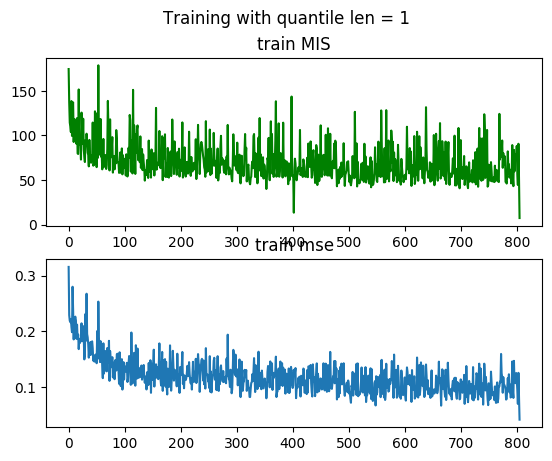

In [362]:
#mse
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training with quantile len = 1')
ax1.plot(q_losses, c='green')
ax1.set_title('train MIS')
ax2.plot(q_mses)
ax2.set_title('train mse')

plt.show()

In [363]:
q10_l = []
q10_m = []
for i in range(3):
    q_encoder, q_decoder, ql, qm = train_epoch(train_loader, q_encoder, q_decoder, 
                                                 q_encoder_optimizer, q_decoder_optimizer, 
                                                 10, quantile_loss_eval)
    q10_l += ql
    q10_m += qm

loss tensor(438.3528, grad_fn=<DivBackward0>)
mse tensor(3.1949, grad_fn=<DivBackward0>)
loss tensor(443.8539, grad_fn=<DivBackward0>)
mse tensor(2.5963, grad_fn=<DivBackward0>)
loss tensor(246.6255, grad_fn=<DivBackward0>)
mse tensor(1.0641, grad_fn=<DivBackward0>)
loss tensor(109.8359, grad_fn=<DivBackward0>)
mse tensor(0.1988, grad_fn=<DivBackward0>)
loss tensor(114.9318, grad_fn=<DivBackward0>)
mse tensor(0.1874, grad_fn=<DivBackward0>)
loss tensor(161.4994, grad_fn=<DivBackward0>)
mse tensor(0.2826, grad_fn=<DivBackward0>)
loss tensor(127.0360, grad_fn=<DivBackward0>)
mse tensor(0.2710, grad_fn=<DivBackward0>)
loss tensor(131.1329, grad_fn=<DivBackward0>)
mse tensor(0.2535, grad_fn=<DivBackward0>)
loss tensor(154.0096, grad_fn=<DivBackward0>)
mse tensor(0.2479, grad_fn=<DivBackward0>)
loss tensor(149.5754, grad_fn=<DivBackward0>)
mse tensor(0.2354, grad_fn=<DivBackward0>)
loss tensor(154.7422, grad_fn=<DivBackward0>)
mse tensor(0.2418, grad_fn=<DivBackward0>)
loss tensor(129.4307,

loss tensor(60.2873, grad_fn=<DivBackward0>)
mse tensor(0.0970, grad_fn=<DivBackward0>)
loss tensor(82.3750, grad_fn=<DivBackward0>)
mse tensor(0.1137, grad_fn=<DivBackward0>)
loss tensor(57.5759, grad_fn=<DivBackward0>)
mse tensor(0.0876, grad_fn=<DivBackward0>)
loss tensor(68.6437, grad_fn=<DivBackward0>)
mse tensor(0.0986, grad_fn=<DivBackward0>)
loss tensor(69.6716, grad_fn=<DivBackward0>)
mse tensor(0.1023, grad_fn=<DivBackward0>)
loss tensor(72.8852, grad_fn=<DivBackward0>)
mse tensor(0.0998, grad_fn=<DivBackward0>)
loss tensor(62.3645, grad_fn=<DivBackward0>)
mse tensor(0.0946, grad_fn=<DivBackward0>)
loss tensor(67.8398, grad_fn=<DivBackward0>)
mse tensor(0.0965, grad_fn=<DivBackward0>)
loss tensor(78.3876, grad_fn=<DivBackward0>)
mse tensor(0.1102, grad_fn=<DivBackward0>)
loss tensor(64.6296, grad_fn=<DivBackward0>)
mse tensor(0.1049, grad_fn=<DivBackward0>)
loss tensor(65.3890, grad_fn=<DivBackward0>)
mse tensor(0.1117, grad_fn=<DivBackward0>)
loss tensor(61.6880, grad_fn=<Di

loss tensor(72.0489, grad_fn=<DivBackward0>)
mse tensor(0.0992, grad_fn=<DivBackward0>)
loss tensor(72.7614, grad_fn=<DivBackward0>)
mse tensor(0.1040, grad_fn=<DivBackward0>)
loss tensor(69.4660, grad_fn=<DivBackward0>)
mse tensor(0.1062, grad_fn=<DivBackward0>)
loss tensor(60.8531, grad_fn=<DivBackward0>)
mse tensor(0.1025, grad_fn=<DivBackward0>)
loss tensor(75.1537, grad_fn=<DivBackward0>)
mse tensor(0.1016, grad_fn=<DivBackward0>)
loss tensor(58.0845, grad_fn=<DivBackward0>)
mse tensor(0.0871, grad_fn=<DivBackward0>)
loss tensor(82.6338, grad_fn=<DivBackward0>)
mse tensor(0.1186, grad_fn=<DivBackward0>)
loss tensor(76.7498, grad_fn=<DivBackward0>)
mse tensor(0.1122, grad_fn=<DivBackward0>)
loss tensor(69.3533, grad_fn=<DivBackward0>)
mse tensor(0.1003, grad_fn=<DivBackward0>)
loss tensor(85.3256, grad_fn=<DivBackward0>)
mse tensor(0.1038, grad_fn=<DivBackward0>)
loss tensor(61.5906, grad_fn=<DivBackward0>)
mse tensor(0.0996, grad_fn=<DivBackward0>)
loss tensor(69.3132, grad_fn=<Di

loss tensor(80.7253, grad_fn=<DivBackward0>)
mse tensor(0.1105, grad_fn=<DivBackward0>)
loss tensor(67.3895, grad_fn=<DivBackward0>)
mse tensor(0.0986, grad_fn=<DivBackward0>)
loss tensor(61.9413, grad_fn=<DivBackward0>)
mse tensor(0.0969, grad_fn=<DivBackward0>)
loss tensor(88.9475, grad_fn=<DivBackward0>)
mse tensor(0.1032, grad_fn=<DivBackward0>)
loss tensor(71.2840, grad_fn=<DivBackward0>)
mse tensor(0.1106, grad_fn=<DivBackward0>)
loss tensor(72.3741, grad_fn=<DivBackward0>)
mse tensor(0.0949, grad_fn=<DivBackward0>)
loss tensor(79.0231, grad_fn=<DivBackward0>)
mse tensor(0.1008, grad_fn=<DivBackward0>)
loss tensor(60.1966, grad_fn=<DivBackward0>)
mse tensor(0.0901, grad_fn=<DivBackward0>)
loss tensor(66.2185, grad_fn=<DivBackward0>)
mse tensor(0.1007, grad_fn=<DivBackward0>)
loss tensor(58.2810, grad_fn=<DivBackward0>)
mse tensor(0.0929, grad_fn=<DivBackward0>)
loss tensor(79.4731, grad_fn=<DivBackward0>)
mse tensor(0.1092, grad_fn=<DivBackward0>)
loss tensor(66.4884, grad_fn=<Di

loss tensor(69.4638, grad_fn=<DivBackward0>)
mse tensor(0.0966, grad_fn=<DivBackward0>)
loss tensor(75.0332, grad_fn=<DivBackward0>)
mse tensor(0.1195, grad_fn=<DivBackward0>)
loss tensor(66.7445, grad_fn=<DivBackward0>)
mse tensor(0.1007, grad_fn=<DivBackward0>)
loss tensor(74.4875, grad_fn=<DivBackward0>)
mse tensor(0.1010, grad_fn=<DivBackward0>)
loss tensor(73.5485, grad_fn=<DivBackward0>)
mse tensor(0.1092, grad_fn=<DivBackward0>)
loss tensor(63.6870, grad_fn=<DivBackward0>)
mse tensor(0.1069, grad_fn=<DivBackward0>)
loss tensor(73.1683, grad_fn=<DivBackward0>)
mse tensor(0.1094, grad_fn=<DivBackward0>)
loss tensor(72.0313, grad_fn=<DivBackward0>)
mse tensor(0.1025, grad_fn=<DivBackward0>)
loss tensor(68.4176, grad_fn=<DivBackward0>)
mse tensor(0.1047, grad_fn=<DivBackward0>)
loss tensor(73.3720, grad_fn=<DivBackward0>)
mse tensor(0.1014, grad_fn=<DivBackward0>)
loss tensor(57.9671, grad_fn=<DivBackward0>)
mse tensor(0.0879, grad_fn=<DivBackward0>)
loss tensor(70.2844, grad_fn=<Di

loss tensor(68.5471, grad_fn=<DivBackward0>)
mse tensor(0.0915, grad_fn=<DivBackward0>)
loss tensor(61.9377, grad_fn=<DivBackward0>)
mse tensor(0.0911, grad_fn=<DivBackward0>)
loss tensor(62.4281, grad_fn=<DivBackward0>)
mse tensor(0.0976, grad_fn=<DivBackward0>)
loss tensor(80.9921, grad_fn=<DivBackward0>)
mse tensor(0.0985, grad_fn=<DivBackward0>)
loss tensor(80.2416, grad_fn=<DivBackward0>)
mse tensor(0.1109, grad_fn=<DivBackward0>)
loss tensor(68.6630, grad_fn=<DivBackward0>)
mse tensor(0.0830, grad_fn=<DivBackward0>)
loss tensor(72.2222, grad_fn=<DivBackward0>)
mse tensor(0.0910, grad_fn=<DivBackward0>)
loss tensor(59.0839, grad_fn=<DivBackward0>)
mse tensor(0.0912, grad_fn=<DivBackward0>)
loss tensor(87.7234, grad_fn=<DivBackward0>)
mse tensor(0.1196, grad_fn=<DivBackward0>)
loss tensor(61.8727, grad_fn=<DivBackward0>)
mse tensor(0.0949, grad_fn=<DivBackward0>)
loss tensor(71.6059, grad_fn=<DivBackward0>)
mse tensor(0.1075, grad_fn=<DivBackward0>)
loss tensor(75.0209, grad_fn=<Di

loss tensor(61.6903, grad_fn=<DivBackward0>)
mse tensor(0.0904, grad_fn=<DivBackward0>)
loss tensor(65.9000, grad_fn=<DivBackward0>)
mse tensor(0.0917, grad_fn=<DivBackward0>)
loss tensor(95.4065, grad_fn=<DivBackward0>)
mse tensor(0.1038, grad_fn=<DivBackward0>)
loss tensor(65.4669, grad_fn=<DivBackward0>)
mse tensor(0.1026, grad_fn=<DivBackward0>)
loss tensor(80.0289, grad_fn=<DivBackward0>)
mse tensor(0.1006, grad_fn=<DivBackward0>)
loss tensor(57.4206, grad_fn=<DivBackward0>)
mse tensor(0.0822, grad_fn=<DivBackward0>)
loss tensor(54.6127, grad_fn=<DivBackward0>)
mse tensor(0.0939, grad_fn=<DivBackward0>)
loss tensor(81.6919, grad_fn=<DivBackward0>)
mse tensor(0.1145, grad_fn=<DivBackward0>)
loss tensor(66.3405, grad_fn=<DivBackward0>)
mse tensor(0.0960, grad_fn=<DivBackward0>)
loss tensor(67.4056, grad_fn=<DivBackward0>)
mse tensor(0.1052, grad_fn=<DivBackward0>)
loss tensor(58.7079, grad_fn=<DivBackward0>)
mse tensor(0.0947, grad_fn=<DivBackward0>)
loss tensor(65.5754, grad_fn=<Di

loss tensor(67.6928, grad_fn=<DivBackward0>)
mse tensor(0.1048, grad_fn=<DivBackward0>)
loss tensor(68.3053, grad_fn=<DivBackward0>)
mse tensor(0.0899, grad_fn=<DivBackward0>)
loss tensor(63.8513, grad_fn=<DivBackward0>)
mse tensor(0.1004, grad_fn=<DivBackward0>)
loss tensor(69.0246, grad_fn=<DivBackward0>)
mse tensor(0.1022, grad_fn=<DivBackward0>)
loss tensor(65.7216, grad_fn=<DivBackward0>)
mse tensor(0.0925, grad_fn=<DivBackward0>)
loss tensor(70.0232, grad_fn=<DivBackward0>)
mse tensor(0.0913, grad_fn=<DivBackward0>)
loss tensor(70.8035, grad_fn=<DivBackward0>)
mse tensor(0.1139, grad_fn=<DivBackward0>)
loss tensor(68.6196, grad_fn=<DivBackward0>)
mse tensor(0.0919, grad_fn=<DivBackward0>)
loss tensor(60.3874, grad_fn=<DivBackward0>)
mse tensor(0.0940, grad_fn=<DivBackward0>)
loss tensor(75.6262, grad_fn=<DivBackward0>)
mse tensor(0.0976, grad_fn=<DivBackward0>)
loss tensor(63.7941, grad_fn=<DivBackward0>)
mse tensor(0.0895, grad_fn=<DivBackward0>)
loss tensor(59.6481, grad_fn=<Di

loss tensor(70.6343, grad_fn=<DivBackward0>)
mse tensor(0.0952, grad_fn=<DivBackward0>)
loss tensor(59.0796, grad_fn=<DivBackward0>)
mse tensor(0.0922, grad_fn=<DivBackward0>)
loss tensor(76.5513, grad_fn=<DivBackward0>)
mse tensor(0.1007, grad_fn=<DivBackward0>)
loss tensor(64.5485, grad_fn=<DivBackward0>)
mse tensor(0.0986, grad_fn=<DivBackward0>)
loss tensor(75.1059, grad_fn=<DivBackward0>)
mse tensor(0.1025, grad_fn=<DivBackward0>)
loss tensor(59.0099, grad_fn=<DivBackward0>)
mse tensor(0.0879, grad_fn=<DivBackward0>)
loss tensor(66.0791, grad_fn=<DivBackward0>)
mse tensor(0.0987, grad_fn=<DivBackward0>)
loss tensor(59.6299, grad_fn=<DivBackward0>)
mse tensor(0.0906, grad_fn=<DivBackward0>)
loss tensor(59.7753, grad_fn=<DivBackward0>)
mse tensor(0.0860, grad_fn=<DivBackward0>)
loss tensor(77.9184, grad_fn=<DivBackward0>)
mse tensor(0.1003, grad_fn=<DivBackward0>)
loss tensor(61.4580, grad_fn=<DivBackward0>)
mse tensor(0.0997, grad_fn=<DivBackward0>)
loss tensor(64.1127, grad_fn=<Di

loss tensor(66.8349, grad_fn=<DivBackward0>)
mse tensor(0.0965, grad_fn=<DivBackward0>)
loss tensor(55.1638, grad_fn=<DivBackward0>)
mse tensor(0.0857, grad_fn=<DivBackward0>)
loss tensor(85.9873, grad_fn=<DivBackward0>)
mse tensor(0.1035, grad_fn=<DivBackward0>)
loss tensor(61.8766, grad_fn=<DivBackward0>)
mse tensor(0.0946, grad_fn=<DivBackward0>)
loss tensor(60.2382, grad_fn=<DivBackward0>)
mse tensor(0.0928, grad_fn=<DivBackward0>)
loss tensor(72.6621, grad_fn=<DivBackward0>)
mse tensor(0.0983, grad_fn=<DivBackward0>)
loss tensor(75.1663, grad_fn=<DivBackward0>)
mse tensor(0.0958, grad_fn=<DivBackward0>)
loss tensor(61.0034, grad_fn=<DivBackward0>)
mse tensor(0.0955, grad_fn=<DivBackward0>)
loss tensor(74.1442, grad_fn=<DivBackward0>)
mse tensor(0.1090, grad_fn=<DivBackward0>)
loss tensor(72.0094, grad_fn=<DivBackward0>)
mse tensor(0.0995, grad_fn=<DivBackward0>)
loss tensor(58.9310, grad_fn=<DivBackward0>)
mse tensor(0.0861, grad_fn=<DivBackward0>)
loss tensor(72.7408, grad_fn=<Di

loss tensor(61.5684, grad_fn=<DivBackward0>)
mse tensor(0.0862, grad_fn=<DivBackward0>)
loss tensor(67.0557, grad_fn=<DivBackward0>)
mse tensor(0.0980, grad_fn=<DivBackward0>)
loss tensor(78.0525, grad_fn=<DivBackward0>)
mse tensor(0.0914, grad_fn=<DivBackward0>)
loss tensor(69.2903, grad_fn=<DivBackward0>)
mse tensor(0.0931, grad_fn=<DivBackward0>)
loss tensor(61.5407, grad_fn=<DivBackward0>)
mse tensor(0.0937, grad_fn=<DivBackward0>)
loss tensor(67.5480, grad_fn=<DivBackward0>)
mse tensor(0.1012, grad_fn=<DivBackward0>)
loss tensor(63.5063, grad_fn=<DivBackward0>)
mse tensor(0.0920, grad_fn=<DivBackward0>)
loss tensor(72.8415, grad_fn=<DivBackward0>)
mse tensor(0.1048, grad_fn=<DivBackward0>)
loss tensor(58.3335, grad_fn=<DivBackward0>)
mse tensor(0.0905, grad_fn=<DivBackward0>)
loss tensor(60.6131, grad_fn=<DivBackward0>)
mse tensor(0.0939, grad_fn=<DivBackward0>)
loss tensor(73.2743, grad_fn=<DivBackward0>)
mse tensor(0.1049, grad_fn=<DivBackward0>)
loss tensor(72.3757, grad_fn=<Di

loss tensor(65.0272, grad_fn=<DivBackward0>)
mse tensor(0.0995, grad_fn=<DivBackward0>)
loss tensor(65.9437, grad_fn=<DivBackward0>)
mse tensor(0.0995, grad_fn=<DivBackward0>)
loss tensor(57.4654, grad_fn=<DivBackward0>)
mse tensor(0.0871, grad_fn=<DivBackward0>)
loss tensor(67.7182, grad_fn=<DivBackward0>)
mse tensor(0.0950, grad_fn=<DivBackward0>)
loss tensor(56.4960, grad_fn=<DivBackward0>)
mse tensor(0.0844, grad_fn=<DivBackward0>)
loss tensor(69.9567, grad_fn=<DivBackward0>)
mse tensor(0.0927, grad_fn=<DivBackward0>)
loss tensor(62.8558, grad_fn=<DivBackward0>)
mse tensor(0.0952, grad_fn=<DivBackward0>)
loss tensor(61.8531, grad_fn=<DivBackward0>)
mse tensor(0.0961, grad_fn=<DivBackward0>)
loss tensor(67.7575, grad_fn=<DivBackward0>)
mse tensor(0.0889, grad_fn=<DivBackward0>)
loss tensor(81.1911, grad_fn=<DivBackward0>)
mse tensor(0.1094, grad_fn=<DivBackward0>)
loss tensor(59.7644, grad_fn=<DivBackward0>)
mse tensor(0.0887, grad_fn=<DivBackward0>)
loss tensor(66.0448, grad_fn=<Di

loss tensor(58.1542, grad_fn=<DivBackward0>)
mse tensor(0.0791, grad_fn=<DivBackward0>)
loss tensor(70.5233, grad_fn=<DivBackward0>)
mse tensor(0.1046, grad_fn=<DivBackward0>)
loss tensor(61.4733, grad_fn=<DivBackward0>)
mse tensor(0.1037, grad_fn=<DivBackward0>)
loss tensor(60.5933, grad_fn=<DivBackward0>)
mse tensor(0.0894, grad_fn=<DivBackward0>)
loss tensor(75.4283, grad_fn=<DivBackward0>)
mse tensor(0.0990, grad_fn=<DivBackward0>)
loss tensor(64.0478, grad_fn=<DivBackward0>)
mse tensor(0.0904, grad_fn=<DivBackward0>)
loss tensor(72.2996, grad_fn=<DivBackward0>)
mse tensor(0.1042, grad_fn=<DivBackward0>)
loss tensor(64.1462, grad_fn=<DivBackward0>)
mse tensor(0.0933, grad_fn=<DivBackward0>)
loss tensor(68.8718, grad_fn=<DivBackward0>)
mse tensor(0.0965, grad_fn=<DivBackward0>)
loss tensor(58.7964, grad_fn=<DivBackward0>)
mse tensor(0.0883, grad_fn=<DivBackward0>)
loss tensor(53.5424, grad_fn=<DivBackward0>)
mse tensor(0.0796, grad_fn=<DivBackward0>)
loss tensor(45.3210, grad_fn=<Di

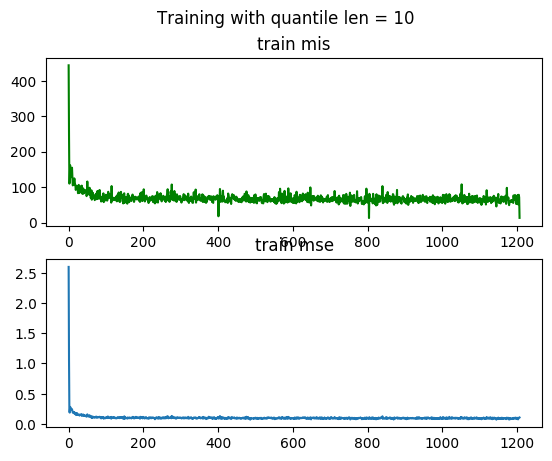

In [380]:
#mse
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training with quantile len = 10')
ax1.plot(q10_l[1:], c='green')
ax1.set_title('train mis')
ax2.plot(q10_m[1:])
ax2.set_title('train mse')

plt.show()

In [365]:
q30_l = []
q30_m = []
for i in range(2):
    q_encoder, q_decoder, ql, qm = train_epoch(train_loader, q_encoder, q_decoder, 
                                                 q_encoder_optimizer, q_decoder_optimizer, 
                                                 30, quantile_loss_eval)
    q30_l += ql
    q30_m += qm
    

loss tensor(105.2228, grad_fn=<DivBackward0>)
mse tensor(0.1437, grad_fn=<DivBackward0>)
loss tensor(111.1552, grad_fn=<DivBackward0>)
mse tensor(0.1372, grad_fn=<DivBackward0>)
loss tensor(128.4672, grad_fn=<DivBackward0>)
mse tensor(0.1507, grad_fn=<DivBackward0>)
loss tensor(92.7858, grad_fn=<DivBackward0>)
mse tensor(0.1265, grad_fn=<DivBackward0>)
loss tensor(109.0592, grad_fn=<DivBackward0>)
mse tensor(0.1338, grad_fn=<DivBackward0>)
loss tensor(109.8168, grad_fn=<DivBackward0>)
mse tensor(0.1427, grad_fn=<DivBackward0>)
loss tensor(112.6981, grad_fn=<DivBackward0>)
mse tensor(0.1403, grad_fn=<DivBackward0>)
loss tensor(108.8096, grad_fn=<DivBackward0>)
mse tensor(0.1418, grad_fn=<DivBackward0>)
loss tensor(116.5750, grad_fn=<DivBackward0>)
mse tensor(0.1410, grad_fn=<DivBackward0>)
loss tensor(105.3909, grad_fn=<DivBackward0>)
mse tensor(0.1461, grad_fn=<DivBackward0>)
loss tensor(109.2028, grad_fn=<DivBackward0>)
mse tensor(0.1374, grad_fn=<DivBackward0>)
loss tensor(109.0799, 

loss tensor(116.8749, grad_fn=<DivBackward0>)
mse tensor(0.1497, grad_fn=<DivBackward0>)
loss tensor(112.7542, grad_fn=<DivBackward0>)
mse tensor(0.1430, grad_fn=<DivBackward0>)
loss tensor(118.5045, grad_fn=<DivBackward0>)
mse tensor(0.1457, grad_fn=<DivBackward0>)
loss tensor(105.7691, grad_fn=<DivBackward0>)
mse tensor(0.1353, grad_fn=<DivBackward0>)
loss tensor(98.8255, grad_fn=<DivBackward0>)
mse tensor(0.1239, grad_fn=<DivBackward0>)
loss tensor(105.9954, grad_fn=<DivBackward0>)
mse tensor(0.1287, grad_fn=<DivBackward0>)
loss tensor(101.9139, grad_fn=<DivBackward0>)
mse tensor(0.1243, grad_fn=<DivBackward0>)
loss tensor(98.2416, grad_fn=<DivBackward0>)
mse tensor(0.1258, grad_fn=<DivBackward0>)
loss tensor(97.5759, grad_fn=<DivBackward0>)
mse tensor(0.1204, grad_fn=<DivBackward0>)
loss tensor(108.5404, grad_fn=<DivBackward0>)
mse tensor(0.1378, grad_fn=<DivBackward0>)
loss tensor(106.3659, grad_fn=<DivBackward0>)
mse tensor(0.1242, grad_fn=<DivBackward0>)
loss tensor(100.6869, gr

loss tensor(94.0642, grad_fn=<DivBackward0>)
mse tensor(0.1292, grad_fn=<DivBackward0>)
loss tensor(96.3891, grad_fn=<DivBackward0>)
mse tensor(0.1283, grad_fn=<DivBackward0>)
loss tensor(96.8171, grad_fn=<DivBackward0>)
mse tensor(0.1195, grad_fn=<DivBackward0>)
loss tensor(106.9849, grad_fn=<DivBackward0>)
mse tensor(0.1332, grad_fn=<DivBackward0>)
loss tensor(112.5037, grad_fn=<DivBackward0>)
mse tensor(0.1314, grad_fn=<DivBackward0>)
loss tensor(92.2181, grad_fn=<DivBackward0>)
mse tensor(0.1234, grad_fn=<DivBackward0>)
loss tensor(103.3709, grad_fn=<DivBackward0>)
mse tensor(0.1442, grad_fn=<DivBackward0>)
loss tensor(96.1421, grad_fn=<DivBackward0>)
mse tensor(0.1234, grad_fn=<DivBackward0>)
loss tensor(113.9296, grad_fn=<DivBackward0>)
mse tensor(0.1356, grad_fn=<DivBackward0>)
loss tensor(98.6266, grad_fn=<DivBackward0>)
mse tensor(0.1353, grad_fn=<DivBackward0>)
loss tensor(100.3466, grad_fn=<DivBackward0>)
mse tensor(0.1247, grad_fn=<DivBackward0>)
loss tensor(114.0123, grad_

loss tensor(105.1363, grad_fn=<DivBackward0>)
mse tensor(0.1334, grad_fn=<DivBackward0>)
loss tensor(107.0003, grad_fn=<DivBackward0>)
mse tensor(0.1256, grad_fn=<DivBackward0>)
loss tensor(98.0297, grad_fn=<DivBackward0>)
mse tensor(0.1297, grad_fn=<DivBackward0>)
loss tensor(97.9634, grad_fn=<DivBackward0>)
mse tensor(0.1303, grad_fn=<DivBackward0>)
loss tensor(108.3503, grad_fn=<DivBackward0>)
mse tensor(0.1279, grad_fn=<DivBackward0>)
loss tensor(99.7783, grad_fn=<DivBackward0>)
mse tensor(0.1271, grad_fn=<DivBackward0>)
loss tensor(119.2037, grad_fn=<DivBackward0>)
mse tensor(0.1443, grad_fn=<DivBackward0>)
loss tensor(103.9138, grad_fn=<DivBackward0>)
mse tensor(0.1294, grad_fn=<DivBackward0>)
loss tensor(104.9556, grad_fn=<DivBackward0>)
mse tensor(0.1329, grad_fn=<DivBackward0>)
loss tensor(96.0553, grad_fn=<DivBackward0>)
mse tensor(0.1174, grad_fn=<DivBackward0>)
loss tensor(100.8455, grad_fn=<DivBackward0>)
mse tensor(0.1337, grad_fn=<DivBackward0>)
loss tensor(104.9476, gra

loss tensor(112.0901, grad_fn=<DivBackward0>)
mse tensor(0.1359, grad_fn=<DivBackward0>)
loss tensor(94.5617, grad_fn=<DivBackward0>)
mse tensor(0.1219, grad_fn=<DivBackward0>)
loss tensor(115.0955, grad_fn=<DivBackward0>)
mse tensor(0.1444, grad_fn=<DivBackward0>)
loss tensor(104.4524, grad_fn=<DivBackward0>)
mse tensor(0.1236, grad_fn=<DivBackward0>)
loss tensor(108.6040, grad_fn=<DivBackward0>)
mse tensor(0.1379, grad_fn=<DivBackward0>)
loss tensor(116.1484, grad_fn=<DivBackward0>)
mse tensor(0.1373, grad_fn=<DivBackward0>)
loss tensor(102.0716, grad_fn=<DivBackward0>)
mse tensor(0.1281, grad_fn=<DivBackward0>)
loss tensor(99.9432, grad_fn=<DivBackward0>)
mse tensor(0.1214, grad_fn=<DivBackward0>)
loss tensor(97.4450, grad_fn=<DivBackward0>)
mse tensor(0.1261, grad_fn=<DivBackward0>)
loss tensor(109.4137, grad_fn=<DivBackward0>)
mse tensor(0.1411, grad_fn=<DivBackward0>)
loss tensor(90.3875, grad_fn=<DivBackward0>)
mse tensor(0.1183, grad_fn=<DivBackward0>)
loss tensor(120.3321, gra

loss tensor(116.5092, grad_fn=<DivBackward0>)
mse tensor(0.1416, grad_fn=<DivBackward0>)
loss tensor(118.9633, grad_fn=<DivBackward0>)
mse tensor(0.1430, grad_fn=<DivBackward0>)
loss tensor(89.3075, grad_fn=<DivBackward0>)
mse tensor(0.1244, grad_fn=<DivBackward0>)
loss tensor(106.3219, grad_fn=<DivBackward0>)
mse tensor(0.1335, grad_fn=<DivBackward0>)
loss tensor(100.1258, grad_fn=<DivBackward0>)
mse tensor(0.1317, grad_fn=<DivBackward0>)
loss tensor(89.3926, grad_fn=<DivBackward0>)
mse tensor(0.1190, grad_fn=<DivBackward0>)
loss tensor(98.6433, grad_fn=<DivBackward0>)
mse tensor(0.1289, grad_fn=<DivBackward0>)
loss tensor(101.0470, grad_fn=<DivBackward0>)
mse tensor(0.1250, grad_fn=<DivBackward0>)
loss tensor(95.6653, grad_fn=<DivBackward0>)
mse tensor(0.1269, grad_fn=<DivBackward0>)
loss tensor(93.7777, grad_fn=<DivBackward0>)
mse tensor(0.1214, grad_fn=<DivBackward0>)
loss tensor(107.9603, grad_fn=<DivBackward0>)
mse tensor(0.1383, grad_fn=<DivBackward0>)
loss tensor(103.1435, grad

loss tensor(112.5711, grad_fn=<DivBackward0>)
mse tensor(0.1273, grad_fn=<DivBackward0>)
loss tensor(102.6987, grad_fn=<DivBackward0>)
mse tensor(0.1370, grad_fn=<DivBackward0>)
loss tensor(99.1439, grad_fn=<DivBackward0>)
mse tensor(0.1268, grad_fn=<DivBackward0>)
loss tensor(91.7716, grad_fn=<DivBackward0>)
mse tensor(0.1219, grad_fn=<DivBackward0>)
loss tensor(103.6828, grad_fn=<DivBackward0>)
mse tensor(0.1346, grad_fn=<DivBackward0>)
loss tensor(118.2040, grad_fn=<DivBackward0>)
mse tensor(0.1437, grad_fn=<DivBackward0>)
loss tensor(94.9516, grad_fn=<DivBackward0>)
mse tensor(0.1259, grad_fn=<DivBackward0>)
loss tensor(86.8380, grad_fn=<DivBackward0>)
mse tensor(0.1162, grad_fn=<DivBackward0>)
loss tensor(91.9744, grad_fn=<DivBackward0>)
mse tensor(0.1223, grad_fn=<DivBackward0>)
loss tensor(106.6649, grad_fn=<DivBackward0>)
mse tensor(0.1328, grad_fn=<DivBackward0>)
loss tensor(100.5236, grad_fn=<DivBackward0>)
mse tensor(0.1306, grad_fn=<DivBackward0>)
loss tensor(89.1018, grad_

loss tensor(113.7675, grad_fn=<DivBackward0>)
mse tensor(0.1397, grad_fn=<DivBackward0>)
loss tensor(94.4954, grad_fn=<DivBackward0>)
mse tensor(0.1176, grad_fn=<DivBackward0>)
loss tensor(112.5206, grad_fn=<DivBackward0>)
mse tensor(0.1385, grad_fn=<DivBackward0>)
loss tensor(125.2240, grad_fn=<DivBackward0>)
mse tensor(0.1455, grad_fn=<DivBackward0>)
loss tensor(98.9413, grad_fn=<DivBackward0>)
mse tensor(0.1254, grad_fn=<DivBackward0>)
loss tensor(111.8632, grad_fn=<DivBackward0>)
mse tensor(0.1325, grad_fn=<DivBackward0>)
loss tensor(108.4748, grad_fn=<DivBackward0>)
mse tensor(0.1378, grad_fn=<DivBackward0>)
loss tensor(102.8284, grad_fn=<DivBackward0>)
mse tensor(0.1292, grad_fn=<DivBackward0>)
loss tensor(91.6615, grad_fn=<DivBackward0>)
mse tensor(0.1226, grad_fn=<DivBackward0>)
loss tensor(99.5870, grad_fn=<DivBackward0>)
mse tensor(0.1375, grad_fn=<DivBackward0>)
loss tensor(96.6628, grad_fn=<DivBackward0>)
mse tensor(0.1274, grad_fn=<DivBackward0>)
loss tensor(87.2122, grad_

loss tensor(109.7281, grad_fn=<DivBackward0>)
mse tensor(0.1426, grad_fn=<DivBackward0>)
loss tensor(93.7083, grad_fn=<DivBackward0>)
mse tensor(0.1257, grad_fn=<DivBackward0>)
loss tensor(103.7494, grad_fn=<DivBackward0>)
mse tensor(0.1324, grad_fn=<DivBackward0>)
loss tensor(98.7381, grad_fn=<DivBackward0>)
mse tensor(0.1267, grad_fn=<DivBackward0>)
loss tensor(103.8775, grad_fn=<DivBackward0>)
mse tensor(0.1288, grad_fn=<DivBackward0>)
loss tensor(93.4520, grad_fn=<DivBackward0>)
mse tensor(0.1208, grad_fn=<DivBackward0>)
loss tensor(96.2574, grad_fn=<DivBackward0>)
mse tensor(0.1270, grad_fn=<DivBackward0>)
loss tensor(107.0832, grad_fn=<DivBackward0>)
mse tensor(0.1354, grad_fn=<DivBackward0>)
loss tensor(102.1662, grad_fn=<DivBackward0>)
mse tensor(0.1223, grad_fn=<DivBackward0>)
loss tensor(97.6128, grad_fn=<DivBackward0>)
mse tensor(0.1318, grad_fn=<DivBackward0>)
loss tensor(106.6661, grad_fn=<DivBackward0>)
mse tensor(0.1356, grad_fn=<DivBackward0>)
loss tensor(105.4079, grad

loss tensor(95.7567, grad_fn=<DivBackward0>)
mse tensor(0.1283, grad_fn=<DivBackward0>)
loss tensor(116.6124, grad_fn=<DivBackward0>)
mse tensor(0.1439, grad_fn=<DivBackward0>)
loss tensor(105.5004, grad_fn=<DivBackward0>)
mse tensor(0.1261, grad_fn=<DivBackward0>)
loss tensor(97.9312, grad_fn=<DivBackward0>)
mse tensor(0.1316, grad_fn=<DivBackward0>)
loss tensor(108.7030, grad_fn=<DivBackward0>)
mse tensor(0.1303, grad_fn=<DivBackward0>)
loss tensor(85.1928, grad_fn=<DivBackward0>)
mse tensor(0.1122, grad_fn=<DivBackward0>)
loss tensor(114.9049, grad_fn=<DivBackward0>)
mse tensor(0.1432, grad_fn=<DivBackward0>)
loss tensor(110.1812, grad_fn=<DivBackward0>)
mse tensor(0.1374, grad_fn=<DivBackward0>)
loss tensor(96.5563, grad_fn=<DivBackward0>)
mse tensor(0.1227, grad_fn=<DivBackward0>)
loss tensor(101.7514, grad_fn=<DivBackward0>)
mse tensor(0.1307, grad_fn=<DivBackward0>)
loss tensor(96.5824, grad_fn=<DivBackward0>)
mse tensor(0.1194, grad_fn=<DivBackward0>)
loss tensor(97.5711, grad_

loss tensor(100.3748, grad_fn=<DivBackward0>)
mse tensor(0.1296, grad_fn=<DivBackward0>)
loss tensor(100.7386, grad_fn=<DivBackward0>)
mse tensor(0.1269, grad_fn=<DivBackward0>)
loss tensor(96.9350, grad_fn=<DivBackward0>)
mse tensor(0.1298, grad_fn=<DivBackward0>)
loss tensor(104.8536, grad_fn=<DivBackward0>)
mse tensor(0.1260, grad_fn=<DivBackward0>)
loss tensor(119.9602, grad_fn=<DivBackward0>)
mse tensor(0.1554, grad_fn=<DivBackward0>)
loss tensor(103.6542, grad_fn=<DivBackward0>)
mse tensor(0.1354, grad_fn=<DivBackward0>)
loss tensor(111.6029, grad_fn=<DivBackward0>)
mse tensor(0.1400, grad_fn=<DivBackward0>)
loss tensor(101.8251, grad_fn=<DivBackward0>)
mse tensor(0.1235, grad_fn=<DivBackward0>)
loss tensor(112.7927, grad_fn=<DivBackward0>)
mse tensor(0.1453, grad_fn=<DivBackward0>)
loss tensor(104.1802, grad_fn=<DivBackward0>)
mse tensor(0.1387, grad_fn=<DivBackward0>)
loss tensor(89.2365, grad_fn=<DivBackward0>)
mse tensor(0.1146, grad_fn=<DivBackward0>)
loss tensor(94.3518, gr

loss tensor(92.5599, grad_fn=<DivBackward0>)
mse tensor(0.1181, grad_fn=<DivBackward0>)
loss tensor(110.5360, grad_fn=<DivBackward0>)
mse tensor(0.1400, grad_fn=<DivBackward0>)
loss tensor(105.6225, grad_fn=<DivBackward0>)
mse tensor(0.1333, grad_fn=<DivBackward0>)
loss tensor(98.6953, grad_fn=<DivBackward0>)
mse tensor(0.1227, grad_fn=<DivBackward0>)
loss tensor(95.4403, grad_fn=<DivBackward0>)
mse tensor(0.1234, grad_fn=<DivBackward0>)
loss tensor(98.6362, grad_fn=<DivBackward0>)
mse tensor(0.1301, grad_fn=<DivBackward0>)
loss tensor(97.9444, grad_fn=<DivBackward0>)
mse tensor(0.1241, grad_fn=<DivBackward0>)
loss tensor(98.5227, grad_fn=<DivBackward0>)
mse tensor(0.1236, grad_fn=<DivBackward0>)
loss tensor(104.7580, grad_fn=<DivBackward0>)
mse tensor(0.1377, grad_fn=<DivBackward0>)
loss tensor(91.3060, grad_fn=<DivBackward0>)
mse tensor(0.1182, grad_fn=<DivBackward0>)
loss tensor(95.8567, grad_fn=<DivBackward0>)
mse tensor(0.1262, grad_fn=<DivBackward0>)
loss tensor(90.3860, grad_fn=

loss tensor(115.6749, grad_fn=<DivBackward0>)
mse tensor(0.1402, grad_fn=<DivBackward0>)
loss tensor(119.3822, grad_fn=<DivBackward0>)
mse tensor(0.1511, grad_fn=<DivBackward0>)
loss tensor(116.9913, grad_fn=<DivBackward0>)
mse tensor(0.1294, grad_fn=<DivBackward0>)
loss tensor(148.6172, grad_fn=<DivBackward0>)
mse tensor(0.1500, grad_fn=<DivBackward0>)
loss tensor(94.7110, grad_fn=<DivBackward0>)
mse tensor(0.1231, grad_fn=<DivBackward0>)
loss tensor(106.1720, grad_fn=<DivBackward0>)
mse tensor(0.1279, grad_fn=<DivBackward0>)
loss tensor(85.9977, grad_fn=<DivBackward0>)
mse tensor(0.1095, grad_fn=<DivBackward0>)
loss tensor(100.6698, grad_fn=<DivBackward0>)
mse tensor(0.1374, grad_fn=<DivBackward0>)
loss tensor(103.1197, grad_fn=<DivBackward0>)
mse tensor(0.1338, grad_fn=<DivBackward0>)
loss tensor(123.3121, grad_fn=<DivBackward0>)
mse tensor(0.1412, grad_fn=<DivBackward0>)
loss tensor(108.2029, grad_fn=<DivBackward0>)
mse tensor(0.1409, grad_fn=<DivBackward0>)
loss tensor(99.2664, gr

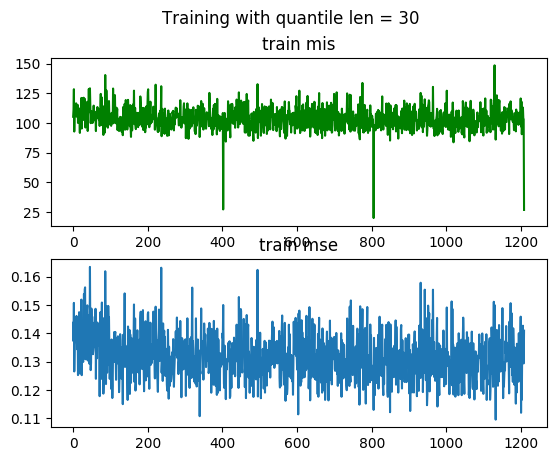

In [366]:
#mse
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training with quantile len = 30')
ax1.plot(q30_l, c='green')
ax1.set_title('train mis')
ax2.plot(q30_m)
ax2.set_title('train mse')

plt.show()

In [367]:
temp_save_dir = tempfile.mkdtemp()

test_size = data_dict["test_input"].shape[0]
print('test size', test_size)
test_data_subsets = baseline_utils.get_test_data_dict_subset(data_dict, args)

for i in  range(0, test_size, args.joblib_batch_size):
    infer_helper(args, test_data_subsets[i], i, q_encoder, q_decoder,
                                  model_utils, temp_save_dir)

    
traj_save_path = 'traj/lstm_quant2_test.pkl'
baseline_utils.merge_saved_traj(temp_save_dir, traj_save_path) #args.traj_save_path
shutil.rmtree(temp_save_dir)
print(f"Forecasted Trajectories saved at {traj_save_path}")


test size 39472
#### LSTM inference at 0 ####
#### LSTM inference at 100 ####
#### LSTM inference at 200 ####
#### LSTM inference at 300 ####
#### LSTM inference at 400 ####
#### LSTM inference at 500 ####
#### LSTM inference at 600 ####
#### LSTM inference at 700 ####
#### LSTM inference at 800 ####
#### LSTM inference at 900 ####
#### LSTM inference at 1000 ####
#### LSTM inference at 1100 ####
#### LSTM inference at 1200 ####
#### LSTM inference at 1300 ####
#### LSTM inference at 1400 ####
#### LSTM inference at 1500 ####
#### LSTM inference at 1600 ####
#### LSTM inference at 1700 ####
#### LSTM inference at 1800 ####
#### LSTM inference at 1900 ####
#### LSTM inference at 2000 ####
#### LSTM inference at 2100 ####
#### LSTM inference at 2200 ####
#### LSTM inference at 2300 ####
#### LSTM inference at 2400 ####
#### LSTM inference at 2500 ####
#### LSTM inference at 2600 ####
#### LSTM inference at 2700 ####
#### LSTM inference at 2800 ####
#### LSTM inference at 2900 ####
#### L

#### LSTM inference at 24500 ####
#### LSTM inference at 24600 ####
#### LSTM inference at 24700 ####
#### LSTM inference at 24800 ####
#### LSTM inference at 24900 ####
#### LSTM inference at 25000 ####
#### LSTM inference at 25100 ####
#### LSTM inference at 25200 ####
#### LSTM inference at 25300 ####
#### LSTM inference at 25400 ####
#### LSTM inference at 25500 ####
#### LSTM inference at 25600 ####
#### LSTM inference at 25700 ####
#### LSTM inference at 25800 ####
#### LSTM inference at 25900 ####
#### LSTM inference at 26000 ####
#### LSTM inference at 26100 ####
#### LSTM inference at 26200 ####
#### LSTM inference at 26300 ####
#### LSTM inference at 26400 ####
#### LSTM inference at 26500 ####
#### LSTM inference at 26600 ####
#### LSTM inference at 26700 ####
#### LSTM inference at 26800 ####
#### LSTM inference at 26900 ####
#### LSTM inference at 27000 ####
#### LSTM inference at 27100 ####
#### LSTM inference at 27200 ####
#### LSTM inference at 27300 ####
#### LSTM infe

In [381]:
save_dir = 'saved_models/lstm_quant'
os.makedirs(save_dir, exist_ok=True)
model_utils.save_checkpoint(
    save_dir,
    {
        "epoch": epoch + 1,
        "rollout_len": rollout_len,
        "encoder_state_dict": q_encoder.state_dict(),
        "decoder_state_dict": q_decoder.state_dict(),
        "best_loss": 0,
        "encoder_optimizer": q_encoder_optimizer.state_dict(),
        "decoder_optimizer": q_decoder_optimizer.state_dict(),
    },
)

In [287]:

def viz_predictions_helper(
    args,
    forecasted_trajectories: Dict[int, List[np.ndarray]],
    gt_trajectories: Dict[int, np.ndarray],
    features_df: pd.DataFrame,
    viz_seq_id: Union[None, List[int]],
) -> None:
    """Visualize predictions.

    Args:
        forecasted_trajectories: Trajectories forecasted by the algorithm.
        gt_trajectories: Ground Truth trajectories.
        features_df: DataFrame containing the features
        viz_seq_id: Sequence ids to be visualized

    """
    seq_ids = gt_trajectories.keys() if viz_seq_id is None else viz_seq_id
    for seq_id in seq_ids:
        gt_trajectory = gt_trajectories[seq_id]
        curr_features_df = features_df[features_df["SEQUENCE"] == seq_id]
        input_trajectory = (
            curr_features_df["FEATURES"].values[0]
            [:args.obs_len, [FEATURE_FORMAT["X"], FEATURE_FORMAT["Y"]]].astype(
                "float"))
        output_trajectories = forecasted_trajectories[seq_id]
        candidate_centerlines = curr_features_df[
            "CANDIDATE_CENTERLINES"].values[0]
        city_name = curr_features_df["FEATURES"].values[0][
            0, FEATURE_FORMAT["CITY_NAME"]]

        gt_trajectory = np.expand_dims(gt_trajectory, 0)
        input_trajectory = np.expand_dims(input_trajectory, 0)
        output_trajectories = np.expand_dims(np.array(output_trajectories), 0)
        candidate_centerlines = np.expand_dims(np.array(candidate_centerlines),
                                               0)
        city_name = np.array([city_name])
        viz_predictions_circle(
            input_trajectory,
            output_trajectories,
            gt_trajectory,
            candidate_centerlines,
            city_name,
            show=True,
        )

In [302]:
from collections import OrderedDict
from matplotlib.patches import Ellipse

def viz_predictions_circle(
        input_: np.ndarray,
        output: np.ndarray,
        target: np.ndarray,
        centerlines: np.ndarray,
        city_names: np.ndarray,
        idx=None,
        show: bool = True,
) -> None:
    """Visualize predicted trjectories.

    Args:
        input_ (numpy array): Input Trajectory with shape (num_tracks x obs_len x 2)
        output (numpy array of list): Top-k predicted trajectories, each with shape (num_tracks x pred_len x 2)
        target (numpy array): Ground Truth Trajectory with shape (num_tracks x pred_len x 2)
        centerlines (numpy array of list of centerlines): Centerlines (Oracle/Top-k) for each trajectory
        city_names (numpy array): city names for each trajectory
        show (bool): if True, show

    """
    num_tracks = input_.shape[0]
    obs_len = input_.shape[1]
    pred_len = target.shape[1]

    plt.figure(0, figsize=(8, 7))
    avm = ArgoverseMap()
    for i in range(num_tracks):
        plt.plot(
            input_[i, :, 0],
            input_[i, :, 1],
            color="#ECA154",
            label="Observed",
            alpha=1,
            linewidth=3,
            zorder=15,
        )
        plt.plot(
            input_[i, -1, 0],
            input_[i, -1, 1],
            "o",
            color="#ECA154",
            label="Observed",
            alpha=1,
            linewidth=3,
            zorder=15,
            markersize=9,
        )
        plt.plot(
            target[i, :, 0],
            target[i, :, 1],
            color="#d33e4c",
            label="Target",
            alpha=1,
            linewidth=3,
            zorder=20,
        )
        plt.plot(
            target[i, -1, 0],
            target[i, -1, 1],
            "o",
            color="#d33e4c",
            label="Target",
            alpha=1,
            linewidth=3,
            zorder=20,
            markersize=9,
        )

        for j in range(len(centerlines[i])):
            plt.plot(
                centerlines[i][j][:, 0],
                centerlines[i][j][:, 1],
                "--",
                color="grey",
                alpha=1,
                linewidth=1,
                zorder=0,
            )

        for j in range(len(output[i])):
            #trajectory and endpoint
            plt.plot(
                output[i][j][:, 0],
                output[i][j][:, 1],
                color="#007672",
                label="Predicted",
                alpha=1,
                linewidth=3,
                zorder=15,
            )
            plt.plot(
                output[i][j][-1, 0],
                output[i][j][-1, 1],
                "o",
                color="#007672",
                label="Predicted",
                alpha=1,
                linewidth=3,
                zorder=15,
                markersize=9,
            )

            # hmmmm
            # scale for 95% is 5.991^(1/2)
            scale = 2*np.sqrt(5.991)
            ells = [Ellipse(xy=gaussian[:2], 
                            width=scale*gaussian[2], 
                            height=scale*gaussian[3], 
                            angle=np.arctan(gaussian[4]))
                    for gaussian in output[i][j]]
            for e in ells:
                ax.add_artist(e)
                e.set_clip_box(ax.bbox)
                e.set_alpha(0.2)
                e.set_facecolor("#007672")

            
            for k in range(pred_len):
                lane_ids = avm.get_lane_ids_in_xy_bbox(
                    output[i][j][k, 0],
                    output[i][j][k, 1],
                    city_names[i],
                    query_search_range_manhattan=2.5,
                )

        for j in range(obs_len):
            lane_ids = avm.get_lane_ids_in_xy_bbox(
                input_[i, j, 0],
                input_[i, j, 1],
                city_names[i],
                query_search_range_manhattan=2.5,
            )
            [avm.draw_lane(lane_id, city_names[i]) for lane_id in lane_ids]
        for j in range(pred_len):
            lane_ids = avm.get_lane_ids_in_xy_bbox(
                target[i, j, 0],
                target[i, j, 1],
                city_names[i],
                query_search_range_manhattan=2.5,
            )
            [avm.draw_lane(lane_id, city_names[i]) for lane_id in lane_ids]
        
        plt.axis("equal")
        plt.xticks([])
        plt.yticks([])
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        if show:
            plt.show()

In [190]:
with open('features/val_gt.pkl', "rb") as f:
    gt_trajectories: Dict[int, np.ndarray] = pkl.load(f)

with open('features/val.pkl', "rb") as f:
    features_df: pd.DataFrame = pkl.load(f)

In [299]:
with open('traj/lstm_nll_test.pkl', "rb") as f:
    forecasted_trajectories: Dict[int, List[np.ndarray]] = pkl.load(f)

In [ ]:
forecasted_trajectories[17511][0][:,:2]

In [265]:
for k in forecasted_trajectories.keys():
    mse = np.linalg.norm(forecasted_trajectories[k][0][:,:2] - gt_trajectories[k] )
    print(k, mse)

22474 14.406438176495831
1764 17.807677647909472
24685 25.92443675894298
7826 36.226983710715466
2093 4.34644453531638
40740 5.987048532312488
24196 12.815156675266126
23439 4.718600772768511
16841 22.159984569608405
22408 14.097954932109001
35862 7.260500802484241
32569 19.238236509637066
15385 26.69042686929163
5265 8.573329458556502
1367 2.3094801950489603
24203 11.828256628441066
8147 30.479878182965212
34006 35.65683837494148
19785 4.190971877965154
24959 2.5428792255447408
21390 12.585058104974381
25397 16.894960538528714
6320 4.504671553305229
39090 9.916168518235112
31127 6.194586066405465
17291 9.045401963557072
38713 36.736058921407505
7773 38.31324833608965
6149 7.7931154171380115
4452 3.6167306517381976
29439 7.737965850759267
40043 16.486365260887624
10629 11.081311053253955
19830 8.435403082125017
24626 8.668594147303903
3580 8.846112802537244
40296 13.912453359426484
30364 2.500767779736837
16384 1.8141696543724295
35573 5.149080042909862
10605 6.69711364666815
12081 37.

15008 3.6796125097245147
16368 3.7304059014430284
2699 6.370885457846349
16886 6.36407765561829
1311 3.9968171385514
35855 60.358989868277405
13614 10.395107675051921
36507 10.857761060904807
25685 16.658053158043447
39632 27.901757597905696
40422 97.561055625823
30176 19.948001489607634
9767 7.736294238846737
17585 6.351190607184017
18780 40.08201783762953
678 10.639119615568909
29031 7.9358444670734105
20639 24.814664169601407
17626 15.815762456617215
8529 7.878518931382383
7443 20.154284534534625
33081 4.248495716069073
3372 27.408719589732303
15428 12.189794685163468
39061 9.701549599453134
39126 36.415252365505474
19833 12.044929782066701
17545 7.421563187575667
18437 7.8001048886363
40394 2.588631950499025
8006 20.099723464837624
29281 7.28157506450361
12089 5.246293248845327
17200 59.30790463531637
29062 18.883288058880638
36641 22.45982064147658
11497 12.293471287566716
8690 16.231078844491325
27603 13.841023708558119
40657 13.258946066454792
23098 24.017462836772932
27704 18.5

9366 24.847758158770638
34852 38.14962985183112
39261 27.352099405861264
4000 21.024529386243685
34294 2.944207363265504
24978 47.947641371370246
14636 9.986785542918277
32996 24.998855296654177
36763 5.784871279948603
17288 22.17855458006541
1049 11.23914109053334
15808 8.009963978786464
23055 21.256163841863827
36671 17.52728287025782
30012 50.71260125412319
30762 14.537841341070749
9948 4.509627063409303
30946 41.699326864283606
29718 7.695061765427397
16060 12.41337050289158
18225 18.17367697180732
21931 12.248683008710865
38930 17.04179762412127
39014 69.8629430712604
9232 52.239446092987734
21979 21.151787186993307
3174 86.76421041273443
15442 25.44002483358248
33069 21.965343333461117
7357 4.187269066368268
39333 11.867445873448892
2510 26.868105326451175
857 24.628574286960163
22102 3.098088260088833
36852 69.4295270821574
21856 14.174750966681803
18003 21.964091695407873
6280 18.251972131434073
1031 14.06575725825546
21633 4.420933742463394
4322 11.565308610915988
29126 44.687

37364 30.439277687623743
2517 15.383085172762602
15289 42.045674050519
20761 21.87838335152546
24897 56.59844451935391
38452 13.484702633580412
25229 10.535031447330619
16475 9.613228603392772
14926 8.913726710395627
23102 11.677890382139761
31643 13.01895895697548
37881 22.82711501026582
27028 6.973584838684709
27535 3.1013280958750973
28684 12.854874443808862
35037 7.270038136572066
34673 34.947470761602304
37456 5.6887311540782175
6790 17.038323464847963
27119 9.49096554035403
18604 5.565736045696849
851 4.4454082273508195
3501 41.20924614033096
12630 5.647535861773839
37170 20.70900259063289
15826 38.003411752219975
3483 11.58196128314176
27302 13.418859840728716
26899 15.197033233228764
5524 5.729880622843887
1009 45.917964823927285
11044 5.9184577725585426
3917 22.923953873141375
23462 6.461806938003885
21023 35.21720261890915
38983 8.167142831779934
24777 7.901849199928137
26417 14.963213136810671
1434 13.203103199928748
20822 29.2289151442452
26468 9.041135920297739
21204 10.29

11056 7.040694518262946
36827 28.137940594468724
12937 21.957602082079728
1875 30.34134026041027
7128 21.298571641802297
10215 22.69933578016374
7645 13.091474895110572
30185 18.673475942033644
27056 8.397575156991108
25294 14.448983354312572
30540 13.894642311599604
5808 8.357597232523542
25467 24.272740647032027
9809 4.890101569786218
38148 22.867884483637138
30509 17.683351225622253
14507 42.171023937662696
5522 11.235835720487293
26501 5.426895261206352
40889 9.323355986291684
4841 7.179820638998947
4848 12.710732716914166
1870 12.948010673367214
29054 52.024996586509985
3629 4.25412600464859
14075 5.058772483147281
40380 8.937610244653532
14236 5.969796728694559
24309 7.409422016019114
33630 17.90717823009281
13434 18.458389410553277
36437 7.747470283162648
1904 21.47577993628401
39760 57.70820507807556
29441 10.103180550681461
27157 36.70102295029402
12304 22.92907887214246
7926 13.45086123608311
20677 5.3627756724984
2558 3.623685480315968
21673 4.034409713135191
466 15.14842468

39807 43.1409216509013
3155 73.22711978184512
40828 12.39157712851772
36158 28.268184541356536
16577 23.50582112209333
18828 12.599148546657073
38669 4.745381592804396
3929 5.782193016488057
18174 23.22107833072032
35272 8.661374611433908
1645 3.8912338935301682
12915 17.85310985857822
9805 7.563772082799004
1652 6.996365465338677
4953 3.3805817426209623
20703 3.2302645727325427
10455 7.393858691241879
32901 29.68154001268027
317 5.23026407610698
21862 27.654148544818717
1725 2.267506254295447
16310 44.628914485203524
6797 43.21401475549583
2210 10.735340441651756
24242 15.023073929502612
34347 1.848617512022791
20614 4.804834947440228
18898 29.488509408369488
6898 26.80316360686641
12530 3.8702850761201293
36781 13.99544606533483
5232 13.865727476486095
10738 10.541480461805966
15218 9.65503212573778
31550 6.264141317918644
2482 8.973479354441638
6877 5.514403811172761
32923 43.43661735501342
2173 18.092113014526582
718 8.899868547572972
28270 7.617953252938034
16441 5.728468462210687

12712 33.87114895191364
33950 76.77439520408231
36132 4.517516939954625
11268 8.197351570299338
34113 18.26695475132491
1146 9.241148084941898
773 27.38156432565721
39171 25.880484998545487
26554 35.4770386335467
28842 6.300968957470326
37757 9.266274684072611
8083 3.235310685135949
7422 20.49412384598516
16551 2.711921711544557
18125 15.851618042603944
31831 25.29937446900856
7268 13.814304066007839
30374 28.272629745986578
22024 21.829796707912354
37308 17.156624332140844
3137 3.900224505610325
19252 5.424516863953078
40330 34.58715896797639
5458 10.562385471492497
5029 39.539953608263396
38554 6.4001170903205615
32289 6.258447578746146
36031 50.89862229897953
29006 25.17589598796149
15801 5.6417011888793205
36749 14.842818440839949
11840 2.6287399611505866
4854 7.124388812149671
5366 10.194494962445761
16147 13.884080999207711
17225 5.860939314468721
38867 54.16190518612469
31757 11.650598517186546
9093 6.936590405558721
10607 8.17024860512078
40771 15.595639059284945
5419 8.6122415

39481 15.415638934766239
12648 17.806691532942406
9708 20.898239810490598
35462 5.583467294006176
14123 7.717430015106674
8684 10.316393103318545
28546 10.426021949312425
9134 16.41912357577982
22395 21.80615744108309
33324 5.119186322232204
6117 19.451668199567326
25964 25.684764739661535
22172 3.2820659469734177
1994 17.37407431408867
11921 14.501335863041744
39412 25.221957458819812
16020 11.14693446231171
25588 3.2907220435863627
32775 6.330022330487857
41059 4.036811191817976
38193 4.195731219971533
1697 53.29474247542451
13196 16.13198821184329
11691 37.17266015073432
12200 7.465236765350288
30144 8.828796385017847
35265 3.9392518061279405
24205 8.564559624067241
1893 7.160484207299719
30716 8.144024108143116
22763 32.46125127608599
33071 13.580568593422301
24305 7.948069766473668
19929 38.316289773309364
8944 12.916595486921537
27601 21.95558113477576
11663 9.255542561387202
3945 16.224736869077233
20440 19.25518998549493
13307 5.327591831123956
22641 2.5383330477431545
7749 25.

17923 9.74771924589196
34408 11.510423266963036
32435 15.605088363239535
39713 16.726411187799503
26653 5.326592979116875
19373 18.004484183988932
26003 22.736580925473685
22342 16.971731427202123
31876 12.11549468779027
15694 30.12638676852765
35063 10.323017689977972
32062 33.91187311078326
7587 13.47392346130571
4720 3.7061396047563515
26558 18.926784660290465
21387 43.81248163375128
36593 41.67302401493126
7438 27.63915968036918
36504 14.85001141640377
5144 8.53200931539706
37422 12.940690089317236
11644 3.362752958934261
24402 6.128922799812458
25998 21.25569214858683
37243 16.8750582240494
23372 25.231279367148804
25770 25.367943286232165
10187 10.875373036677146
5783 17.848777758946028
9426 16.77792827883236
31913 18.011712618948067
27774 9.97109846463486
21028 13.301545776433223
25261 26.646995715801864
5725 18.188047175648475
16175 5.063646765246539
34936 7.9351074788648255
18781 8.387772681741293
35640 18.349933218883656
17424 12.718783987795344
23814 3.1141169973424474
33310

15095 14.337916222502992
6516 3.286826446097264
23228 7.137609332822347
24601 2.1012635105656576
3666 3.2530972428126637
11183 5.312768417948685
16058 23.06946504374539
1340 14.205181684382614
34774 18.408374181728547
21354 26.681046266660196
39228 16.75685183811229
38041 10.29209938981595
33899 27.64724877623086
14326 10.73619347287404
27762 39.165164821540785
17760 7.357331266791236
28362 16.251101922609344
2864 8.920143962010098
37424 46.05423629650661
34497 25.732420867802595
9621 16.4422716318903
31027 8.438927659099337
3208 10.686020827710719
8137 9.172612563120293
36537 8.744798546023809
12843 16.57509209323755
8955 11.449596684210764
27658 18.633068551347577
13273 47.001017359078205
36231 6.34635469254881
36871 8.499859725915616
24708 13.463402405078904
38076 15.5875030077786
3264 16.59743990225541
35395 3.3988954741516717
4810 11.94969824796506
34869 8.919260862456767
10349 13.513460775228644
33337 16.26627390080388
32636 17.51690862330676
37733 3.606034364610743
20095 21.7465

31445 36.81502349727244
19475 26.744059142858834
13235 12.031159355738476
25894 5.589364557701322
14008 18.47445462023796
27655 27.06366424201766
20600 63.74757721793317
39864 4.736031303271844
16094 9.077530953545212
5834 6.90160910303581
30574 5.18888194238863
37045 13.916642639319427
28982 41.43877281786891
24908 7.037977181910051
1466 12.284943476943873
20424 51.75625164235348
27499 11.821815671669937
22899 16.00173832916717
23117 12.49854848436581
37007 4.828224774114393
13310 11.035115660640216
39124 5.393629035027092
8041 26.639594438097895
12000 3.096394013903068
540 23.160502997462746
11873 19.247870422299542
19509 3.427667173362898
1532 4.10794695612251
37163 35.10759097260308
1750 57.306839995656276
24574 10.253219218097932
25249 18.79794882408106
12836 30.37481910872947
21794 10.061705339619714
15441 5.667518026314165
997 25.562545099041134
21266 4.513734365986432
25468 30.33561311754533
34398 36.02588346403556
39687 22.243353586870562
607 7.465518812526271
40226 14.0160088

4544 45.63118970341621
24501 9.613192126751107
39125 4.722645500773834
28458 8.703627307874518
14140 3.8537001435557876
22167 13.322593798299932
2516 13.01618689120676
11874 17.215158798065733
22706 8.80811116323443
24052 27.706029413828457
30974 29.67258768854282
38737 40.23431612819691
10225 6.850085111076578
2983 20.973853942065606
31448 13.438144605872408
33513 3.3471857688524556
13543 26.071383457743117
10856 33.021562159835966
2636 22.1858360662244
53 3.2697404026024732
28068 8.412640998451282
30473 25.791052274507805
2462 28.294063907620565
35872 35.79771028128536
1457 17.927843609439055
7722 12.952586758106229
4139 15.02431347205319
1317 9.411226203205445
11006 35.07850614395458
3937 55.0076367912203
3567 20.126756596523176
9978 33.660057550364805
20337 11.79988253249595
7684 39.385193026875974
14804 11.397070526499666
28984 25.18544008760691
19659 8.340587937457551
40463 3.236105423170835
33150 18.55553986618131
3383 29.59587714194015
16547 32.72925807123761
8572 26.1434458853

23864 47.90563379227393
9905 26.749299195726707
26993 8.962442831707387
4028 9.18509037704575
20505 26.203402658251854
26266 11.292286771234226
23596 5.919955509943638
15722 7.556204952235867
33766 16.979744653383
3448 5.996680561865991
37999 3.9097345799392587
1658 10.24428130419783
34404 5.193051349259487
26211 15.72510205763144
12055 9.47381117279327
9055 8.128087303567613
39320 39.746762752998784
6073 23.11768979525738
3333 6.603828893315559
28958 18.575508884495417
22729 11.110440008819117
10683 17.889127045977787
18760 6.066754366643928
5952 17.203439228484342
18601 8.06157003759795
39093 7.67499098267372
17311 4.912417916614832
37572 2.7207982953295002
24651 5.393320479166246
16156 19.364626238890907
16872 7.726130070689751
37709 42.962150942965714
231 5.7833308804796895
16855 6.121439729394451
11255 27.049719839191376
292 17.281530839486333
15798 12.779112981291636
40437 10.890023900052954
27468 22.470854190996928
39001 7.4228763503879485
36951 6.233243692360684
36622 3.7772608

30040 2.020476518770395
27586 11.201987144306353
11815 6.106119932150324
12474 3.336581360073906
31132 3.136516499794991
17271 29.18504145422646
19411 5.413499950544397
11236 5.7681181910911565
3547 9.269474853497142
6912 10.359224085499385
21875 27.067975253916952
26600 8.93516301077772
24087 2.531852142138762
8936 4.226562351738569
28865 19.506075928685796
23301 5.486887642894785
13075 7.905817197251236
12706 7.85444616798948
25960 10.656887264203611
38683 6.774244174924485
34701 3.8524499581791023
26889 7.528775304708063
599 55.361777181639894
31299 17.366731837120543
28598 24.448050681411168
29782 21.84607445680485
23127 15.61342410144899
5188 2.859318881065623
19216 3.4250929594395423
22877 10.638489690608852
14017 36.36461203483224
27332 20.560580758836675
16914 2.260387241631243
6074 6.198504658951465
9279 50.91981134236654
35217 5.254800808658536
22694 28.80909350782266
37909 15.928993592785158
1797 1.7212876251826685
34943 5.4348569724092295
37929 18.841328452670414
22600 127.

1508 7.34738783324053
32614 16.15545899429407
4312 10.007671978207165
15371 17.090148020435628
6059 14.09857530310864
28002 30.94755028051566
38966 9.644218302911657
26102 2.965279980514342
22227 24.324049391990005
8804 34.87226343764986
17852 53.13048388773102
10743 11.01045243856939
36179 5.40579867583115
10705 7.851571196115718
16805 16.912603396427144
2999 1.5354305513232331
27676 7.844554358553305
37718 32.20373047465185
23472 13.167682156711257
21505 29.048096749851833
22594 8.646321767452907
30198 1.9378532586896278
18211 49.140921855765626
13022 13.853093696823292
11862 8.033275499262917
30728 10.75507166507763
21578 36.07412351929859
721 26.218411386044615
20226 32.06178069128241
25550 32.26612886130071
7563 5.91015959255883
40769 4.127630848467846
3698 5.03995885715648
8139 37.547535255198376
11734 44.991864603466105
19855 17.56776771848131
14583 28.077620645505462
24198 12.41308053109689
22660 2.382742001421314
32016 1.7354196834037159
31525 18.679187207466025
30678 6.341922

35234 2.9510784282931417
1015 12.919119910208165
12870 31.643994166457443
3792 21.64192443603781
27174 3.7535946840810315
24920 7.471245035744871
23893 1.279552313592087
32311 11.617987138524398
22182 10.787320014017231
28209 24.528916811069227
976 7.335988878672956
10015 12.14273875941595
18172 3.9247740643659044
1147 3.0118080363085533
14047 7.792617046540441
32964 7.8466052270035105
21459 26.608081814919277
4303 15.970333916853376
5290 5.5942506768866895
23381 2.145325235985107
10722 32.592560655364004
30034 4.495042957572188
36398 14.899470059438238
31447 3.082601238306213
39066 45.165367492495875
26178 18.043991406580112
16257 22.260662592756354
7021 10.499489882205026
3101 15.41050253384139
5961 15.912716477464768
21544 5.184455488634179
3025 6.849438407143252
35556 13.537629768691652
12943 7.966144296300316
40773 7.879924220674303
10531 11.394715537746864
1484 17.894910047000796
36769 5.898968149813269
6263 28.631165243630065
40258 1.2341207144177975
2543 17.395417267529222
1378

3343 10.95928280470273
11471 8.109759043293895
22589 20.11003268966355
24703 15.618124504104687
14775 6.471827938652751
576 22.000543510868063
25861 32.864579602489094
32663 13.444159936162634
1243 6.954887826745319
8933 6.035145047916786
23235 5.367843316359752
20842 5.164690343010546
6904 8.00952064630742
28608 7.329287624825035
6239 23.703506738447704
38464 11.083006847502197
16389 27.109824860802867
5773 5.153052262655015
5984 5.261691132295393
24166 28.62785358376938
31616 5.4535825615606255
27180 31.379541339188428
8911 7.5883710139454035
2700 23.995699234752536
39883 11.263503734192998
24514 12.621585091061508
2124 2.805168345978699
1346 23.874329180826773
25482 5.232657999324242
18884 4.007555343156884
38773 15.759143273089952
12726 6.128314811436297
16823 62.50712336947035
34172 11.102140483662978
14179 15.870098980203837
8056 43.15359302253246
37766 10.482090204167562
24115 18.961301419271464
10027 15.470400812921328
37463 14.519415556127937
1583 56.18219812782161
24057 22.96

33660 45.10578318332374
19342 16.19260236542478
31025 42.22181683135133
3749 16.042988999208017
22039 3.829331678075255
34105 2.8392255841020426
24707 7.765137669834908
13552 19.633033895646005
4242 20.605923722094385
15802 12.514572067881312
7972 23.169824297599746
18404 2.500909808394369
25434 8.175550541448562
7775 12.130023209116958
18592 53.20575560376731
8920 42.36234619503075
16741 11.254908103273635
27199 14.669726458558076
8487 2.4827132313643294
28379 4.9702422230065215
7154 11.44008694314044
14910 23.002851409903137
26904 20.122451248003536
11965 1.8977732715951623
17942 50.69456629759137
27620 39.66379966420234
27668 5.902044710338557
26442 6.815893957141441
216 3.3511297684312535
17394 5.532738902794368
40781 4.905220429186053
23717 10.69494742639815
15679 48.506614525111466
5953 6.93270716298722
17571 1.194749491041186
39904 8.757889161300678
20395 18.19145119709757
15249 2.2389199729229174
27764 9.804838127444999
33657 5.2725035719446
23853 17.956843831914945
38122 62.32

KeyboardInterrupt: 

In [269]:

id_for_viz = [7826, 34006]
#[17511, 13714, 24776，33585, 3544, 38752, 4495, 18698] 都是直的
#, 13714, 24776, 1048

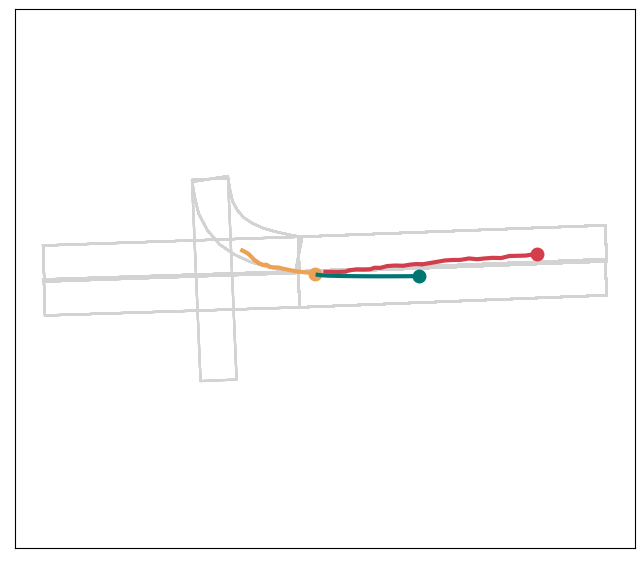

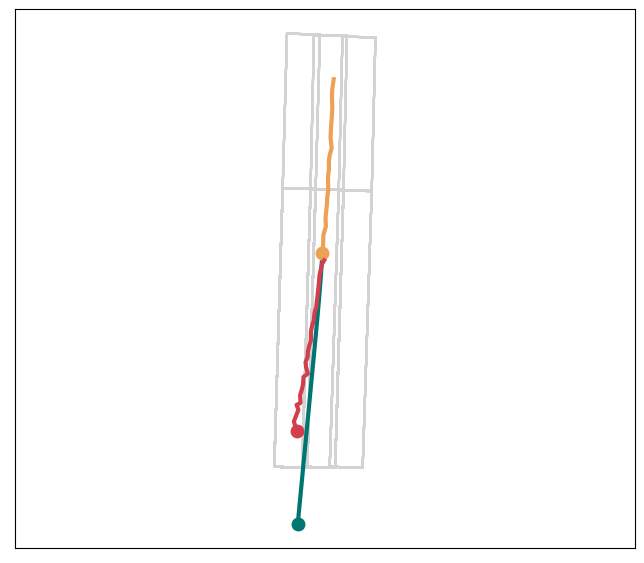

In [279]:
viz_predictions_helper(args, forecasted_trajectories, gt_trajectories, features_df, id_for_viz)

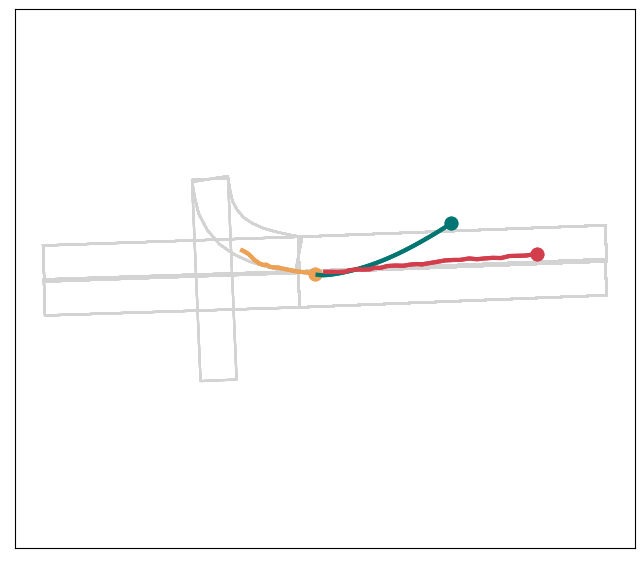

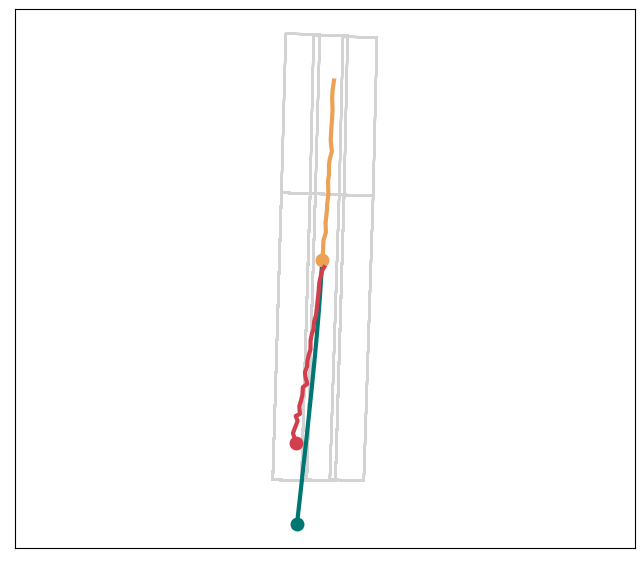

In [303]:
viz_predictions_helper(args, forecasted_trajectories, gt_trajectories, features_df, id_for_viz)

got to centerine


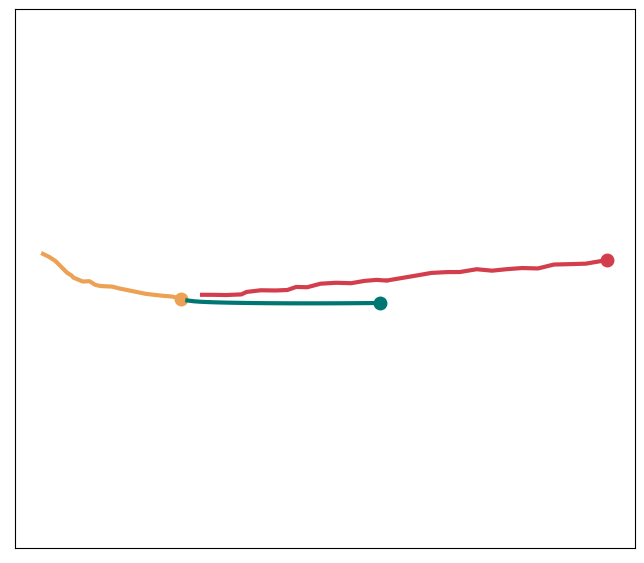

got to centerine


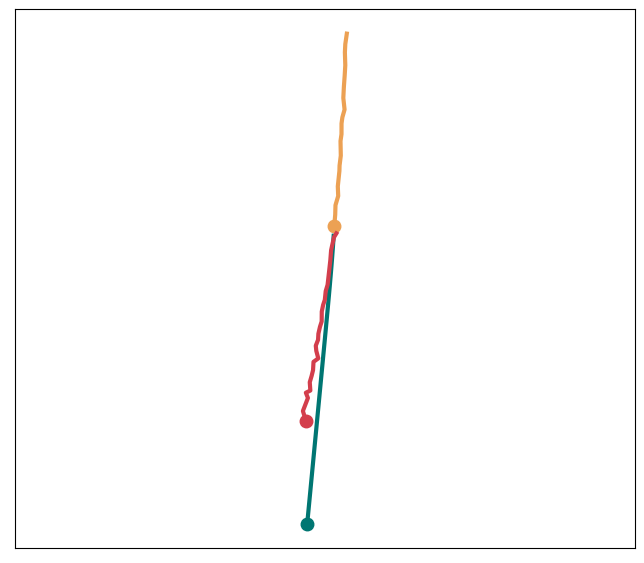

In [291]:
viz_predictions_helper(args, forecasted_trajectories, gt_trajectories, features_df, id_for_viz)

In [ ]:
def visualize_one(gt_trajectory, forcasted_trajectory,  curr_features_df):
    gt_trajectory = gt_trajectories[seq_id]
    curr_features_df = features_df[features_df["SEQUENCE"] == seq_id]
    input_trajectory = (
        curr_features_df["FEATURES"].values[0]
        [:args.obs_len, [FEATURE_FORMAT["X"], FEATURE_FORMAT["Y"]]].astype(
            "float"))
    output_trajectories = forecasted_trajectories[seq_id]
    candidate_centerlines = curr_features_df[
        "CANDIDATE_CENTERLINES"].values[0]
    city_name = curr_features_df["FEATURES"].values[0][
        0, FEATURE_FORMAT["CITY_NAME"]]

    gt_trajectory = np.expand_dims(gt_trajectory, 0)
    input_trajectory = np.expand_dims(input_trajectory, 0)
    output_trajectories = np.expand_dims(np.array(output_trajectories), 0)
    candidate_centerlines = np.expand_dims(np.array(candidate_centerlines),
                                           0)
    city_name = np.array([city_name])
    viz_predictions(
        input_trajectory,
        output_trajectories,
        gt_trajectory,
        candidate_centerlines,
        city_name,
        show=True,
    )

## trained with quantile

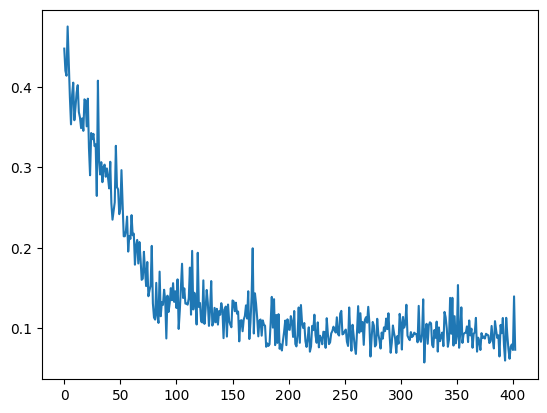

In [114]:
#mse
plt.plot(mses)
plt.show()

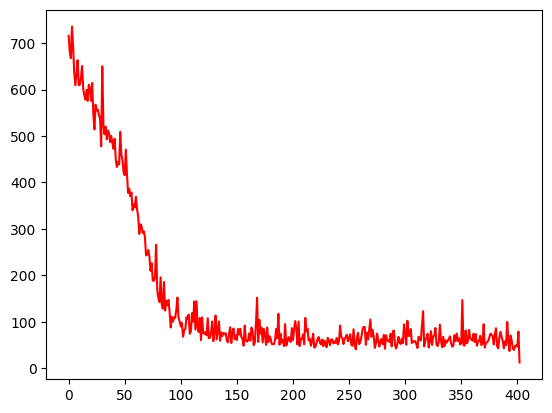

In [116]:
#quantile loss
plt.plot(losses, color='r')
plt.show()

## trained with nll

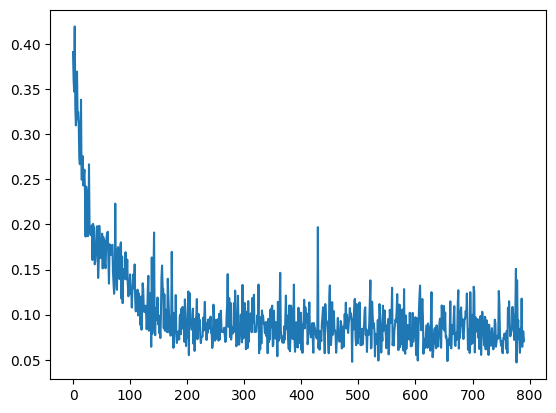

In [128]:
#mse
plt.plot(mses)
plt.show()

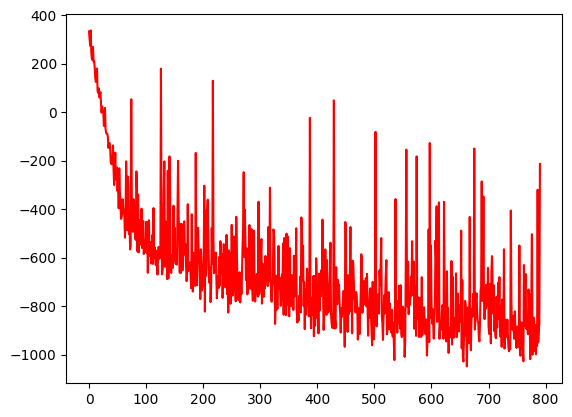

In [130]:
#nll
plt.plot(losses, c='r')
plt.show()

val

In [87]:

total_loss = []

for i, (_input, target, helpers) in enumerate(val_loader):

    _input = _input.to(device)
    target = target.to(device)

    # Set to eval mode
    encoder.eval()
    decoder.eval()

    # Encoder
    batch_size = _input.shape[0]
    input_length = _input.shape[1]
    output_length = target.shape[1]
    input_shape = _input.shape[2]

    # Initialize encoder hidden state
    encoder_hidden = model_utils.init_hidden(
        batch_size,
        encoder.module.hidden_size if use_cuda else encoder.hidden_size)

    # Initialize loss
    loss = 0

    # Encode observed trajectory
    for ei in range(input_length):
        encoder_input = _input[:, ei, :]
        encoder_hidden = encoder(encoder_input, encoder_hidden)

    # Initialize decoder input with last coordinate in encoder
    decoder_input = torch.cat([encoder_input[:, :2], 5 * torch.ones(batch_size, 2), torch.ones(batch_size, 1)], dim=1)  # big

    # Initialize decoder hidden state as encoder hidden state
    decoder_hidden = encoder_hidden

    output_shape = list(target.shape)
    output_shape[-1] = 5
    decoder_outputs = torch.zeros(output_shape).to(device)

    # Decode hidden state in future trajectory
    for di in range(output_length):
        decoder_output, decoder_hidden = decoder(decoder_input,
                                                 decoder_hidden)
        decoder_outputs[:, di, :] = Gaussian2d(decoder_output)

        # Update losses for all benchmarks
                # Update loss
        loss += criterion(output[:, :5], target[:, di, :2])
        mse += mseloss(output[:, :2], target[:, di, :2]) 
        # Use own predictions as inputs at next step
        decoder_input = decoder_output

    # Get average loss for pred_len
    loss = loss / rollout_len
    mse = mse / rollout_len
    print("loss", loss)
    print("mse", mse)

RuntimeError: The size of tensor a (118) must match the size of tensor b (512) at non-singleton dimension 0

In [15]:
for i in range(start_rollout_idx, len(ROLLOUT_LENS)):
    rollout_len = ROLLOUT_LENS[i]
    logger = Logger(log_dir, name="{}".format(rollout_len))
    best_loss = float("inf")
    prev_loss = best_loss
    while epoch < args.end_epoch:
        start = time.time()
        train(
            train_loader,
            epoch,
            criterion,
            logger,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            model_utils,
            rollout_len,
        )
        end = time.time()

        print(
            f"Training epoch completed in {(end - start) / 60.0} mins, Total time: {(end - global_start_time) / 60.0} mins"
        )

        epoch += 1
        if epoch % 5 == 0:
            start = time.time()
            prev_loss, decrement_counter = validate(
                val_loader,
                epoch,
                criterion,
                logger,
                encoder,
                decoder,
                encoder_optimizer,
                decoder_optimizer,
                model_utils,
                prev_loss,
                decrement_counter,
                rollout_len,
            )
            end = time.time()
            print(
                f"Validation completed in {(end - start) / 60.0} mins, Total time: {(end - global_start_time) / 60.0} mins"
            )

            # If val loss increased 3 times consecutively, go to next rollout length
            if decrement_counter > 2:
                break


usage: ipykernel_launcher.py [-h] [--test_batch_size TEST_BATCH_SIZE]
                             [--model_path MODEL_PATH] [--obs_len OBS_LEN]
                             [--pred_len PRED_LEN] [--normalize] [--use_delta]
                             [--train_features TRAIN_FEATURES]
                             [--val_features VAL_FEATURES]
                             [--test_features TEST_FEATURES]
                             [--joblib_batch_size JOBLIB_BATCH_SIZE]
                             [--use_map] [--use_social] [--test]
                             [--train_batch_size TRAIN_BATCH_SIZE]
                             [--val_batch_size VAL_BATCH_SIZE]
                             [--end_epoch END_EPOCH] [--lr LR]
                             [--traj_save_path TRAJ_SAVE_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/sophiasun/Library/Jupyter/runtime/kernel-254d5360-141b-4aa8-bbc8-f9a605134c59.json


SystemExit: 2